In [3]:
import sys
sys.path.append('../')
from matplotlib import pyplot as plt

import os
import numpy as np
import matplotlib.pyplot as plt


In [4]:
def get_nconts(pdb_txt, chain="A", distance_cutoff=6.0, plddt_cutoff=0): 
    """
    Calculates number of contaict in a protein.

    """

    # Get all C-alpha atoms with specific pLDDT cutoff
    ca_data, plddt = [],[]
    for line in pdb_txt.splitlines():
        col = line.split()
        if col[0] == 'ATOM'and col[4] == chain:
            plddt.append(float(col[10]))
        if (col[0] == 'ATOM' and col[2] == 'CB' and float(col[10]) > plddt_cutoff and col[4] == chain) :
            ca_data.append([
            int(col[5]), # residue index 
            np.array(list(map(float, col[6:9]))), #xyz
            float(col[10]) #pLDDT   
            ])
    if len(ca_data) == 0:
        mean_plddt = np.mean(np.array(plddt))
        return(1, round(mean_plddt * 0.01, 2))
    else:    
        coords = np.array([item[1] for item in ca_data])  # Extract coordinates
        CA_pLDDT = np.mean(np.array([item[2] for item in ca_data]))
        n_atoms = len(coords)
        pairs_data = np.zeros((0, 5))

        distances_matrix = np.linalg.norm(coords[:, None] - coords, axis=2)
        row = 0
        for i in range(n_atoms):
            for j in range(i + 4, n_atoms): # do not calc dist between atoms i, ... i+4
                if distances_matrix[i, j] < distance_cutoff:
                    #pairs_data = np.append(pairs_data, [[row, ca_data[i][0], ca_data[j][0], np.mean([ca_data[i][2], ca_data[j][2]]), distances_matrix[i, j]]], axis=0)
                    row += 1
        return(row, round(CA_pLDDT, 2), distances_matrix)





In [5]:
def get_inter_nconts(pdb_txt, chainA='A', chainB='B', distance_cutoff=6.0, plddt_cutoff=0): 
    """
    Calculates number of contaict between two protein chains
    returns a tuple (number of contacts, average plddt of residues with plddt > plddt_cutoff)
    """

    # Get all C-beta atoms with specific pLDDT cutoff
    ca_data_A, ca_data_B, = [], []
    for line in pdb_txt.splitlines():
        col = line.split()
        if (col[0] == 'ATOM' and col[2] == 'CB' and float(col[10]) > plddt_cutoff and col[4] == chainA) :
            ca_data_A.append([
            int(col[5]), # residue index 
            np.array(list(map(float, col[6:9]))), #xyz
            float(col[10]) #pLDDT   
            ])
        if (col[0] == 'ATOM' and col[2] == 'CB' and float(col[10]) > plddt_cutoff and col[4] == chainB) :
            ca_data_B.append([
            int(col[5]), # residue index 
            np.array(list(map(float, col[6:9]))), #xyz
            float(col[10]) #pLDDT   
            ])


    if len(ca_data_A) == 0 or len(ca_data_B) == 0: 
        return(1, 1)
    else:    
        coords_A = np.array([item[1] for item in ca_data_A])
        coords_B = np.array([item[1] for item in ca_data_B])
        CA_pLDDT_A = np.mean(np.array([item[2] for item in ca_data_A]))

        #make pairs of coordinates and calculate distace between them
        n_atoms_A = len(ca_data_A)
        n_atoms_B = len(ca_data_B)
        pairs_data = np.zeros((0, 4))

        distances_matrix = np.linalg.norm(coords_A[:, None] - coords_B, axis=2)
        row = 0
        for i in range(n_atoms_A):
            for j in range(i + 1, n_atoms_B):
                if distances_matrix[i, j] < distance_cutoff:
                    #pairs_data = np.append(pairs_data, [[row, ca_data_A[i][0], ca_data_B[j][0], distances_matrix[i, j]]], axis=0)
                    row += 1 
        return((row)+1, round(CA_pLDDT_A * 0.01, 3))


In [6]:
def get_nconts2(pdb_txt, chain="A", distance_cutoff=6.0, plddt_cutoff=0): 
    """
    Calculates number of contaict in a protein.

    """

    # Get all C-alpha atoms with specific pLDDT cutoff
    ca_data, plddt = [],[]
    for line in pdb_txt.splitlines():
        col = line.split()
        if col[0] == 'ATOM'and col[4] == chain:
            plddt.append(float(col[10]))
        if (col[0] == 'ATOM' and col[2] == 'CB' and float(col[10]) > plddt_cutoff and col[4] == chain) :
            ca_data.append([
            int(col[5]), # residue index 
            np.array(list(map(float, col[6:9]))), #xyz
            float(col[10]) #pLDDT   
            ])
    if len(ca_data) == 0:
        mean_plddt = np.mean(np.array(plddt))
        return(1, round(mean_plddt * 0.01, 2))
    else:    
        coords = np.array([item[1] for item in ca_data])  # Extract coordinates
        CA_pLDDT = np.mean(np.array([item[2] for item in ca_data]))
        n_CA = len(coords)
        pairs_data = np.zeros((0, 5))

        distances_matrix = np.linalg.norm(coords[:, None] - coords, axis=2)
        contact_map = distances_matrix.copy()
        contact_map[contact_map < distance_cutoff] = 1
        contact_map[contact_map > distance_cutoff] = 0
        n_contacts = contact_map[np.triu_indices(n_CA, k = 4)].sum()



        return(int(n_contacts), round(CA_pLDDT, 2), distances_matrix, contact_map)





In [148]:
get_inter_nconts(pdb_txt2)

(0, 0.914)

n_contas 63


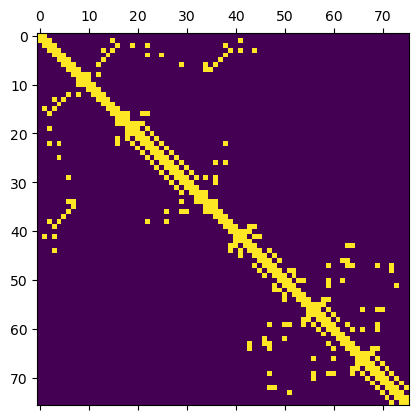

In [157]:
n, plddt, matrix, contact_map = get_nconts2(pdb_txt, 'A', 6, 0.6)
print('n_contas', n)
plt.matshow(contact_map)
#plt.xticks(())  # remove x tick marks
#plt.yticks(())  # remove y tick marks
plt.show()


In [155]:
%%time
n, plddt, matrix = get_nconts(pdb_txt, 'A', 6, 0.5)
#print(n)


CPU times: total: 0 ns
Wall time: 3 ms


In [154]:
%%time
n, plddt, matrix, contact_map = get_nconts2(pdb_txt, 'A', 6, 0.5)
#print(n)


CPU times: total: 0 ns
Wall time: 3 ms


In [156]:
get_nconts2(pdb_txt, 'A', 6, 0.5)

(63,
 0.78,
 array([[ 0.        ,  5.96330244,  7.01457939, ..., 24.86030012,
         21.22631358, 24.31252714],
        [ 5.96330244,  0.        ,  5.80332353, ..., 22.05545107,
         17.55682762, 20.21510762],
        [ 7.01457939,  5.80332353,  0.        , ..., 19.90696597,
         16.07212967, 20.02182699],
        ...,
        [24.86030012, 22.05545107, 19.90696597, ...,  0.        ,
          5.51643961,  7.56082866],
        [21.22631358, 17.55682762, 16.07212967, ...,  5.51643961,
          0.        ,  5.341022  ],
        [24.31252714, 20.21510762, 20.02182699, ...,  7.56082866,
          5.341022  ,  0.        ]]),
 array([[1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 1., 1.]]))

In [1]:
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns
from matplotlib import colors
from matplotlib.lines import Line2D


In [39]:
%%bash 

grep -v "#" progress3.log  | awk -F"\t" '{print $11}' | fold -w1 | sort | uniq -c

11654479 C
6657424 E
 262821 F
1568513 G
19192718 H
  37260 I
 244239 P
   2287 f
   3152 g
      2 s


In [40]:
%%bash 

grep -v "#" 5yiw_3_progress.log | awk  -F"\t" '{print $13}' | tail -n +30 |  fold -w1 | sort | uniq -c

1274846 C
   4662 E
  33818 F
  38130 G
2110058 H
    432 I
  22770 P
    864 f
   1107 g


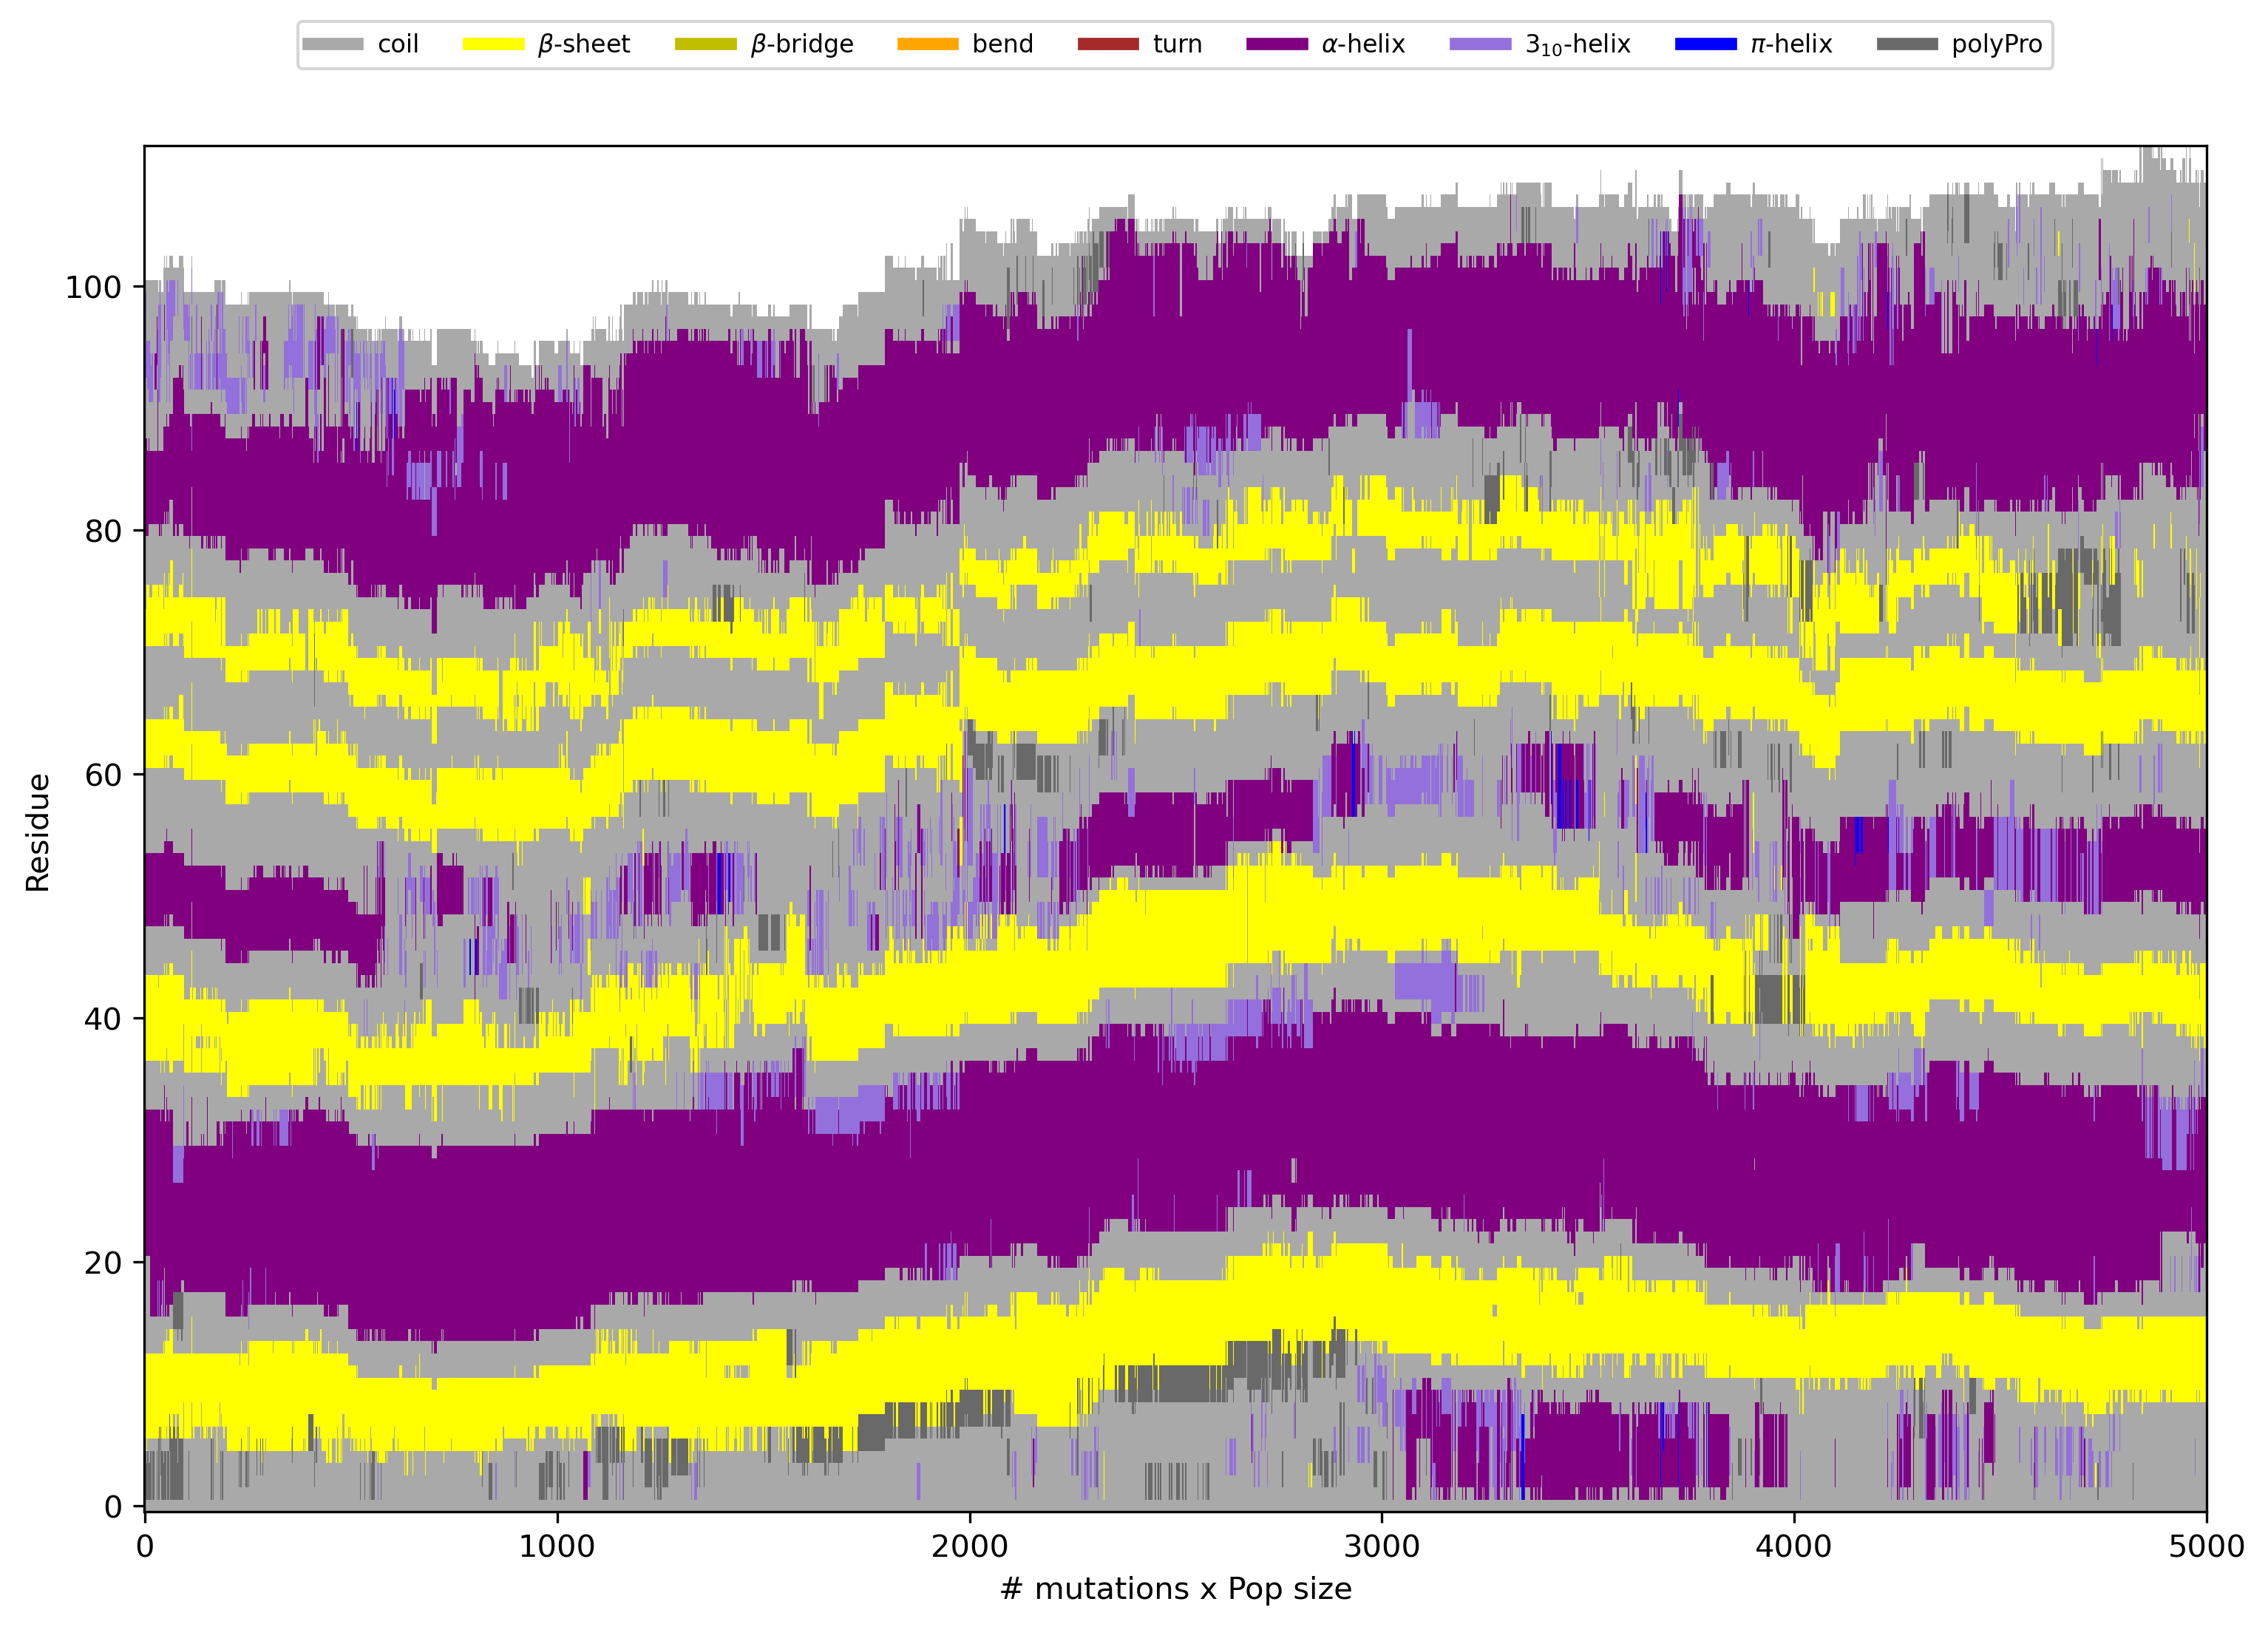

In [167]:
#log = pd.read_csv('5yiw_3_progress.log', sep='\t', comment='#')
log = pd.read_csv('progress.log', sep='\t', comment='#')
#log = pd.read_csv('progress3.log', sep='\t', comment='#')


bestlog = log.groupby('gndx').head(1)

max_seq_len = int(max(bestlog.seq_len))
bestlog_len = len(bestlog)
dpi = 300

sse = np.empty((bestlog_len, max_seq_len), dtype='U1')

i=0
for ss in bestlog.ss:
    sse[i] = list(ss + "X"*(max_seq_len-len(ss)))
    i+=1

def sse_to_num(sse):
    num = np.empty(sse.shape, dtype=int)
    num[sse == 'F'] = 0
    num[sse == 'f'] = 0
    num[sse == 'g'] = 0
    num[sse == 's'] = 0
    num[sse == 'C'] = 0    # r"coil": "grey",  #r"coil": "grey",
    num[sse == 'E'] = 1    # r"$\beta$-sheet": "yellow",  
    num[sse == 'B'] = 2    # r"$\beta$-bridge": "orange",  
    num[sse == 'S'] = 3    # r"bend": "cyan",  
    num[sse == 'T'] = 4    # r"turn": "brown",  
    num[sse == 'H'] = 5    # r"$\alpha$-helix": "purple",  
    num[sse == 'G'] = 6    # r"$3_{10}$-helix": "pink",  
    num[sse == 'I'] = 7    # r"$\pi$-helix": "blue",  
    num[sse == 'P'] = 8    # r"polyPro": "black",  
    num[sse == 'X'] = 9   # r"X": "white"  
    return num


sse_digit = sse_to_num(sse)


color_assign = {
    r"coil": "darkgrey",
    r"$\beta$-sheet": "yellow",
    r"$\beta$-bridge": "y",
    r"bend": "orange",
    r"turn": "brown",
    r"$\alpha$-helix": "purple",
    r"$3_{10}$-helix": "mediumpurple",
    r"$\pi$-helix": "blue",
    r"polyPro": "dimgrey",
    r"": "white"
    }


cmap = colors.ListedColormap(color_assign.values())

ticks = np.arange(0, len(bestlog)+1, 1000)


plt.figure(figsize=(12, 8), dpi=dpi)
plt.imshow(sse_digit.T, origin='lower', cmap=cmap,  interpolation='nearest', aspect='auto')
plt.xticks(ticks, ticks.astype(int))
plt.xlabel("# mutations x Pop size")
plt.ylabel("Residue")

custom_lines = [
    Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(color_assign)-1)]

plt.legend(
    custom_lines, color_assign.keys(), loc="upper center",
    bbox_to_anchor=(0.5, 1.1), ncol=len(color_assign), fontsize=8)



In [1]:
pdb_txt = """ATOM      1  N   GLU A   1       8.304  13.576  -2.546  1.00  0.68           N  
ATOM      2  CA  GLU A   1       7.809  12.203  -2.593  1.00  0.69           C  
ATOM      3  C   GLU A   1       6.920  11.896  -1.391  1.00  0.69           C  
ATOM      4  CB  GLU A   1       8.975  11.213  -2.652  1.00  0.63           C  
ATOM      5  O   GLU A   1       7.276  12.208  -0.253  1.00  0.64           O  
ATOM      6  CG  GLU A   1       9.656  11.144  -4.011  1.00  0.59           C  
ATOM      7  CD  GLU A   1      10.787  10.130  -4.065  1.00  0.59           C  
ATOM      8  OE1 GLU A   1      11.258   9.688  -2.993  1.00  0.61           O  
ATOM      9  OE2 GLU A   1      11.207   9.775  -5.190  1.00  0.56           O  
ATOM     10  N   TYR A   2       5.629  11.522  -1.654  1.00  0.80           N  
ATOM     11  CA  TYR A   2       4.669  11.273  -0.584  1.00  0.82           C  
ATOM     12  C   TYR A   2       4.631   9.794  -0.219  1.00  0.81           C  
ATOM     13  CB  TYR A   2       3.271  11.745  -0.996  1.00  0.78           C  
ATOM     14  O   TYR A   2       4.753   8.929  -1.089  1.00  0.78           O  
ATOM     15  CG  TYR A   2       3.137  13.246  -1.078  1.00  0.70           C  
ATOM     16  CD1 TYR A   2       2.798  13.997   0.046  1.00  0.64           C  
ATOM     17  CD2 TYR A   2       3.347  13.917  -2.278  1.00  0.66           C  
ATOM     18  CE1 TYR A   2       2.671  15.380  -0.025  1.00  0.64           C  
ATOM     19  CE2 TYR A   2       3.223  15.300  -2.360  1.00  0.65           C  
ATOM     20  OH  TYR A   2       2.762  17.391  -1.306  1.00  0.53           O  
ATOM     21  CZ  TYR A   2       2.886  16.022  -1.230  1.00  0.62           C  
ATOM     22  N   PHE A   3       4.695   9.545   1.083  1.00  0.82           N  
ATOM     23  CA  PHE A   3       4.575   8.192   1.612  1.00  0.83           C  
ATOM     24  C   PHE A   3       3.227   7.996   2.297  1.00  0.82           C  
ATOM     25  CB  PHE A   3       5.711   7.895   2.596  1.00  0.81           C  
ATOM     26  O   PHE A   3       2.742   8.891   2.992  1.00  0.79           O  
ATOM     27  CG  PHE A   3       7.072   7.851   1.956  1.00  0.77           C  
ATOM     28  CD1 PHE A   3       7.593   6.655   1.477  1.00  0.72           C  
ATOM     29  CD2 PHE A   3       7.832   9.008   1.832  1.00  0.75           C  
ATOM     30  CE1 PHE A   3       8.852   6.612   0.884  1.00  0.76           C  
ATOM     31  CE2 PHE A   3       9.092   8.972   1.241  1.00  0.77           C  
ATOM     32  CZ  PHE A   3       9.600   7.773   0.768  1.00  0.73           C  
ATOM     33  N   ARG A   4       2.621   6.927   2.025  1.00  0.80           N  
ATOM     34  CA  ARG A   4       1.338   6.589   2.634  1.00  0.80           C  
ATOM     35  C   ARG A   4       1.498   5.476   3.664  1.00  0.80           C  
ATOM     36  CB  ARG A   4       0.327   6.172   1.564  1.00  0.78           C  
ATOM     37  O   ARG A   4       2.022   4.405   3.352  1.00  0.78           O  
ATOM     38  CG  ARG A   4      -1.093   6.021   2.084  1.00  0.73           C  
ATOM     39  CD  ARG A   4      -2.089   5.813   0.951  1.00  0.70           C  
ATOM     40  NE  ARG A   4      -3.452   5.660   1.453  1.00  0.62           N  
ATOM     41  NH1 ARG A   4      -4.449   5.747  -0.629  1.00  0.50           N  
ATOM     42  NH2 ARG A   4      -5.733   5.488   1.252  1.00  0.46           N  
ATOM     43  CZ  ARG A   4      -4.542   5.632   0.691  1.00  0.63           C  
ATOM     44  N   LEU A   5       1.135   5.727   4.840  1.00  0.80           N  
ATOM     45  CA  LEU A   5       1.150   4.769   5.940  1.00  0.80           C  
ATOM     46  C   LEU A   5      -0.250   4.227   6.207  1.00  0.79           C  
ATOM     47  CB  LEU A   5       1.710   5.417   7.208  1.00  0.77           C  
ATOM     48  O   LEU A   5      -1.200   4.998   6.360  1.00  0.76           O  
ATOM     49  CG  LEU A   5       1.790   4.524   8.448  1.00  0.71           C  
ATOM     50  CD1 LEU A   5       2.931   3.522   8.307  1.00  0.64           C  
ATOM     51  CD2 LEU A   5       1.965   5.369   9.705  1.00  0.66           C  
ATOM     52  N   HIS A   6      -0.359   2.977   6.204  1.00  0.77           N  
ATOM     53  CA  HIS A   6      -1.587   2.289   6.584  1.00  0.77           C  
ATOM     54  C   HIS A   6      -1.429   1.580   7.925  1.00  0.77           C  
ATOM     55  CB  HIS A   6      -1.995   1.285   5.504  1.00  0.75           C  
ATOM     56  O   HIS A   6      -0.437   0.884   8.150  1.00  0.75           O  
ATOM     57  CG  HIS A   6      -2.451   1.926   4.231  1.00  0.69           C  
ATOM     58  CD2 HIS A   6      -1.778   2.661   3.315  1.00  0.64           C  
ATOM     59  ND1 HIS A   6      -3.751   1.844   3.781  1.00  0.55           N  
ATOM     60  CE1 HIS A   6      -3.857   2.502   2.639  1.00  0.59           C  
ATOM     61  NE2 HIS A   6      -2.675   3.008   2.335  1.00  0.56           N  
ATOM     62  N   PHE A   7      -2.351   1.718   8.781  1.00  0.75           N  
ATOM     63  CA  PHE A   7      -2.287   0.986  10.040  1.00  0.74           C  
ATOM     64  C   PHE A   7      -3.687   0.687  10.564  1.00  0.74           C  
ATOM     65  CB  PHE A   7      -1.494   1.777  11.085  1.00  0.72           C  
ATOM     66  O   PHE A   7      -4.660   1.315  10.143  1.00  0.71           O  
ATOM     67  CG  PHE A   7      -2.060   3.142  11.371  1.00  0.69           C  
ATOM     68  CD1 PHE A   7      -1.760   4.221  10.549  1.00  0.66           C  
ATOM     69  CD2 PHE A   7      -2.893   3.346  12.464  1.00  0.68           C  
ATOM     70  CE1 PHE A   7      -2.282   5.485  10.811  1.00  0.64           C  
ATOM     71  CE2 PHE A   7      -3.418   4.606  12.732  1.00  0.67           C  
ATOM     72  CZ  PHE A   7      -3.111   5.675  11.906  1.00  0.58           C  
ATOM     73  N   MET A   8      -3.819  -0.350  11.387  1.00  0.69           N  
ATOM     74  CA  MET A   8      -5.055  -0.721  12.070  1.00  0.70           C  
ATOM     75  C   MET A   8      -5.195   0.033  13.388  1.00  0.69           C  
ATOM     76  CB  MET A   8      -5.100  -2.229  12.322  1.00  0.67           C  
ATOM     77  O   MET A   8      -4.275   0.035  14.207  1.00  0.67           O  
ATOM     78  CG  MET A   8      -5.548  -3.039  11.116  1.00  0.62           C  
ATOM     79  SD  MET A   8      -6.495  -4.538  11.589  1.00  0.51           S  
ATOM     80  CE  MET A   8      -5.194  -5.490  12.421  1.00  0.50           C  
ATOM     81  N   ASP A   9      -6.302   0.760  13.480  1.00  0.69           N  
ATOM     82  CA  ASP A   9      -6.667   1.412  14.733  1.00  0.69           C  
ATOM     83  C   ASP A   9      -8.111   1.095  15.116  1.00  0.69           C  
ATOM     84  CB  ASP A   9      -6.471   2.926  14.628  1.00  0.66           C  
ATOM     85  O   ASP A   9      -9.045   1.470  14.404  1.00  0.67           O  
ATOM     86  CG  ASP A   9      -6.640   3.640  15.957  1.00  0.62           C  
ATOM     87  OD1 ASP A   9      -6.820   2.964  16.994  1.00  0.63           O  
ATOM     88  OD2 ASP A   9      -6.596   4.889  15.968  1.00  0.66           O  
ATOM     89  N   THR A  10      -8.355   0.431  16.235  1.00  0.70           N  
ATOM     90  CA  THR A  10      -9.660   0.057  16.768  1.00  0.69           C  
ATOM     91  C   THR A  10     -10.491  -0.663  15.709  1.00  0.69           C  
ATOM     92  CB  THR A  10     -10.430   1.290  17.278  1.00  0.66           C  
ATOM     93  O   THR A  10     -11.661  -0.336  15.503  1.00  0.67           O  
ATOM     94  CG2 THR A  10      -9.718   1.931  18.464  1.00  0.60           C  
ATOM     95  OG1 THR A  10     -10.534   2.251  16.220  1.00  0.63           O  
ATOM     96  N   GLY A  11      -9.957  -1.604  15.019  1.00  0.66           N  
ATOM     97  CA  GLY A  11     -10.647  -2.462  14.069  1.00  0.65           C  
ATOM     98  C   GLY A  11     -10.844  -1.813  12.712  1.00  0.66           C  
ATOM     99  O   GLY A  11     -11.498  -2.381  11.835  1.00  0.63           O  
ATOM    100  N   GLN A  12     -10.382  -0.469  12.667  1.00  0.71           N  
ATOM    101  CA  GLN A  12     -10.526   0.236  11.398  1.00  0.71           C  
ATOM    102  C   GLN A  12      -9.164   0.541  10.780  1.00  0.71           C  
ATOM    103  CB  GLN A  12     -11.317   1.531  11.590  1.00  0.68           C  
ATOM    104  O   GLN A  12      -8.189   0.775  11.498  1.00  0.69           O  
ATOM    105  CG  GLN A  12     -12.772   1.311  11.981  1.00  0.63           C  
ATOM    106  CD  GLN A  12     -13.577   2.596  11.997  1.00  0.62           C  
ATOM    107  NE2 GLN A  12     -14.897   2.469  12.080  1.00  0.51           N  
ATOM    108  OE1 GLN A  12     -13.017   3.696  11.937  1.00  0.60           O  
ATOM    109  N   ILE A  13      -9.070   0.468   9.475  1.00  0.71           N  
ATOM    110  CA  ILE A  13      -7.860   0.831   8.747  1.00  0.71           C  
ATOM    111  C   ILE A  13      -7.764   2.351   8.631  1.00  0.71           C  
ATOM    112  CB  ILE A  13      -7.827   0.184   7.344  1.00  0.69           C  
ATOM    113  O   ILE A  13      -8.720   3.009   8.214  1.00  0.68           O  
ATOM    114  CG1 ILE A  13      -7.809  -1.345   7.462  1.00  0.61           C  
ATOM    115  CG2 ILE A  13      -6.622   0.686   6.545  1.00  0.62           C  
ATOM    116  CD1 ILE A  13      -8.038  -2.070   6.143  1.00  0.60           C  
ATOM    117  N   LYS A  14      -6.725   2.886   9.052  1.00  0.75           N  
ATOM    118  CA  LYS A  14      -6.450   4.315   8.937  1.00  0.75           C  
ATOM    119  C   LYS A  14      -5.212   4.570   8.083  1.00  0.75           C  
ATOM    120  CB  LYS A  14      -6.269   4.940  10.321  1.00  0.73           C  
ATOM    121  O   LYS A  14      -4.370   3.684   7.920  1.00  0.73           O  
ATOM    122  CG  LYS A  14      -7.506   4.858  11.204  1.00  0.68           C  
ATOM    123  CD  LYS A  14      -7.366   5.730  12.445  1.00  0.66           C  
ATOM    124  CE  LYS A  14      -8.636   5.718  13.284  1.00  0.57           C  
ATOM    125  NZ  LYS A  14      -8.470   6.492  14.552  1.00  0.50           N  
ATOM    126  N   TYR A  15      -5.170   5.602   7.429  1.00  0.76           N  
ATOM    127  CA  TYR A  15      -3.982   5.927   6.647  1.00  0.76           C  
ATOM    128  C   TYR A  15      -3.518   7.352   6.927  1.00  0.76           C  
ATOM    129  CB  TYR A  15      -4.259   5.753   5.151  1.00  0.73           C  
ATOM    130  O   TYR A  15      -4.303   8.191   7.374  1.00  0.74           O  
ATOM    131  CG  TYR A  15      -5.454   6.533   4.660  1.00  0.69           C  
ATOM    132  CD1 TYR A  15      -6.729   5.973   4.674  1.00  0.64           C  
ATOM    133  CD2 TYR A  15      -5.310   7.830   4.180  1.00  0.65           C  
ATOM    134  CE1 TYR A  15      -7.833   6.688   4.220  1.00  0.59           C  
ATOM    135  CE2 TYR A  15      -6.407   8.554   3.723  1.00  0.62           C  
ATOM    136  OH  TYR A  15      -8.751   8.687   3.298  1.00  0.43           O  
ATOM    137  CZ  TYR A  15      -7.662   7.975   3.748  1.00  0.57           C  
ATOM    138  N   SER A  16      -2.288   7.626   6.791  1.00  0.78           N  
ATOM    139  CA  SER A  16      -1.650   8.929   6.945  1.00  0.78           C  
ATOM    140  C   SER A  16      -0.630   9.180   5.839  1.00  0.79           C  
ATOM    141  CB  SER A  16      -0.970   9.035   8.310  1.00  0.76           C  
ATOM    142  O   SER A  16      -0.037   8.238   5.309  1.00  0.77           O  
ATOM    143  OG  SER A  16      -1.916   8.889   9.356  1.00  0.68           O  
ATOM    144  N   TYR A  17      -0.494  10.484   5.457  1.00  0.78           N  
ATOM    145  CA  TYR A  17       0.452  10.869   4.417  1.00  0.79           C  
ATOM    146  C   TYR A  17       1.620  11.654   5.004  1.00  0.78           C  
ATOM    147  CB  TYR A  17      -0.245  11.702   3.337  1.00  0.75           C  
ATOM    148  O   TYR A  17       1.428  12.502   5.879  1.00  0.76           O  
ATOM    149  CG  TYR A  17      -1.301  10.942   2.572  1.00  0.69           C  
ATOM    150  CD1 TYR A  17      -0.974  10.213   1.431  1.00  0.64           C  
ATOM    151  CD2 TYR A  17      -2.628  10.952   2.988  1.00  0.65           C  
ATOM    152  CE1 TYR A  17      -1.945   9.513   0.722  1.00  0.61           C  
ATOM    153  CE2 TYR A  17      -3.607  10.255   2.287  1.00  0.63           C  
ATOM    154  OH  TYR A  17      -4.221   8.848   0.459  1.00  0.49           O  
ATOM    155  CZ  TYR A  17      -3.256   9.540   1.157  1.00  0.59           C  
ATOM    156  N   PHE A  18       2.743  11.236   4.499  1.00  0.80           N  
ATOM    157  CA  PHE A  18       3.946  11.924   4.951  1.00  0.81           C  
ATOM    158  C   PHE A  18       4.768  12.414   3.766  1.00  0.80           C  
ATOM    159  CB  PHE A  18       4.794  11.002   5.834  1.00  0.79           C  
ATOM    160  O   PHE A  18       4.912  11.704   2.768  1.00  0.77           O  
ATOM    161  CG  PHE A  18       4.084  10.527   7.073  1.00  0.75           C  
ATOM    162  CD1 PHE A  18       4.222  11.210   8.275  1.00  0.71           C  
ATOM    163  CD2 PHE A  18       3.279   9.396   7.035  1.00  0.73           C  
ATOM    164  CE1 PHE A  18       3.567  10.773   9.424  1.00  0.75           C  
ATOM    165  CE2 PHE A  18       2.621   8.953   8.179  1.00  0.75           C  
ATOM    166  CZ  PHE A  18       2.767   9.642   9.372  1.00  0.73           C  
ATOM    167  N   GLN A  19       5.256  13.624   3.787  1.00  0.79           N  
ATOM    168  CA  GLN A  19       6.116  14.145   2.730  1.00  0.79           C  
ATOM    169  C   GLN A  19       7.537  13.605   2.861  1.00  0.77           C  
ATOM    170  CB  GLN A  19       6.132  15.675   2.756  1.00  0.74           C  
ATOM    171  O   GLN A  19       8.285  13.567   1.882  1.00  0.73           O  
ATOM    172  CG  GLN A  19       4.888  16.313   2.154  1.00  0.66           C  
ATOM    173  CD  GLN A  19       4.944  17.829   2.158  1.00  0.64           C  
ATOM    174  NE2 GLN A  19       3.931  18.462   1.578  1.00  0.54           N  
ATOM    175  OE1 GLN A  19       5.891  18.426   2.680  1.00  0.63           O  
ATOM    176  N   GLN A  20       7.871  13.269   4.054  1.00  0.77           N  
ATOM    177  CA  GLN A  20       9.230  12.796   4.293  1.00  0.78           C  
ATOM    178  C   GLN A  20       9.235  11.335   4.734  1.00  0.78           C  
ATOM    179  CB  GLN A  20       9.924  13.664   5.344  1.00  0.73           C  
ATOM    180  O   GLN A  20       8.460  10.943   5.610  1.00  0.75           O  
ATOM    181  CG  GLN A  20      10.126  15.110   4.911  1.00  0.66           C  
ATOM    182  CD  GLN A  20      10.946  15.911   5.905  1.00  0.64           C  
ATOM    183  NE2 GLN A  20      11.106  17.202   5.638  1.00  0.54           N  
ATOM    184  OE1 GLN A  20      11.431  15.373   6.906  1.00  0.63           O  
ATOM    185  N   LYS A  21      10.110  10.481   4.092  1.00  0.77           N  
ATOM    186  CA  LYS A  21      10.248   9.067   4.428  1.00  0.77           C  
ATOM    187  C   LYS A  21      10.511   8.879   5.919  1.00  0.78           C  
ATOM    188  CB  LYS A  21      11.373   8.428   3.613  1.00  0.74           C  
ATOM    189  O   LYS A  21       9.926   7.997   6.552  1.00  0.77           O  
ATOM    190  CG  LYS A  21      11.487   6.921   3.789  1.00  0.68           C  
ATOM    191  CD  LYS A  21      12.587   6.337   2.911  1.00  0.67           C  
ATOM    192  CE  LYS A  21      12.741   4.838   3.130  1.00  0.62           C  
ATOM    193  NZ  LYS A  21      13.841   4.267   2.297  1.00  0.51           N  
ATOM    194  N   ASP A  22      11.334   9.715   6.476  1.00  0.79           N  
ATOM    195  CA  ASP A  22      11.722   9.519   7.869  1.00  0.79           C  
ATOM    196  C   ASP A  22      10.534   9.729   8.805  1.00  0.79           C  
ATOM    197  CB  ASP A  22      12.863  10.466   8.247  1.00  0.75           C  
ATOM    198  O   ASP A  22      10.413   9.048   9.826  1.00  0.77           O  
ATOM    199  CG  ASP A  22      14.198  10.054   7.651  1.00  0.68           C  
ATOM    200  OD1 ASP A  22      14.325   8.904   7.176  1.00  0.65           O  
ATOM    201  OD2 ASP A  22      15.131  10.885   7.659  1.00  0.70           O  
ATOM    202  N   ASP A  23       9.732  10.718   8.369  1.00  0.80           N  
ATOM    203  CA  ASP A  23       8.552  10.955   9.195  1.00  0.80           C  
ATOM    204  C   ASP A  23       7.607   9.756   9.161  1.00  0.80           C  
ATOM    205  CB  ASP A  23       7.819  12.217   8.735  1.00  0.77           C  
ATOM    206  O   ASP A  23       7.086   9.340  10.198  1.00  0.78           O  
ATOM    207  CG  ASP A  23       8.602  13.490   9.004  1.00  0.70           C  
ATOM    208  OD1 ASP A  23       9.498  13.482   9.875  1.00  0.68           O  
ATOM    209  OD2 ASP A  23       8.318  14.511   8.341  1.00  0.72           O  
ATOM    210  N   ALA A  24       7.417   9.215   8.028  1.00  0.81           N  
ATOM    211  CA  ALA A  24       6.563   8.041   7.871  1.00  0.81           C  
ATOM    212  C   ALA A  24       7.105   6.858   8.668  1.00  0.81           C  
ATOM    213  CB  ALA A  24       6.435   7.670   6.395  1.00  0.79           C  
ATOM    214  O   ALA A  24       6.350   6.169   9.359  1.00  0.79           O  
ATOM    215  N   GLN A  25       8.416   6.603   8.577  1.00  0.78           N  
ATOM    216  CA  GLN A  25       9.058   5.485   9.261  1.00  0.80           C  
ATOM    217  C   GLN A  25       8.939   5.627  10.776  1.00  0.80           C  
ATOM    218  CB  GLN A  25      10.529   5.381   8.857  1.00  0.76           C  
ATOM    219  O   GLN A  25       8.756   4.635  11.485  1.00  0.79           O  
ATOM    220  CG  GLN A  25      11.207   4.101   9.328  1.00  0.67           C  
ATOM    221  CD  GLN A  25      10.599   2.855   8.713  1.00  0.65           C  
ATOM    222  NE2 GLN A  25      10.336   1.851   9.543  1.00  0.55           N  
ATOM    223  OE1 GLN A  25      10.366   2.794   7.501  1.00  0.64           O  
ATOM    224  N   THR A  26       9.096   6.830  11.227  1.00  0.81           N  
ATOM    225  CA  THR A  26       8.944   7.070  12.658  1.00  0.80           C  
ATOM    226  C   THR A  26       7.543   6.688  13.124  1.00  0.79           C  
ATOM    227  CB  THR A  26       9.222   8.543  13.009  1.00  0.78           C  
ATOM    228  O   THR A  26       7.383   6.036  14.158  1.00  0.77           O  
ATOM    229  CG2 THR A  26       9.015   8.802  14.498  1.00  0.69           C  
ATOM    230  OG1 THR A  26      10.575   8.865  12.663  1.00  0.71           O  
ATOM    231  N   HIS A  27       6.551   7.142  12.417  1.00  0.79           N  
ATOM    232  CA  HIS A  27       5.169   6.837  12.770  1.00  0.79           C  
ATOM    233  C   HIS A  27       4.889   5.342  12.659  1.00  0.78           C  
ATOM    234  CB  HIS A  27       4.204   7.620  11.879  1.00  0.76           C  
ATOM    235  O   HIS A  27       4.110   4.793  13.440  1.00  0.75           O  
ATOM    236  CG  HIS A  27       3.968   9.024  12.338  1.00  0.68           C  
ATOM    237  CD2 HIS A  27       2.895   9.596  12.934  1.00  0.63           C  
ATOM    238  ND1 HIS A  27       4.908  10.021  12.196  1.00  0.62           N  
ATOM    239  CE1 HIS A  27       4.423  11.149  12.687  1.00  0.59           C  
ATOM    240  NE2 HIS A  27       3.203  10.918  13.142  1.00  0.59           N  
ATOM    241  N   LEU A  28       5.507   4.720  11.654  1.00  0.76           N  
ATOM    242  CA  LEU A  28       5.448   3.267  11.534  1.00  0.77           C  
ATOM    243  C   LEU A  28       5.932   2.596  12.815  1.00  0.77           C  
ATOM    244  CB  LEU A  28       6.290   2.792  10.347  1.00  0.73           C  
ATOM    245  O   LEU A  28       5.285   1.678  13.324  1.00  0.75           O  
ATOM    246  CG  LEU A  28       6.172   1.312   9.981  1.00  0.65           C  
ATOM    247  CD1 LEU A  28       4.843   1.042   9.284  1.00  0.58           C  
ATOM    248  CD2 LEU A  28       7.341   0.884   9.100  1.00  0.60           C  
ATOM    249  N   THR A  29       7.081   2.955  13.275  1.00  0.79           N  
ATOM    250  CA  THR A  29       7.663   2.368  14.477  1.00  0.79           C  
ATOM    251  C   THR A  29       6.733   2.551  15.673  1.00  0.79           C  
ATOM    252  CB  THR A  29       9.037   2.989  14.793  1.00  0.76           C  
ATOM    253  O   THR A  29       6.557   1.632  16.476  1.00  0.77           O  
ATOM    254  CG2 THR A  29       9.653   2.356  16.036  1.00  0.66           C  
ATOM    255  OG1 THR A  29       9.915   2.782  13.679  1.00  0.70           O  
ATOM    256  N   GLU A  30       6.184   3.713  15.721  1.00  0.78           N  
ATOM    257  CA  GLU A  30       5.279   4.004  16.829  1.00  0.78           C  
ATOM    258  C   GLU A  30       4.067   3.077  16.809  1.00  0.76           C  
ATOM    259  CB  GLU A  30       4.825   5.465  16.783  1.00  0.74           C  
ATOM    260  O   GLU A  30       3.648   2.572  17.852  1.00  0.74           O  
ATOM    261  CG  GLU A  30       5.919   6.461  17.139  1.00  0.67           C  
ATOM    262  CD  GLU A  30       5.480   7.910  17.001  1.00  0.65           C  
ATOM    263  OE1 GLU A  30       4.348   8.159  16.528  1.00  0.66           O  
ATOM    264  OE2 GLU A  30       6.275   8.804  17.369  1.00  0.62           O  
ATOM    265  N   LYS A  31       3.550   2.900  15.627  1.00  0.76           N  
ATOM    266  CA  LYS A  31       2.355   2.073  15.489  1.00  0.75           C  
ATOM    267  C   LYS A  31       2.667   0.605  15.767  1.00  0.76           C  
ATOM    268  CB  LYS A  31       1.756   2.225  14.090  1.00  0.73           C  
ATOM    269  O   LYS A  31       1.864  -0.100  16.381  1.00  0.74           O  
ATOM    270  CG  LYS A  31       1.228   3.620  13.791  1.00  0.69           C  
ATOM    271  CD  LYS A  31       0.061   3.983  14.700  1.00  0.68           C  
ATOM    272  CE  LYS A  31      -0.442   5.395  14.430  1.00  0.62           C  
ATOM    273  NZ  LYS A  31      -1.263   5.917  15.563  1.00  0.53           N  
ATOM    274  N   ARG A  32       3.845   0.127  15.361  1.00  0.75           N  
ATOM    275  CA  ARG A  32       4.278  -1.242  15.621  1.00  0.76           C  
ATOM    276  C   ARG A  32       4.456  -1.486  17.115  1.00  0.77           C  
ATOM    277  CB  ARG A  32       5.584  -1.543  14.881  1.00  0.73           C  
ATOM    278  O   ARG A  32       4.111  -2.556  17.621  1.00  0.76           O  
ATOM    279  CG  ARG A  32       5.404  -1.799  13.393  1.00  0.66           C  
ATOM    280  CD  ARG A  32       6.734  -2.065  12.702  1.00  0.63           C  
ATOM    281  NE  ARG A  32       6.550  -2.418  11.297  1.00  0.54           N  
ATOM    282  NH1 ARG A  32       8.802  -2.386  10.781  1.00  0.40           N  
ATOM    283  NH2 ARG A  32       7.257  -2.885   9.163  1.00  0.36           N  
ATOM    284  CZ  ARG A  32       7.537  -2.562  10.417  1.00  0.56           C  
ATOM    285  N   GLU A  33       5.055  -0.578  17.712  1.00  0.75           N  
ATOM    286  CA  GLU A  33       5.256  -0.700  19.153  1.00  0.76           C  
ATOM    287  C   GLU A  33       3.924  -0.813  19.889  1.00  0.74           C  
ATOM    288  CB  GLU A  33       6.052   0.494  19.687  1.00  0.71           C  
ATOM    289  O   GLU A  33       3.851  -1.414  20.963  1.00  0.71           O  
ATOM    290  CG  GLU A  33       7.527   0.466  19.313  1.00  0.65           C  
ATOM    291  CD  GLU A  33       8.286   1.701  19.772  1.00  0.63           C  
ATOM    292  OE1 GLU A  33       7.651   2.640  20.305  1.00  0.67           O  
ATOM    293  OE2 GLU A  33       9.524   1.730  19.597  1.00  0.61           O  
ATOM    294  N   ALA A  34       2.964  -0.269  19.210  1.00  0.73           N  
ATOM    295  CA  ALA A  34       1.627  -0.357  19.792  1.00  0.73           C  
ATOM    296  C   ALA A  34       0.914  -1.628  19.341  1.00  0.73           C  
ATOM    297  CB  ALA A  34       0.803   0.873  19.420  1.00  0.69           C  
ATOM    298  O   ALA A  34      -0.284  -1.794  19.581  1.00  0.69           O  
ATOM    299  N   ASN A  35       1.661  -2.560  18.777  1.00  0.72           N  
ATOM    300  CA  ASN A  35       1.203  -3.862  18.304  1.00  0.71           C  
ATOM    301  C   ASN A  35       0.154  -3.721  17.205  1.00  0.70           C  
ATOM    302  CB  ASN A  35       0.648  -4.690  19.465  1.00  0.65           C  
ATOM    303  O   ASN A  35      -0.768  -4.534  17.113  1.00  0.64           O  
ATOM    304  CG  ASN A  35       1.740  -5.261  20.348  1.00  0.60           C  
ATOM    305  ND2 ASN A  35       1.410  -5.514  21.610  1.00  0.56           N  
ATOM    306  OD1 ASN A  35       2.870  -5.473  19.902  1.00  0.58           O  
ATOM    307  N   GLN A  36       0.352  -2.625  16.429  1.00  0.72           N  
ATOM    308  CA  GLN A  36      -0.581  -2.420  15.327  1.00  0.72           C  
ATOM    309  C   GLN A  36       0.023  -2.877  14.002  1.00  0.71           C  
ATOM    310  CB  GLN A  36      -0.991  -0.949  15.236  1.00  0.68           C  
ATOM    311  O   GLN A  36       1.234  -2.774  13.798  1.00  0.67           O  
ATOM    312  CG  GLN A  36      -1.797  -0.460  16.432  1.00  0.62           C  
ATOM    313  CD  GLN A  36      -2.205   0.996  16.310  1.00  0.62           C  
ATOM    314  NE2 GLN A  36      -3.239   1.386  17.048  1.00  0.51           N  
ATOM    315  OE1 GLN A  36      -1.596   1.764  15.559  1.00  0.60           O  
ATOM    316  N   ILE A  37      -0.713  -3.530  13.191  1.00  0.73           N  
ATOM    317  CA  ILE A  37      -0.278  -3.886  11.845  1.00  0.73           C  
ATOM    318  C   ILE A  37      -0.162  -2.627  10.990  1.00  0.73           C  
ATOM    319  CB  ILE A  37      -1.246  -4.895  11.186  1.00  0.70           C  
ATOM    320  O   ILE A  37      -1.113  -1.848  10.888  1.00  0.70           O  
ATOM    321  CG1 ILE A  37      -1.317  -6.184  12.011  1.00  0.63           C  
ATOM    322  CG2 ILE A  37      -0.819  -5.190   9.745  1.00  0.63           C  
ATOM    323  CD1 ILE A  37      -2.424  -7.136  11.578  1.00  0.61           C  
ATOM    324  N   CYS A  38       1.091  -2.289  10.553  1.00  0.75           N  
ATOM    325  CA  CYS A  38       1.262  -1.056   9.792  1.00  0.76           C  
ATOM    326  C   CYS A  38       2.102  -1.298   8.544  1.00  0.75           C  
ATOM    327  CB  CYS A  38       1.915   0.021  10.658  1.00  0.72           C  
ATOM    328  O   CYS A  38       3.017  -2.124   8.556  1.00  0.71           O  
ATOM    329  SG  CYS A  38       3.554  -0.431  11.269  1.00  0.71           S  
ATOM    330  N   HIS A  39       1.790  -0.653   7.489  1.00  0.78           N  
ATOM    331  CA  HIS A  39       2.507  -0.723   6.221  1.00  0.79           C  
ATOM    332  C   HIS A  39       2.728   0.667   5.635  1.00  0.79           C  
ATOM    333  CB  HIS A  39       1.746  -1.599   5.223  1.00  0.77           C  
ATOM    334  O   HIS A  39       1.896   1.560   5.814  1.00  0.78           O  
ATOM    335  CG  HIS A  39       1.552  -3.007   5.687  1.00  0.73           C  
ATOM    336  CD2 HIS A  39       0.492  -3.614   6.270  1.00  0.70           C  
ATOM    337  ND1 HIS A  39       2.532  -3.970   5.571  1.00  0.69           N  
ATOM    338  CE1 HIS A  39       2.079  -5.111   6.063  1.00  0.68           C  
ATOM    339  NE2 HIS A  39       0.844  -4.922   6.494  1.00  0.66           N  
ATOM    340  N   VAL A  40       3.868   0.878   4.948  1.00  0.81           N  
ATOM    341  CA  VAL A  40       4.151   2.155   4.302  1.00  0.81           C  
ATOM    342  C   VAL A  40       4.575   1.919   2.854  1.00  0.81           C  
ATOM    343  CB  VAL A  40       5.247   2.942   5.056  1.00  0.79           C  
ATOM    344  O   VAL A  40       5.403   1.048   2.577  1.00  0.80           O  
ATOM    345  CG1 VAL A  40       5.729   4.129   4.224  1.00  0.69           C  
ATOM    346  CG2 VAL A  40       4.726   3.413   6.413  1.00  0.68           C  
ATOM    347  N   TRP A  41       4.042   2.689   1.995  1.00  0.82           N  
ATOM    348  CA  TRP A  41       4.427   2.654   0.588  1.00  0.83           C  
ATOM    349  C   TRP A  41       4.622   4.064   0.041  1.00  0.83           C  
ATOM    350  CB  TRP A  41       3.372   1.914  -0.240  1.00  0.81           C  
ATOM    351  O   TRP A  41       4.041   5.023   0.556  1.00  0.80           O  
ATOM    352  CG  TRP A  41       3.196   0.475   0.144  1.00  0.75           C  
ATOM    353  CD1 TRP A  41       3.969  -0.582  -0.248  1.00  0.69           C  
ATOM    354  CD2 TRP A  41       2.179  -0.064   0.992  1.00  0.72           C  
ATOM    355  CE2 TRP A  41       2.396  -1.458   1.072  1.00  0.74           C  
ATOM    356  CE3 TRP A  41       1.103   0.496   1.695  1.00  0.78           C  
ATOM    357  NE1 TRP A  41       3.493  -1.747   0.307  1.00  0.78           N  
ATOM    358  CH2 TRP A  41       0.531  -1.726   2.504  1.00  0.73           C  
ATOM    359  CZ2 TRP A  41       1.576  -2.299   1.827  1.00  0.76           C  
ATOM    360  CZ3 TRP A  41       0.288  -0.344   2.446  1.00  0.75           C  
ATOM    361  N   LYS A  42       5.490   4.158  -0.979  1.00  0.85           N  
ATOM    362  CA  LYS A  42       5.460   5.402  -1.745  1.00  0.86           C  
ATOM    363  C   LYS A  42       4.099   5.608  -2.404  1.00  0.85           C  
ATOM    364  CB  LYS A  42       6.562   5.407  -2.805  1.00  0.83           C  
ATOM    365  O   LYS A  42       3.542   4.680  -2.995  1.00  0.84           O  
ATOM    366  CG  LYS A  42       7.970   5.490  -2.234  1.00  0.75           C  
ATOM    367  CD  LYS A  42       9.016   5.579  -3.337  1.00  0.73           C  
ATOM    368  CE  LYS A  42      10.429   5.594  -2.769  1.00  0.68           C  
ATOM    369  NZ  LYS A  42      11.459   5.667  -3.848  1.00  0.58           N  
ATOM    370  N   TRP A  43       3.486   6.857  -2.323  1.00  0.83           N  
ATOM    371  CA  TRP A  43       2.155   7.147  -2.846  1.00  0.84           C  
ATOM    372  C   TRP A  43       2.043   6.733  -4.309  1.00  0.84           C  
ATOM    373  CB  TRP A  43       1.832   8.636  -2.697  1.00  0.80           C  
ATOM    374  O   TRP A  43       1.055   6.114  -4.711  1.00  0.82           O  
ATOM    375  CG  TRP A  43       0.619   9.075  -3.461  1.00  0.68           C  
ATOM    376  CD1 TRP A  43       0.583   9.577  -4.733  1.00  0.58           C  
ATOM    377  CD2 TRP A  43      -0.735   9.056  -2.999  1.00  0.61           C  
ATOM    378  CE2 TRP A  43      -1.541   9.560  -4.044  1.00  0.57           C  
ATOM    379  CE3 TRP A  43      -1.346   8.661  -1.801  1.00  0.68           C  
ATOM    380  NE1 TRP A  43      -0.713   9.870  -5.089  1.00  0.67           N  
ATOM    381  CH2 TRP A  43      -3.500   9.285  -2.745  1.00  0.59           C  
ATOM    382  CZ2 TRP A  43      -2.928   9.679  -3.926  1.00  0.68           C  
ATOM    383  CZ3 TRP A  43      -2.726   8.780  -1.687  1.00  0.49           C  
ATOM    384  N   GLU A  44       3.065   7.059  -5.022  1.00  0.86           N  
ATOM    385  CA  GLU A  44       2.986   6.799  -6.456  1.00  0.86           C  
ATOM    386  C   GLU A  44       2.841   5.307  -6.740  1.00  0.87           C  
ATOM    387  CB  GLU A  44       4.220   7.354  -7.172  1.00  0.84           C  
ATOM    388  O   GLU A  44       2.043   4.906  -7.589  1.00  0.85           O  
ATOM    389  CG  GLU A  44       4.187   7.174  -8.683  1.00  0.75           C  
ATOM    390  CD  GLU A  44       5.444   7.679  -9.374  1.00  0.70           C  
ATOM    391  OE1 GLU A  44       6.368   8.158  -8.679  1.00  0.66           O  
ATOM    392  OE2 GLU A  44       5.504   7.596 -10.621  1.00  0.61           O  
ATOM    393  N   HIS A  45       3.649   4.491  -5.948  1.00  0.87           N  
ATOM    394  CA  HIS A  45       3.583   3.048  -6.148  1.00  0.88           C  
ATOM    395  C   HIS A  45       2.247   2.486  -5.676  1.00  0.87           C  
ATOM    396  CB  HIS A  45       4.733   2.353  -5.417  1.00  0.86           C  
ATOM    397  O   HIS A  45       1.624   1.683  -6.374  1.00  0.86           O  
ATOM    398  CG  HIS A  45       6.083   2.686  -5.968  1.00  0.83           C  
ATOM    399  CD2 HIS A  45       6.458   3.550  -6.941  1.00  0.80           C  
ATOM    400  ND1 HIS A  45       7.240   2.093  -5.512  1.00  0.80           N  
ATOM    401  CE1 HIS A  45       8.271   2.580  -6.181  1.00  0.80           C  
ATOM    402  NE2 HIS A  45       7.824   3.466  -7.055  1.00  0.78           N  
ATOM    403  N   TRP A  46       1.853   2.935  -4.565  1.00  0.85           N  
ATOM    404  CA  TRP A  46       0.587   2.466  -4.012  1.00  0.86           C  
ATOM    405  C   TRP A  46      -0.571   2.796  -4.947  1.00  0.85           C  
ATOM    406  CB  TRP A  46       0.340   3.085  -2.633  1.00  0.84           C  
ATOM    407  O   TRP A  46      -1.411   1.939  -5.231  1.00  0.83           O  
ATOM    408  CG  TRP A  46      -0.907   2.596  -1.960  1.00  0.76           C  
ATOM    409  CD1 TRP A  46      -1.003   1.603  -1.026  1.00  0.67           C  
ATOM    410  CD2 TRP A  46      -2.238   3.076  -2.175  1.00  0.70           C  
ATOM    411  CE2 TRP A  46      -3.092   2.327  -1.335  1.00  0.73           C  
ATOM    412  CE3 TRP A  46      -2.791   4.067  -2.996  1.00  0.81           C  
ATOM    413  NE1 TRP A  46      -2.315   1.436  -0.646  1.00  0.80           N  
ATOM    414  CH2 TRP A  46      -4.988   3.516  -2.107  1.00  0.74           C  
ATOM    415  CZ2 TRP A  46      -4.472   2.540  -1.294  1.00  0.77           C  
ATOM    416  CZ3 TRP A  46      -4.165   4.278  -2.953  1.00  0.75           C  
ATOM    417  N   SER A  47      -0.687   4.108  -5.380  1.00  0.85           N  
ATOM    418  CA  SER A  47      -1.786   4.604  -6.203  1.00  0.85           C  
ATOM    419  C   SER A  47      -1.874   3.845  -7.523  1.00  0.85           C  
ATOM    420  CB  SER A  47      -1.619   6.100  -6.475  1.00  0.83           C  
ATOM    421  O   SER A  47      -2.968   3.505  -7.978  1.00  0.84           O  
ATOM    422  OG  SER A  47      -2.671   6.582  -7.294  1.00  0.74           O  
ATOM    423  N   VAL A  48      -0.686   3.557  -8.112  1.00  0.88           N  
ATOM    424  CA  VAL A  48      -0.647   2.797  -9.357  1.00  0.88           C  
ATOM    425  C   VAL A  48      -1.143   1.374  -9.109  1.00  0.88           C  
ATOM    426  CB  VAL A  48       0.775   2.768  -9.960  1.00  0.87           C  
ATOM    427  O   VAL A  48      -1.982   0.864  -9.854  1.00  0.87           O  
ATOM    428  CG1 VAL A  48       0.836   1.820 -11.156  1.00  0.84           C  
ATOM    429  CG2 VAL A  48       1.210   4.175 -10.367  1.00  0.83           C  
ATOM    430  N   CYS A  49      -0.729   0.721  -8.054  1.00  0.87           N  
ATOM    431  CA  CYS A  49      -1.169  -0.628  -7.716  1.00  0.87           C  
ATOM    432  C   CYS A  49      -2.676  -0.671  -7.493  1.00  0.86           C  
ATOM    433  CB  CYS A  49      -0.445  -1.132  -6.468  1.00  0.86           C  
ATOM    434  O   CYS A  49      -3.368  -1.518  -8.059  1.00  0.84           O  
ATOM    435  SG  CYS A  49      -0.873  -2.826  -6.012  1.00  0.83           S  
ATOM    436  N   ASP A  50      -3.171   0.247  -6.683  1.00  0.84           N  
ATOM    437  CA  ASP A  50      -4.589   0.324  -6.344  1.00  0.84           C  
ATOM    438  C   ASP A  50      -5.442   0.515  -7.596  1.00  0.84           C  
ATOM    439  CB  ASP A  50      -4.843   1.464  -5.355  1.00  0.82           C  
ATOM    440  O   ASP A  50      -6.492  -0.116  -7.740  1.00  0.82           O  
ATOM    441  CG  ASP A  50      -6.283   1.522  -4.876  1.00  0.78           C  
ATOM    442  OD1 ASP A  50      -6.770   0.534  -4.286  1.00  0.75           O  
ATOM    443  OD2 ASP A  50      -6.937   2.565  -5.092  1.00  0.77           O  
ATOM    444  N   SER A  51      -5.021   1.370  -8.490  1.00  0.86           N  
ATOM    445  CA  SER A  51      -5.769   1.662  -9.708  1.00  0.86           C  
ATOM    446  C   SER A  51      -5.867   0.432 -10.604  1.00  0.86           C  
ATOM    447  CB  SER A  51      -5.116   2.812 -10.476  1.00  0.84           C  
ATOM    448  O   SER A  51      -6.937   0.131 -11.139  1.00  0.85           O  
ATOM    449  OG  SER A  51      -5.194   4.019  -9.737  1.00  0.75           O  
ATOM    450  N   TYR A  52      -4.726  -0.263 -10.757  1.00  0.88           N  
ATOM    451  CA  TYR A  52      -4.732  -1.462 -11.587  1.00  0.88           C  
ATOM    452  C   TYR A  52      -5.643  -2.531 -10.996  1.00  0.87           C  
ATOM    453  CB  TYR A  52      -3.312  -2.015 -11.744  1.00  0.87           C  
ATOM    454  O   TYR A  52      -6.399  -3.182 -11.721  1.00  0.86           O  
ATOM    455  CG  TYR A  52      -2.571  -1.458 -12.935  1.00  0.83           C  
ATOM    456  CD1 TYR A  52      -2.698  -2.040 -14.194  1.00  0.79           C  
ATOM    457  CD2 TYR A  52      -1.742  -0.348 -12.803  1.00  0.79           C  
ATOM    458  CE1 TYR A  52      -2.015  -1.531 -15.294  1.00  0.80           C  
ATOM    459  CE2 TYR A  52      -1.055   0.169 -13.896  1.00  0.81           C  
ATOM    460  OH  TYR A  52      -0.520   0.081 -16.221  1.00  0.72           O  
ATOM    461  CZ  TYR A  52      -1.198  -0.427 -15.135  1.00  0.77           C  
ATOM    462  N   LEU A  53      -5.593  -2.712  -9.670  1.00  0.85           N  
ATOM    463  CA  LEU A  53      -6.428  -3.711  -9.013  1.00  0.85           C  
ATOM    464  C   LEU A  53      -7.903  -3.333  -9.107  1.00  0.85           C  
ATOM    465  CB  LEU A  53      -6.022  -3.869  -7.545  1.00  0.84           C  
ATOM    466  O   LEU A  53      -8.754  -4.192  -9.349  1.00  0.83           O  
ATOM    467  CG  LEU A  53      -4.653  -4.498  -7.285  1.00  0.82           C  
ATOM    468  CD1 LEU A  53      -4.263  -4.331  -5.820  1.00  0.79           C  
ATOM    469  CD2 LEU A  53      -4.657  -5.971  -7.678  1.00  0.80           C  
ATOM    470  N   ALA A  54      -8.197  -2.016  -8.930  1.00  0.83           N  
ATOM    471  CA  ALA A  54      -9.567  -1.515  -9.001  1.00  0.83           C  
ATOM    472  C   ALA A  54     -10.162  -1.739 -10.389  1.00  0.83           C  
ATOM    473  CB  ALA A  54      -9.612  -0.033  -8.640  1.00  0.82           C  
ATOM    474  O   ALA A  54     -11.377  -1.887 -10.534  1.00  0.82           O  
ATOM    475  N   LEU A  55      -9.320  -1.806 -11.376  1.00  0.85           N  
ATOM    476  CA  LEU A  55      -9.768  -2.009 -12.750  1.00  0.85           C  
ATOM    477  C   LEU A  55      -9.867  -3.495 -13.076  1.00  0.84           C  
ATOM    478  CB  LEU A  55      -8.814  -1.322 -13.731  1.00  0.83           C  
ATOM    479  O   LEU A  55     -10.176  -3.867 -14.210  1.00  0.82           O  
ATOM    480  CG  LEU A  55      -8.817   0.208 -13.720  1.00  0.77           C  
ATOM    481  CD1 LEU A  55      -7.654   0.745 -14.549  1.00  0.73           C  
ATOM    482  CD2 LEU A  55     -10.145   0.745 -14.242  1.00  0.74           C  
ATOM    483  N   GLY A  56      -9.557  -4.332 -12.118  1.00  0.83           N  
ATOM    484  CA  GLY A  56      -9.726  -5.766 -12.291  1.00  0.83           C  
ATOM    485  C   GLY A  56      -8.464  -6.463 -12.762  1.00  0.83           C  
ATOM    486  O   GLY A  56      -8.508  -7.620 -13.186  1.00  0.81           O  
ATOM    487  N   SER A  57      -7.352  -5.775 -12.791  1.00  0.86           N  
ATOM    488  CA  SER A  57      -6.079  -6.375 -13.177  1.00  0.86           C  
ATOM    489  C   SER A  57      -5.633  -7.425 -12.165  1.00  0.86           C  
ATOM    490  CB  SER A  57      -5.001  -5.300 -13.318  1.00  0.84           C  
ATOM    491  O   SER A  57      -6.019  -7.371 -10.996  1.00  0.83           O  
ATOM    492  OG  SER A  57      -5.270  -4.460 -14.428  1.00  0.71           O  
ATOM    493  N   ASN A  58      -4.843  -8.442 -12.680  1.00  0.88           N  
ATOM    494  CA  ASN A  58      -4.325  -9.449 -11.761  1.00  0.87           C  
ATOM    495  C   ASN A  58      -3.132  -8.923 -10.968  1.00  0.88           C  
ATOM    496  CB  ASN A  58      -3.939 -10.721 -12.519  1.00  0.85           C  
ATOM    497  O   ASN A  58      -2.571  -7.878 -11.303  1.00  0.86           O  
ATOM    498  CG  ASN A  58      -2.796 -10.497 -13.491  1.00  0.78           C  
ATOM    499  ND2 ASN A  58      -2.820 -11.213 -14.609  1.00  0.73           N  
ATOM    500  OD1 ASN A  58      -1.900  -9.688 -13.238  1.00  0.73           O  
ATOM    501  N   LEU A  59      -2.745  -9.603  -9.825  1.00  0.87           N  
ATOM    502  CA  LEU A  59      -1.739  -9.155  -8.868  1.00  0.87           C  
ATOM    503  C   LEU A  59      -0.378  -9.004  -9.540  1.00  0.88           C  
ATOM    504  CB  LEU A  59      -1.638 -10.137  -7.698  1.00  0.85           C  
ATOM    505  O   LEU A  59       0.372  -8.076  -9.230  1.00  0.87           O  
ATOM    506  CG  LEU A  59      -2.749 -10.060  -6.650  1.00  0.77           C  
ATOM    507  CD1 LEU A  59      -2.671 -11.255  -5.706  1.00  0.70           C  
ATOM    508  CD2 LEU A  59      -2.661  -8.751  -5.872  1.00  0.70           C  
ATOM    509  N   VAL A  60      -0.112  -9.887 -10.482  1.00  0.89           N  
ATOM    510  CA  VAL A  60       1.190  -9.891 -11.139  1.00  0.90           C  
ATOM    511  C   VAL A  60       1.356  -8.617 -11.966  1.00  0.89           C  
ATOM    512  CB  VAL A  60       1.370 -11.136 -12.037  1.00  0.87           C  
ATOM    513  O   VAL A  60       2.398  -7.961 -11.905  1.00  0.88           O  
ATOM    514  CG1 VAL A  60       2.665 -11.039 -12.841  1.00  0.76           C  
ATOM    515  CG2 VAL A  60       1.355 -12.408 -11.192  1.00  0.75           C  
ATOM    516  N   ASN A  61       0.306  -8.263 -12.768  1.00  0.89           N  
ATOM    517  CA  ASN A  61       0.343  -7.032 -13.550  1.00  0.90           C  
ATOM    518  C   ASN A  61       0.422  -5.800 -12.653  1.00  0.90           C  
ATOM    519  CB  ASN A  61      -0.878  -6.942 -14.469  1.00  0.87           C  
ATOM    520  O   ASN A  61       1.171  -4.865 -12.940  1.00  0.88           O  
ATOM    521  CG  ASN A  61      -0.799  -7.902 -15.639  1.00  0.77           C  
ATOM    522  ND2 ASN A  61      -1.917  -8.086 -16.331  1.00  0.73           N  
ATOM    523  OD1 ASN A  61       0.257  -8.475 -15.919  1.00  0.72           O  
ATOM    524  N   ALA A  62      -0.397  -5.777 -11.581  1.00  0.89           N  
ATOM    525  CA  ALA A  62      -0.388  -4.646 -10.658  1.00  0.90           C  
ATOM    526  C   ALA A  62       1.003  -4.429 -10.069  1.00  0.90           C  
ATOM    527  CB  ALA A  62      -1.407  -4.862  -9.541  1.00  0.88           C  
ATOM    528  O   ALA A  62       1.479  -3.295  -9.985  1.00  0.88           O  
ATOM    529  N   ALA A  63       1.657  -5.547  -9.683  1.00  0.90           N  
ATOM    530  CA  ALA A  63       3.002  -5.479  -9.116  1.00  0.91           C  
ATOM    531  C   ALA A  63       4.002  -4.952 -10.141  1.00  0.91           C  
ATOM    532  CB  ALA A  63       3.436  -6.852  -8.610  1.00  0.89           C  
ATOM    533  O   ALA A  63       4.820  -4.083  -9.829  1.00  0.90           O  
ATOM    534  N   THR A  64       3.952  -5.494 -11.331  1.00  0.93           N  
ATOM    535  CA  THR A  64       4.880  -5.120 -12.392  1.00  0.92           C  
ATOM    536  C   THR A  64       4.775  -3.629 -12.702  1.00  0.92           C  
ATOM    537  CB  THR A  64       4.621  -5.933 -13.674  1.00  0.91           C  
ATOM    538  O   THR A  64       5.787  -2.926 -12.747  1.00  0.90           O  
ATOM    539  CG2 THR A  64       5.585  -5.530 -14.785  1.00  0.81           C  
ATOM    540  OG1 THR A  64       4.791  -7.327 -13.391  1.00  0.83           O  
ATOM    541  N   TYR A  65       3.569  -3.127 -12.844  1.00  0.92           N  
ATOM    542  CA  TYR A  65       3.378  -1.754 -13.300  1.00  0.92           C  
ATOM    543  C   TYR A  65       3.589  -0.767 -12.158  1.00  0.91           C  
ATOM    544  CB  TYR A  65       1.978  -1.574 -13.894  1.00  0.90           C  
ATOM    545  O   TYR A  65       3.996   0.375 -12.384  1.00  0.89           O  
ATOM    546  CG  TYR A  65       1.803  -2.227 -15.243  1.00  0.86           C  
ATOM    547  CD1 TYR A  65       2.444  -1.723 -16.372  1.00  0.80           C  
ATOM    548  CD2 TYR A  65       0.994  -3.349 -15.392  1.00  0.81           C  
ATOM    549  CE1 TYR A  65       2.284  -2.320 -17.618  1.00  0.81           C  
ATOM    550  CE2 TYR A  65       0.827  -3.955 -16.633  1.00  0.81           C  
ATOM    551  OH  TYR A  65       1.312  -4.030 -18.969  1.00  0.67           O  
ATOM    552  CZ  TYR A  65       1.475  -3.434 -17.738  1.00  0.79           C  
ATOM    553  N   SER A  66       3.307  -1.140 -10.958  1.00  0.89           N  
ATOM    554  CA  SER A  66       3.441  -0.246  -9.813  1.00  0.90           C  
ATOM    555  C   SER A  66       4.869  -0.240  -9.280  1.00  0.88           C  
ATOM    556  CB  SER A  66       2.474  -0.652  -8.699  1.00  0.88           C  
ATOM    557  O   SER A  66       5.277   0.699  -8.593  1.00  0.86           O  
ATOM    558  OG  SER A  66       2.831  -1.912  -8.158  1.00  0.81           O  
ATOM    559  N   GLY A  67       5.678  -1.289  -9.505  1.00  0.89           N  
ATOM    560  CA  GLY A  67       7.009  -1.446  -8.940  1.00  0.90           C  
ATOM    561  C   GLY A  67       6.997  -2.016  -7.534  1.00  0.89           C  
ATOM    562  O   GLY A  67       8.015  -1.992  -6.841  1.00  0.86           O  
ATOM    563  N   LEU A  68       5.829  -2.419  -7.062  1.00  0.88           N  
ATOM    564  CA  LEU A  68       5.690  -3.081  -5.770  1.00  0.89           C  
ATOM    565  C   LEU A  68       5.808  -4.595  -5.920  1.00  0.88           C  
ATOM    566  CB  LEU A  68       4.349  -2.724  -5.125  1.00  0.87           C  
ATOM    567  O   LEU A  68       5.735  -5.120  -7.033  1.00  0.86           O  
ATOM    568  CG  LEU A  68       4.148  -1.255  -4.747  1.00  0.82           C  
ATOM    569  CD1 LEU A  68       2.737  -1.033  -4.213  1.00  0.76           C  
ATOM    570  CD2 LEU A  68       5.189  -0.821  -3.720  1.00  0.77           C  
ATOM    571  N   SER A  69       6.150  -5.278  -4.755  1.00  0.88           N  
ATOM    572  CA  SER A  69       6.144  -6.737  -4.751  1.00  0.88           C  
ATOM    573  C   SER A  69       4.725  -7.285  -4.873  1.00  0.88           C  
ATOM    574  CB  SER A  69       6.798  -7.273  -3.477  1.00  0.87           C  
ATOM    575  O   SER A  69       3.760  -6.607  -4.513  1.00  0.87           O  
ATOM    576  OG  SER A  69       5.958  -7.066  -2.355  1.00  0.84           O  
ATOM    577  N   ALA A  70       4.613  -8.496  -5.404  1.00  0.87           N  
ATOM    578  CA  ALA A  70       3.312  -9.160  -5.429  1.00  0.88           C  
ATOM    579  C   ALA A  70       2.699  -9.217  -4.033  1.00  0.87           C  
ATOM    580  CB  ALA A  70       3.445 -10.567  -6.006  1.00  0.85           C  
ATOM    581  O   ALA A  70       1.482  -9.085  -3.877  1.00  0.85           O  
ATOM    582  N   HIS A  71       3.578  -9.424  -3.029  1.00  0.86           N  
ATOM    583  CA  HIS A  71       3.122  -9.467  -1.645  1.00  0.86           C  
ATOM    584  C   HIS A  71       2.493  -8.141  -1.230  1.00  0.86           C  
ATOM    585  CB  HIS A  71       4.282  -9.814  -0.709  1.00  0.84           C  
ATOM    586  O   HIS A  71       1.426  -8.122  -0.613  1.00  0.84           O  
ATOM    587  CG  HIS A  71       3.896  -9.854   0.735  1.00  0.77           C  
ATOM    588  CD2 HIS A  71       4.160  -8.998   1.750  1.00  0.72           C  
ATOM    589  ND1 HIS A  71       3.145 -10.875   1.277  1.00  0.69           N  
ATOM    590  CE1 HIS A  71       2.964 -10.644   2.567  1.00  0.70           C  
ATOM    591  NE2 HIS A  71       3.570  -9.511   2.879  1.00  0.66           N  
ATOM    592  N   ASP A  72       3.120  -7.016  -1.515  1.00  0.84           N  
ATOM    593  CA  ASP A  72       2.576  -5.701  -1.188  1.00  0.85           C  
ATOM    594  C   ASP A  72       1.266  -5.450  -1.930  1.00  0.85           C  
ATOM    595  CB  ASP A  72       3.589  -4.603  -1.522  1.00  0.83           C  
ATOM    596  O   ASP A  72       0.311  -4.923  -1.354  1.00  0.83           O  
ATOM    597  CG  ASP A  72       4.731  -4.526  -0.524  1.00  0.79           C  
ATOM    598  OD1 ASP A  72       4.552  -4.943   0.641  1.00  0.79           O  
ATOM    599  OD2 ASP A  72       5.818  -4.042  -0.905  1.00  0.80           O  
ATOM    600  N   CYS A  73       1.185  -5.875  -3.235  1.00  0.86           N  
ATOM    601  CA  CYS A  73      -0.028  -5.670  -4.019  1.00  0.86           C  
ATOM    602  C   CYS A  73      -1.185  -6.486  -3.456  1.00  0.85           C  
ATOM    603  CB  CYS A  73       0.209  -6.047  -5.481  1.00  0.85           C  
ATOM    604  O   CYS A  73      -2.329  -6.029  -3.453  1.00  0.83           O  
ATOM    605  SG  CYS A  73       1.253  -4.875  -6.375  1.00  0.85           S  
ATOM    606  N   LYS A  74      -0.815  -7.695  -2.925  1.00  0.85           N  
ATOM    607  CA  LYS A  74      -1.827  -8.523  -2.275  1.00  0.85           C  
ATOM    608  C   LYS A  74      -2.355  -7.854  -1.009  1.00  0.84           C  
ATOM    609  CB  LYS A  74      -1.258  -9.903  -1.940  1.00  0.83           C  
ATOM    610  O   LYS A  74      -3.557  -7.890  -0.737  1.00  0.82           O  
ATOM    611  CG  LYS A  74      -2.294 -10.894  -1.432  1.00  0.79           C  
ATOM    612  CD  LYS A  74      -1.697 -12.283  -1.248  1.00  0.76           C  
ATOM    613  CE  LYS A  74      -2.747 -13.290  -0.800  1.00  0.70           C  
ATOM    614  NZ  LYS A  74      -2.183 -14.668  -0.690  1.00  0.63           N  
ATOM    615  N   LEU A  75      -1.465  -7.211  -0.227  1.00  0.82           N  
ATOM    616  CA  LEU A  75      -1.876  -6.496   0.975  1.00  0.81           C  
ATOM    617  C   LEU A  75      -2.787  -5.324   0.626  1.00  0.81           C  
ATOM    618  CB  LEU A  75      -0.651  -5.993   1.745  1.00  0.80           C  
ATOM    619  O   LEU A  75      -3.781  -5.079   1.313  1.00  0.79           O  
ATOM    620  CG  LEU A  75       0.220  -7.063   2.404  1.00  0.77           C  
ATOM    621  CD1 LEU A  75       1.469  -6.430   3.009  1.00  0.73           C  
ATOM    622  CD2 LEU A  75      -0.571  -7.818   3.467  1.00  0.74           C  
ATOM    623  N   ILE A  76      -2.423  -4.612  -0.437  1.00  0.82           N  
ATOM    624  CA  ILE A  76      -3.211  -3.474  -0.896  1.00  0.82           C  
ATOM    625  C   ILE A  76      -4.589  -3.951  -1.352  1.00  0.82           C  
ATOM    626  CB  ILE A  76      -2.500  -2.718  -2.041  1.00  0.81           C  
ATOM    627  O   ILE A  76      -5.606  -3.336  -1.022  1.00  0.80           O  
ATOM    628  CG1 ILE A  76      -1.262  -1.987  -1.509  1.00  0.80           C  
ATOM    629  CG2 ILE A  76      -3.462  -1.742  -2.724  1.00  0.79           C  
ATOM    630  CD1 ILE A  76      -0.358  -1.427  -2.599  1.00  0.78           C  
ATOM    631  N   TRP A  77      -4.697  -4.998  -2.137  1.00  0.81           N  
ATOM    632  CA  TRP A  77      -5.936  -5.580  -2.644  1.00  0.81           C  
ATOM    633  C   TRP A  77      -6.875  -5.943  -1.499  1.00  0.80           C  
ATOM    634  CB  TRP A  77      -5.640  -6.821  -3.491  1.00  0.78           C  
ATOM    635  O   TRP A  77      -8.083  -5.704  -1.579  1.00  0.76           O  
ATOM    636  CG  TRP A  77      -6.867  -7.523  -3.991  1.00  0.71           C  
ATOM    637  CD1 TRP A  77      -7.397  -8.692  -3.520  1.00  0.64           C  
ATOM    638  CD2 TRP A  77      -7.715  -7.102  -5.063  1.00  0.67           C  
ATOM    639  CE2 TRP A  77      -8.742  -8.065  -5.187  1.00  0.66           C  
ATOM    640  CE3 TRP A  77      -7.708  -6.003  -5.932  1.00  0.75           C  
ATOM    641  NE1 TRP A  77      -8.524  -9.023  -4.235  1.00  0.75           N  
ATOM    642  CH2 TRP A  77      -9.721  -6.875  -6.984  1.00  0.69           C  
ATOM    643  CZ2 TRP A  77      -9.752  -7.960  -6.146  1.00  0.72           C  
ATOM    644  CZ3 TRP A  77      -8.714  -5.900  -6.886  1.00  0.69           C  
ATOM    645  N   LYS A  78      -6.314  -6.509  -0.405  1.00  0.77           N  
ATOM    646  CA  LYS A  78      -7.091  -7.029   0.716  1.00  0.76           C  
ATOM    647  C   LYS A  78      -7.624  -5.897   1.589  1.00  0.76           C  
ATOM    648  CB  LYS A  78      -6.246  -7.987   1.557  1.00  0.74           C  
ATOM    649  O   LYS A  78      -8.521  -6.106   2.408  1.00  0.72           O  
ATOM    650  CG  LYS A  78      -5.985  -9.330   0.891  1.00  0.70           C  
ATOM    651  CD  LYS A  78      -5.279 -10.294   1.836  1.00  0.68           C  
ATOM    652  CE  LYS A  78      -5.177 -11.691   1.237  1.00  0.60           C  
ATOM    653  NZ  LYS A  78      -4.491 -12.641   2.163  1.00  0.54           N  
ATOM    654  N   MET A  79      -7.055  -4.815   1.399  1.00  0.71           N  
ATOM    655  CA  MET A  79      -7.448  -3.705   2.262  1.00  0.71           C  
ATOM    656  C   MET A  79      -8.901  -3.313   2.015  1.00  0.70           C  
ATOM    657  CB  MET A  79      -6.535  -2.499   2.036  1.00  0.68           C  
ATOM    658  O   MET A  79      -9.652  -3.071   2.962  1.00  0.67           O  
ATOM    659  CG  MET A  79      -5.144  -2.664   2.625  1.00  0.64           C  
ATOM    660  SD  MET A  79      -4.322  -1.055   2.949  1.00  0.55           S  
ATOM    661  CE  MET A  79      -3.455  -1.444   4.494  1.00  0.52           C  
ATOM    662  N   PRO A  80      -9.405  -3.107   0.733  1.00  0.57           N  
ATOM    663  CA  PRO A  80     -10.796  -2.687   0.543  1.00  0.56           C  
ATOM    664  C   PRO A  80     -11.797  -3.666   1.150  1.00  0.57           C  
ATOM    665  CB  PRO A  80     -10.941  -2.631  -0.980  1.00  0.52           C  
ATOM    666  O   PRO A  80     -12.903  -3.271   1.525  1.00  0.56           O  
ATOM    667  CG  PRO A  80      -9.568  -2.899  -1.506  1.00  0.50           C  
ATOM    668  CD  PRO A  80      -8.699  -3.345  -0.364  1.00  0.51           C  
ATOM    669  N   TYR A  81     -11.459  -4.984   1.216  1.00  0.53           N  
ATOM    670  CA  TYR A  81     -12.442  -5.900   1.783  1.00  0.53           C  
ATOM    671  C   TYR A  81     -12.574  -5.696   3.287  1.00  0.53           C  
ATOM    672  CB  TYR A  81     -12.058  -7.352   1.484  1.00  0.47           C  
ATOM    673  O   TYR A  81     -13.569  -6.104   3.890  1.00  0.51           O  
ATOM    674  CG  TYR A  81     -12.360  -7.782   0.069  1.00  0.44           C  
ATOM    675  CD1 TYR A  81     -13.642  -8.180  -0.301  1.00  0.39           C  
ATOM    676  CD2 TYR A  81     -11.363  -7.790  -0.901  1.00  0.42           C  
ATOM    677  CE1 TYR A  81     -13.925  -8.578  -1.603  1.00  0.42           C  
ATOM    678  CE2 TYR A  81     -11.634  -8.186  -2.207  1.00  0.45           C  
ATOM    679  OH  TYR A  81     -13.189  -8.971  -3.839  1.00  0.36           O  
ATOM    680  CZ  TYR A  81     -12.916  -8.578  -2.548  1.00  0.38           C  
ATOM    681  N   TRP A  82     -11.825  -4.849   3.889  1.00  0.38           N  
ATOM    682  CA  TRP A  82     -12.110  -4.514   5.280  1.00  0.46           C  
ATOM    683  C   TRP A  82     -13.135  -3.388   5.370  1.00  0.39           C  
ATOM    684  CB  TRP A  82     -10.826  -4.112   6.010  1.00  0.37           C  
ATOM    685  O   TRP A  82     -13.662  -3.105   6.449  1.00  0.39           O  
ATOM    686  CG  TRP A  82      -9.833  -5.226   6.155  1.00  0.38           C  
ATOM    687  CD1 TRP A  82      -9.071  -5.784   5.167  1.00  0.35           C  
ATOM    688  CD2 TRP A  82      -9.499  -5.920   7.361  1.00  0.37           C  
ATOM    689  CE2 TRP A  82      -8.526  -6.888   7.030  1.00  0.36           C  
ATOM    690  CE3 TRP A  82      -9.929  -5.817   8.691  1.00  0.40           C  
ATOM    691  NE1 TRP A  82      -8.282  -6.785   5.687  1.00  0.37           N  
ATOM    692  CH2 TRP A  82      -8.412  -7.627   9.275  1.00  0.29           C  
ATOM    693  CZ2 TRP A  82      -7.974  -7.749   7.982  1.00  0.30           C  
ATOM    694  CZ3 TRP A  82      -9.378  -6.674   9.637  1.00  0.31           C  
ATOM    695  N   TYR A  83     -13.417  -2.671   4.230  1.00  0.43           N  
ATOM    696  CA  TYR A  83     -14.384  -1.588   4.371  1.00  0.44           C  
ATOM    697  C   TYR A  83     -15.787  -2.059   4.007  1.00  0.44           C  
ATOM    698  CB  TYR A  83     -13.989  -0.397   3.493  1.00  0.40           C  
ATOM    699  O   TYR A  83     -16.758  -1.315   4.162  1.00  0.43           O  
ATOM    700  CG  TYR A  83     -12.790   0.363   4.005  1.00  0.39           C  
ATOM    701  CD1 TYR A  83     -12.918   1.298   5.030  1.00  0.35           C  
ATOM    702  CD2 TYR A  83     -11.526   0.150   3.464  1.00  0.38           C  
ATOM    703  CE1 TYR A  83     -11.816   2.002   5.504  1.00  0.36           C  
ATOM    704  CE2 TYR A  83     -10.417   0.848   3.930  1.00  0.41           C  
ATOM    705  OH  TYR A  83      -9.477   2.465   5.414  1.00  0.25           O  
ATOM    706  CZ  TYR A  83     -10.572   1.770   4.949  1.00  0.35           C  
ATOM    707  N   GLY A  84     -16.131  -3.364   3.932  1.00  0.33           N  
ATOM    708  CA  GLY A  84     -17.566  -3.597   3.897  1.00  0.35           C  
ATOM    709  C   GLY A  84     -18.088  -4.295   5.139  1.00  0.33           C  
ATOM    710  O   GLY A  84     -17.345  -5.010   5.814  1.00  0.31           O  """

In [2]:
pdb_txt2 = '''PARENT N/A
ATOM      1  N   THR A   1       1.755  -9.191  21.217  1.00 88.71           N  
ATOM      2  CA  THR A   1       1.993  -8.453  19.982  1.00 91.14           C  
ATOM      3  C   THR A   1       0.946  -7.358  19.796  1.00 92.57           C  
ATOM      4  CB  THR A   1       1.982  -9.390  18.760  1.00 87.42           C  
ATOM      5  O   THR A   1      -0.255  -7.635  19.795  1.00 91.55           O  
ATOM      6  CG2 THR A   1       2.343  -8.635  17.484  1.00 73.10           C  
ATOM      7  OG1 THR A   1       2.933 -10.443  18.964  1.00 72.08           O  
ATOM      8  N   PRO A   2       1.364  -6.043  19.757  1.00 94.53           N  
ATOM      9  CA  PRO A   2       0.401  -4.960  19.543  1.00 95.07           C  
ATOM     10  C   PRO A   2      -0.414  -5.140  18.264  1.00 95.00           C  
ATOM     11  CB  PRO A   2       1.285  -3.714  19.456  1.00 94.04           C  
ATOM     12  O   PRO A   2       0.056  -5.765  17.310  1.00 94.53           O  
ATOM     13  CG  PRO A   2       2.586  -4.125  20.066  1.00 90.37           C  
ATOM     14  CD  PRO A   2       2.766  -5.601  19.856  1.00 87.72           C  
ATOM     15  N   THR A   3      -1.640  -4.667  18.368  1.00 95.50           N  
ATOM     16  CA  THR A   3      -2.514  -4.718  17.201  1.00 95.58           C  
ATOM     17  C   THR A   3      -2.728  -3.321  16.625  1.00 95.59           C  
ATOM     18  CB  THR A   3      -3.876  -5.346  17.550  1.00 94.10           C  
ATOM     19  O   THR A   3      -2.843  -2.347  17.371  1.00 95.13           O  
ATOM     20  CG2 THR A   3      -4.676  -5.659  16.290  1.00 74.33           C  
ATOM     21  OG1 THR A   3      -3.663  -6.560  18.280  1.00 69.98           O  
ATOM     22  N   CYS A   4      -2.702  -3.224  15.337  1.00 95.45           N  
ATOM     23  CA  CYS A   4      -3.035  -1.971  14.668  1.00 95.63           C  
ATOM     24  C   CYS A   4      -4.533  -1.697  14.739  1.00 94.89           C  
ATOM     25  CB  CYS A   4      -2.582  -2.006  13.209  1.00 94.65           C  
ATOM     26  O   CYS A   4      -5.337  -2.486  14.239  1.00 93.54           O  
ATOM     27  SG  CYS A   4      -2.815  -0.441  12.338  1.00 89.69           S  
ATOM     28  N   THR A   5      -4.901  -0.586  15.340  1.00 94.51           N  
ATOM     29  CA  THR A   5      -6.313  -0.254  15.494  1.00 94.22           C  
ATOM     30  C   THR A   5      -6.746   0.768  14.447  1.00 93.35           C  
ATOM     31  CB  THR A   5      -6.607   0.295  16.903  1.00 93.12           C  
ATOM     32  O   THR A   5      -7.922   0.830  14.082  1.00 91.58           O  
ATOM     33  CG2 THR A   5      -6.428  -0.787  17.963  1.00 82.90           C  
ATOM     34  OG1 THR A   5      -5.711   1.377  17.184  1.00 83.06           O  
ATOM     35  N   LYS A   6      -5.726   1.548  14.036  1.00 93.10           N  
ATOM     36  CA  LYS A   6      -6.072   2.574  13.057  1.00 93.00           C  
ATOM     37  C   LYS A   6      -4.870   2.932  12.188  1.00 93.06           C  
ATOM     38  CB  LYS A   6      -6.604   3.826  13.757  1.00 91.71           C  
ATOM     39  O   LYS A   6      -3.768   3.139  12.699  1.00 92.29           O  
ATOM     40  CG  LYS A   6      -7.227   4.845  12.814  1.00 83.83           C  
ATOM     41  CD  LYS A   6      -7.820   6.022  13.576  1.00 79.81           C  
ATOM     42  CE  LYS A   6      -8.486   7.019  12.637  1.00 75.34           C  
ATOM     43  NZ  LYS A   6      -9.065   8.178  13.380  1.00 69.38           N  
ATOM     44  N   LEU A   7      -5.051   2.848  10.915  1.00 91.62           N  
ATOM     45  CA  LEU A   7      -4.201   3.548   9.959  1.00 91.56           C  
ATOM     46  C   LEU A   7      -4.630   5.004   9.814  1.00 90.36           C  
ATOM     47  CB  LEU A   7      -4.243   2.854   8.595  1.00 90.62           C  
ATOM     48  O   LEU A   7      -5.657   5.295   9.197  1.00 88.10           O  
ATOM     49  CG  LEU A   7      -3.404   3.488   7.484  1.00 88.60           C  
ATOM     50  CD1 LEU A   7      -1.930   3.501   7.876  1.00 84.76           C  
ATOM     51  CD2 LEU A   7      -3.607   2.743   6.169  1.00 84.68           C  
ATOM     52  N   GLN A   8      -3.903   5.885  10.496  1.00 90.47           N  
ATOM     53  CA  GLN A   8      -4.386   7.248  10.689  1.00 89.97           C  
ATOM     54  C   GLN A   8      -4.259   8.064   9.406  1.00 88.64           C  
ATOM     55  CB  GLN A   8      -3.622   7.933  11.824  1.00 88.99           C  
ATOM     56  O   GLN A   8      -5.255   8.571   8.886  1.00 85.71           O  
ATOM     57  CG  GLN A   8      -3.824   7.278  13.184  1.00 85.27           C  
ATOM     58  CD  GLN A   8      -3.118   8.020  14.303  1.00 81.04           C  
ATOM     59  NE2 GLN A   8      -3.158   7.456  15.506  1.00 78.82           N  
ATOM     60  OE1 GLN A   8      -2.542   9.091  14.089  1.00 80.55           O  
ATOM     61  N   GLU A   9      -3.037   8.299   9.073  1.00 87.01           N  
ATOM     62  CA  GLU A   9      -2.804   9.125   7.893  1.00 86.87           C  
ATOM     63  C   GLU A   9      -1.415   8.878   7.311  1.00 87.26           C  
ATOM     64  CB  GLU A   9      -2.975  10.608   8.232  1.00 85.27           C  
ATOM     65  O   GLU A   9      -0.528   8.372   8.002  1.00 86.37           O  
ATOM     66  CG  GLU A   9      -1.982  11.122   9.264  1.00 79.31           C  
ATOM     67  CD  GLU A   9      -2.144  12.603   9.567  1.00 76.53           C  
ATOM     68  OE1 GLU A   9      -3.109  13.223   9.065  1.00 72.81           O  
ATOM     69  OE2 GLU A   9      -1.299  13.148  10.312  1.00 69.66           O  
ATOM     70  N   SER A  10      -1.266   9.248   6.089  1.00 85.84           N  
ATOM     71  CA  SER A  10       0.007   9.255   5.375  1.00 85.79           C  
ATOM     72  C   SER A  10       0.244  10.591   4.681  1.00 85.01           C  
ATOM     73  CB  SER A  10       0.051   8.122   4.349  1.00 84.77           C  
ATOM     74  O   SER A  10      -0.646  11.113   4.006  1.00 83.26           O  
ATOM     75  OG  SER A  10       1.262   8.158   3.613  1.00 84.44           O  
ATOM     76  N   THR A  11       1.454  11.102   4.959  1.00 84.09           N  
ATOM     77  CA  THR A  11       1.790  12.411   4.412  1.00 83.84           C  
ATOM     78  C   THR A  11       3.132  12.367   3.687  1.00 84.03           C  
ATOM     79  CB  THR A  11       1.835  13.484   5.516  1.00 82.23           C  
ATOM     80  O   THR A  11       4.048  11.658   4.109  1.00 82.93           O  
ATOM     81  CG2 THR A  11       0.463  13.673   6.156  1.00 73.53           C  
ATOM     82  OG1 THR A  11       2.770  13.083   6.525  1.00 76.46           O  
ATOM     83  N   VAL A  12       3.190  13.142   2.608  1.00 82.97           N  
ATOM     84  CA  VAL A  12       4.431  13.268   1.850  1.00 82.88           C  
ATOM     85  C   VAL A  12       5.020  14.663   2.051  1.00 82.58           C  
ATOM     86  CB  VAL A  12       4.207  12.996   0.346  1.00 81.61           C  
ATOM     87  O   VAL A  12       4.336  15.668   1.846  1.00 81.19           O  
ATOM     88  CG1 VAL A  12       5.514  13.143  -0.430  1.00 79.07           C  
ATOM     89  CG2 VAL A  12       3.612  11.604   0.139  1.00 78.97           C  
ATOM     90  N   GLU A  13       6.206  14.699   2.515  1.00 80.67           N  
ATOM     91  CA  GLU A  13       6.971  15.933   2.676  1.00 80.72           C  
ATOM     92  C   GLU A  13       8.312  15.849   1.953  1.00 81.09           C  
ATOM     93  CB  GLU A  13       7.191  16.239   4.159  1.00 79.17           C  
ATOM     94  O   GLU A  13       9.187  15.074   2.345  1.00 80.19           O  
ATOM     95  CG  GLU A  13       5.904  16.474   4.936  1.00 74.86           C  
ATOM     96  CD  GLU A  13       6.137  16.763   6.411  1.00 71.94           C  
ATOM     97  OE1 GLU A  13       7.311  16.898   6.824  1.00 68.76           O  
ATOM     98  OE2 GLU A  13       5.138  16.853   7.159  1.00 65.77           O  
ATOM     99  N   GLY A  14       8.432  16.654   0.898  1.00 78.68           N  
ATOM    100  CA  GLY A  14       9.605  16.489   0.055  1.00 78.67           C  
ATOM    101  C   GLY A  14       9.693  15.114  -0.581  1.00 78.67           C  
ATOM    102  O   GLY A  14       8.781  14.695  -1.296  1.00 76.75           O  
ATOM    103  N   ASN A  15      10.802  14.371  -0.318  1.00 81.64           N  
ATOM    104  CA  ASN A  15      11.019  13.037  -0.869  1.00 81.79           C  
ATOM    105  C   ASN A  15      10.786  11.953   0.179  1.00 82.02           C  
ATOM    106  CB  ASN A  15      12.429  12.920  -1.452  1.00 79.67           C  
ATOM    107  O   ASN A  15      11.290  10.836   0.045  1.00 80.51           O  
ATOM    108  CG  ASN A  15      12.572  11.748  -2.403  1.00 74.72           C  
ATOM    109  ND2 ASN A  15      13.745  11.127  -2.407  1.00 70.93           N  
ATOM    110  OD1 ASN A  15      11.636  11.405  -3.130  1.00 70.71           O  
ATOM    111  N   HIS A  16       9.959  12.331   1.189  1.00 85.28           N  
ATOM    112  CA  HIS A  16       9.729  11.388   2.278  1.00 85.60           C  
ATOM    113  C   HIS A  16       8.238  11.191   2.530  1.00 85.77           C  
ATOM    114  CB  HIS A  16      10.419  11.868   3.556  1.00 84.05           C  
ATOM    115  O   HIS A  16       7.445  12.117   2.346  1.00 85.00           O  
ATOM    116  CG  HIS A  16      11.904  11.690   3.539  1.00 80.33           C  
ATOM    117  CD2 HIS A  16      12.694  10.753   4.115  1.00 77.25           C  
ATOM    118  ND1 HIS A  16      12.748  12.548   2.868  1.00 79.33           N  
ATOM    119  CE1 HIS A  16      13.997  12.144   3.032  1.00 74.98           C  
ATOM    120  NE2 HIS A  16      13.991  11.057   3.784  1.00 73.03           N  
ATOM    121  N   VAL A  17       7.896  10.048   2.927  1.00 87.26           N  
ATOM    122  CA  VAL A  17       6.541   9.676   3.323  1.00 87.39           C  
ATOM    123  C   VAL A  17       6.512   9.335   4.811  1.00 87.80           C  
ATOM    124  CB  VAL A  17       6.014   8.485   2.492  1.00 85.98           C  
ATOM    125  O   VAL A  17       7.409   8.656   5.316  1.00 87.06           O  
ATOM    126  CG1 VAL A  17       4.628   8.061   2.975  1.00 78.28           C  
ATOM    127  CG2 VAL A  17       5.980   8.843   1.008  1.00 77.86           C  
ATOM    128  N   PHE A  18       5.550   9.876   5.486  1.00 89.24           N  
ATOM    129  CA  PHE A  18       5.291   9.608   6.896  1.00 89.70           C  
ATOM    130  C   PHE A  18       3.934   8.938   7.080  1.00 89.56           C  
ATOM    131  CB  PHE A  18       5.352  10.904   7.711  1.00 88.61           C  
ATOM    132  O   PHE A  18       2.913   9.458   6.624  1.00 88.76           O  
ATOM    133  CG  PHE A  18       6.658  11.640   7.584  1.00 86.21           C  
ATOM    134  CD1 PHE A  18       7.699  11.395   8.472  1.00 83.17           C  
ATOM    135  CD2 PHE A  18       6.846  12.576   6.576  1.00 83.75           C  
ATOM    136  CE1 PHE A  18       8.909  12.075   8.357  1.00 83.52           C  
ATOM    137  CE2 PHE A  18       8.053  13.259   6.455  1.00 84.48           C  
ATOM    138  CZ  PHE A  18       9.083  13.008   7.347  1.00 81.61           C  
ATOM    139  N   VAL A  19       3.906   7.811   7.740  1.00 92.36           N  
ATOM    140  CA  VAL A  19       2.675   7.069   7.992  1.00 92.62           C  
ATOM    141  C   VAL A  19       2.424   6.982   9.496  1.00 92.60           C  
ATOM    142  CB  VAL A  19       2.730   5.653   7.378  1.00 92.14           C  
ATOM    143  O   VAL A  19       3.290   6.535  10.252  1.00 92.01           O  
ATOM    144  CG1 VAL A  19       1.391   4.937   7.551  1.00 90.97           C  
ATOM    145  CG2 VAL A  19       3.112   5.727   5.901  1.00 90.74           C  
ATOM    146  N   LYS A  20       1.304   7.368   9.861  1.00 93.57           N  
ATOM    147  CA  LYS A  20       0.933   7.322  11.272  1.00 93.66           C  
ATOM    148  C   LYS A  20      -0.054   6.191  11.544  1.00 93.91           C  
ATOM    149  CB  LYS A  20       0.332   8.658  11.712  1.00 92.06           C  
ATOM    150  O   LYS A  20      -1.063   6.059  10.849  1.00 93.38           O  
ATOM    151  CG  LYS A  20       1.332   9.805  11.747  1.00 81.20           C  
ATOM    152  CD  LYS A  20       0.704  11.078  12.299  1.00 76.71           C  
ATOM    153  CE  LYS A  20       1.682  12.244  12.268  1.00 68.87           C  
ATOM    154  NZ  LYS A  20       1.038  13.520  12.701  1.00 60.55           N  
ATOM    155  N   PHE A  21       0.247   5.429  12.551  1.00 94.84           N  
ATOM    156  CA  PHE A  21      -0.575   4.320  13.021  1.00 95.03           C  
ATOM    157  C   PHE A  21      -0.999   4.535  14.469  1.00 94.61           C  
ATOM    158  CB  PHE A  21       0.182   2.994  12.887  1.00 94.83           C  
ATOM    159  O   PHE A  21      -0.305   5.211  15.230  1.00 93.89           O  
ATOM    160  CG  PHE A  21       0.657   2.705  11.488  1.00 94.39           C  
ATOM    161  CD1 PHE A  21      -0.131   1.971  10.610  1.00 93.30           C  
ATOM    162  CD2 PHE A  21       1.891   3.168  11.052  1.00 93.06           C  
ATOM    163  CE1 PHE A  21       0.306   1.701   9.315  1.00 92.80           C  
ATOM    164  CE2 PHE A  21       2.335   2.903   9.759  1.00 92.86           C  
ATOM    165  CZ  PHE A  21       1.541   2.169   8.893  1.00 92.27           C  
ATOM    166  N   SER A  22      -2.118   3.940  14.807  1.00 95.13           N  
ATOM    167  CA  SER A  22      -2.463   3.697  16.204  1.00 95.24           C  
ATOM    168  C   SER A  22      -2.416   2.209  16.535  1.00 95.27           C  
ATOM    169  CB  SER A  22      -3.852   4.254  16.517  1.00 94.02           C  
ATOM    170  O   SER A  22      -3.084   1.402  15.885  1.00 94.83           O  
ATOM    171  OG  SER A  22      -3.867   5.666  16.395  1.00 75.95           O  
ATOM    172  N   PHE A  23      -1.616   1.908  17.551  1.00 95.88           N  
ATOM    173  CA  PHE A  23      -1.485   0.528  18.001  1.00 96.07           C  
ATOM    174  C   PHE A  23      -2.029   0.365  19.415  1.00 95.62           C  
ATOM    175  CB  PHE A  23      -0.021   0.081  17.948  1.00 95.67           C  
ATOM    176  O   PHE A  23      -2.070   1.328  20.185  1.00 94.94           O  
ATOM    177  CG  PHE A  23       0.560   0.068  16.559  1.00 94.66           C  
ATOM    178  CD1 PHE A  23      -0.137  -0.508  15.504  1.00 92.39           C  
ATOM    179  CD2 PHE A  23       1.804   0.633  16.309  1.00 92.09           C  
ATOM    180  CE1 PHE A  23       0.397  -0.521  14.218  1.00 92.09           C  
ATOM    181  CE2 PHE A  23       2.344   0.624  15.026  1.00 91.51           C  
ATOM    182  CZ  PHE A  23       1.640   0.045  13.983  1.00 90.87           C  
ATOM    183  N   GLN A  24      -2.396  -0.872  19.658  1.00 96.08           N  
ATOM    184  CA  GLN A  24      -2.902  -1.213  20.983  1.00 95.99           C  
ATOM    185  C   GLN A  24      -2.189  -2.440  21.545  1.00 95.66           C  
ATOM    186  CB  GLN A  24      -4.411  -1.458  20.937  1.00 94.76           C  
ATOM    187  O   GLN A  24      -2.037  -3.448  20.852  1.00 94.94           O  
ATOM    188  CG  GLN A  24      -5.035  -1.711  22.302  1.00 85.45           C  
ATOM    189  CD  GLN A  24      -6.547  -1.818  22.245  1.00 80.40           C  
ATOM    190  NE2 GLN A  24      -7.212  -1.411  23.322  1.00 76.02           N  
ATOM    191  OE1 GLN A  24      -7.114  -2.262  21.242  1.00 79.51           O  
ATOM    192  N   ASN A  25      -1.680  -2.355  22.755  1.00 93.92           N  
ATOM    193  CA  ASN A  25      -1.197  -3.493  23.529  1.00 93.68           C  
ATOM    194  C   ASN A  25      -1.851  -3.553  24.906  1.00 92.99           C  
ATOM    195  CB  ASN A  25       0.326  -3.442  23.666  1.00 91.79           C  
ATOM    196  O   ASN A  25      -2.830  -2.851  25.164  1.00 91.12           O  
ATOM    197  CG  ASN A  25       0.805  -2.203  24.398  1.00 84.94           C  
ATOM    198  ND2 ASN A  25       2.046  -1.806  24.143  1.00 79.70           N  
ATOM    199  OD1 ASN A  25       0.066  -1.609  25.187  1.00 79.54           O  
ATOM    200  N   ALA A  26      -1.347  -4.453  25.746  1.00 91.74           N  
ATOM    201  CA  ALA A  26      -1.974  -4.677  27.046  1.00 91.59           C  
ATOM    202  C   ALA A  26      -1.959  -3.405  27.889  1.00 90.99           C  
ATOM    203  CB  ALA A  26      -1.269  -5.811  27.787  1.00 89.21           C  
ATOM    204  O   ALA A  26      -2.836  -3.202  28.733  1.00 89.38           O  
ATOM    205  N   SER A  27      -1.040  -2.528  27.706  1.00 91.52           N  
ATOM    206  CA  SER A  27      -0.844  -1.329  28.513  1.00 91.10           C  
ATOM    207  C   SER A  27      -1.690  -0.170  27.997  1.00 90.45           C  
ATOM    208  CB  SER A  27       0.632  -0.927  28.527  1.00 88.49           C  
ATOM    209  O   SER A  27      -1.959   0.784  28.730  1.00 88.44           O  
ATOM    210  OG  SER A  27       1.431  -1.964  29.069  1.00 70.70           O  
ATOM    211  N   GLY A  28      -2.166  -0.242  26.783  1.00 93.40           N  
ATOM    212  CA  GLY A  28      -2.957   0.837  26.215  1.00 93.69           C  
ATOM    213  C   GLY A  28      -2.659   1.088  24.749  1.00 93.27           C  
ATOM    214  O   GLY A  28      -2.081   0.234  24.073  1.00 91.99           O  
ATOM    215  N   THR A  29      -3.105   2.224  24.297  1.00 94.28           N  
ATOM    216  CA  THR A  29      -2.937   2.637  22.908  1.00 94.25           C  
ATOM    217  C   THR A  29      -1.726   3.554  22.759  1.00 93.94           C  
ATOM    218  CB  THR A  29      -4.194   3.354  22.382  1.00 91.94           C  
ATOM    219  O   THR A  29      -1.411   4.327  23.666  1.00 92.57           O  
ATOM    220  CG2 THR A  29      -4.046   3.714  20.908  1.00 71.39           C  
ATOM    221  OG1 THR A  29      -5.329   2.494  22.541  1.00 70.18           O  
ATOM    222  N   PHE A  30      -1.055   3.476  21.656  1.00 94.63           N  
ATOM    223  CA  PHE A  30       0.036   4.398  21.360  1.00 94.87           C  
ATOM    224  C   PHE A  30       0.125   4.668  19.863  1.00 94.70           C  
ATOM    225  CB  PHE A  30       1.367   3.839  21.873  1.00 94.24           C  
ATOM    226  O   PHE A  30      -0.296   3.841  19.051  1.00 94.02           O  
ATOM    227  CG  PHE A  30       1.761   2.531  21.241  1.00 92.88           C  
ATOM    228  CD1 PHE A  30       1.306   1.326  21.763  1.00 90.86           C  
ATOM    229  CD2 PHE A  30       2.585   2.507  20.124  1.00 90.83           C  
ATOM    230  CE1 PHE A  30       1.669   0.114  21.180  1.00 89.83           C  
ATOM    231  CE2 PHE A  30       2.951   1.299  19.536  1.00 89.14           C  
ATOM    232  CZ  PHE A  30       2.493   0.104  20.066  1.00 87.95           C  
ATOM    233  N   ASP A  31       0.626   5.813  19.557  1.00 94.72           N  
ATOM    234  CA  ASP A  31       0.830   6.208  18.167  1.00 94.90           C  
ATOM    235  C   ASP A  31       2.237   5.847  17.695  1.00 94.66           C  
ATOM    236  CB  ASP A  31       0.586   7.708  17.994  1.00 93.62           C  
ATOM    237  O   ASP A  31       3.187   5.876  18.480  1.00 93.91           O  
ATOM    238  CG  ASP A  31      -0.873   8.095  18.166  1.00 86.59           C  
ATOM    239  OD1 ASP A  31      -1.749   7.206  18.118  1.00 80.39           O  
ATOM    240  OD2 ASP A  31      -1.148   9.301  18.347  1.00 83.84           O  
ATOM    241  N   PHE A  32       2.306   5.451  16.489  1.00 94.69           N  
ATOM    242  CA  PHE A  32       3.562   5.095  15.839  1.00 94.91           C  
ATOM    243  C   PHE A  32       3.672   5.760  14.472  1.00 94.61           C  
ATOM    244  CB  PHE A  32       3.682   3.575  15.695  1.00 94.49           C  
ATOM    245  O   PHE A  32       2.709   5.775  13.704  1.00 93.90           O  
ATOM    246  CG  PHE A  32       4.953   3.127  15.025  1.00 93.17           C  
ATOM    247  CD1 PHE A  32       6.150   3.088  15.729  1.00 90.71           C  
ATOM    248  CD2 PHE A  32       4.950   2.745  13.689  1.00 90.54           C  
ATOM    249  CE1 PHE A  32       7.328   2.674  15.111  1.00 90.52           C  
ATOM    250  CE2 PHE A  32       6.123   2.331  13.065  1.00 90.48           C  
ATOM    251  CZ  PHE A  32       7.311   2.297  13.778  1.00 89.45           C  
ATOM    252  N   GLU A  33       4.827   6.334  14.252  1.00 94.37           N  
ATOM    253  CA  GLU A  33       5.083   6.937  12.948  1.00 94.50           C  
ATOM    254  C   GLU A  33       6.225   6.227  12.226  1.00 94.31           C  
ATOM    255  CB  GLU A  33       5.400   8.427  13.097  1.00 93.08           C  
ATOM    256  O   GLU A  33       7.310   6.057  12.787  1.00 93.53           O  
ATOM    257  CG  GLU A  33       5.494   9.171  11.773  1.00 84.47           C  
ATOM    258  CD  GLU A  33       5.657  10.673  11.939  1.00 79.71           C  
ATOM    259  OE1 GLU A  33       4.636  11.397  11.953  1.00 78.35           O  
ATOM    260  OE2 GLU A  33       6.816  11.130  12.055  1.00 76.93           O  
ATOM    261  N   TYR A  34       5.921   5.808  11.009  1.00 94.06           N  
ATOM    262  CA  TYR A  34       6.889   5.174  10.121  1.00 94.20           C  
ATOM    263  C   TYR A  34       7.250   6.094   8.961  1.00 93.72           C  
ATOM    264  CB  TYR A  34       6.339   3.849   9.585  1.00 93.70           C  
ATOM    265  O   TYR A  34       6.367   6.665   8.315  1.00 92.77           O  
ATOM    266  CG  TYR A  34       7.306   3.106   8.695  1.00 92.29           C  
ATOM    267  CD1 TYR A  34       8.451   2.512   9.221  1.00 89.53           C  
ATOM    268  CD2 TYR A  34       7.078   2.998   7.328  1.00 89.28           C  
ATOM    269  CE1 TYR A  34       9.346   1.828   8.405  1.00 89.55           C  
ATOM    270  CE2 TYR A  34       7.966   2.317   6.502  1.00 89.85           C  
ATOM    271  OH  TYR A  34       9.978   1.060   6.237  1.00 85.14           O  
ATOM    272  CZ  TYR A  34       9.095   1.736   7.049  1.00 88.56           C  
ATOM    273  N   SER A  35       8.514   6.236   8.751  1.00 92.55           N  
ATOM    274  CA  SER A  35       8.914   7.134   7.673  1.00 92.56           C  
ATOM    275  C   SER A  35       9.867   6.443   6.702  1.00 92.41           C  
ATOM    276  CB  SER A  35       9.574   8.392   8.239  1.00 90.93           C  
ATOM    277  O   SER A  35      10.634   5.564   7.098  1.00 91.45           O  
ATOM    278  OG  SER A  35      10.866   8.099   8.742  1.00 74.52           O  
ATOM    279  N   MET A  36       9.813   6.859   5.456  1.00 90.56           N  
ATOM    280  CA  MET A  36      10.667   6.329   4.397  1.00 90.62           C  
ATOM    281  C   MET A  36      10.754   7.305   3.228  1.00 90.34           C  
ATOM    282  CB  MET A  36      10.145   4.976   3.910  1.00 90.02           C  
ATOM    283  O   MET A  36       9.916   8.198   3.096  1.00 89.29           O  
ATOM    284  CG  MET A  36       8.806   5.057   3.195  1.00 88.51           C  
ATOM    285  SD  MET A  36       8.008   3.415   3.011  1.00 88.99           S  
ATOM    286  CE  MET A  36       7.349   3.189   4.686  1.00 83.06           C  
ATOM    287  N   SER A  37      11.811   7.075   2.402  1.00 88.05           N  
ATOM    288  CA  SER A  37      11.861   7.869   1.179  1.00 87.97           C  
ATOM    289  C   SER A  37      10.796   7.420   0.184  1.00 88.09           C  
ATOM    290  CB  SER A  37      13.244   7.776   0.534  1.00 86.85           C  
ATOM    291  O   SER A  37      10.339   6.276   0.230  1.00 87.14           O  
ATOM    292  OG  SER A  37      13.438   6.503  -0.058  1.00 81.60           O  
ATOM    293  N   CYS A  38      10.447   8.289  -0.755  1.00 84.87           N  
ATOM    294  CA  CYS A  38       9.441   7.973  -1.762  1.00 84.83           C  
ATOM    295  C   CYS A  38       9.894   6.812  -2.639  1.00 84.77           C  
ATOM    296  CB  CYS A  38       9.149   9.196  -2.631  1.00 83.44           C  
ATOM    297  O   CYS A  38       9.084   5.968  -3.027  1.00 83.61           O  
ATOM    298  SG  CYS A  38       8.218  10.488  -1.779  1.00 84.37           S  
ATOM    299  N   ASN A  39      11.182   6.776  -2.912  1.00 84.97           N  
ATOM    300  CA  ASN A  39      11.699   5.657  -3.692  1.00 85.04           C  
ATOM    301  C   ASN A  39      11.479   4.326  -2.977  1.00 85.69           C  
ATOM    302  CB  ASN A  39      13.185   5.856  -3.997  1.00 82.98           C  
ATOM    303  O   ASN A  39      11.070   3.343  -3.598  1.00 84.91           O  
ATOM    304  CG  ASN A  39      13.426   6.902  -5.067  1.00 75.58           C  
ATOM    305  ND2 ASN A  39      14.637   7.447  -5.102  1.00 70.64           N  
ATOM    306  OD1 ASN A  39      12.532   7.219  -5.855  1.00 70.84           O  
ATOM    307  N   ILE A  40      11.751   4.292  -1.726  1.00 89.52           N  
ATOM    308  CA  ILE A  40      11.552   3.087  -0.929  1.00 89.80           C  
ATOM    309  C   ILE A  40      10.065   2.748  -0.868  1.00 90.05           C  
ATOM    310  CB  ILE A  40      12.123   3.251   0.498  1.00 88.78           C  
ATOM    311  O   ILE A  40       9.684   1.577  -0.948  1.00 89.44           O  
ATOM    312  CG1 ILE A  40      13.655   3.292   0.458  1.00 84.31           C  
ATOM    313  CG2 ILE A  40      11.628   2.126   1.411  1.00 83.29           C  
ATOM    314  CD1 ILE A  40      14.301   3.604   1.801  1.00 81.17           C  
ATOM    315  N   MET A  41       9.231   3.770  -0.783  1.00 88.77           N  
ATOM    316  CA  MET A  41       7.787   3.575  -0.696  1.00 88.92           C  
ATOM    317  C   MET A  41       7.266   2.816  -1.912  1.00 88.57           C  
ATOM    318  CB  MET A  41       7.069   4.920  -0.572  1.00 88.17           C  
ATOM    319  O   MET A  41       6.487   1.872  -1.773  1.00 87.50           O  
ATOM    320  CG  MET A  41       5.554   4.804  -0.526  1.00 87.05           C  
ATOM    321  SD  MET A  41       4.716   6.394  -0.899  1.00 87.89           S  
ATOM    322  CE  MET A  41       5.070   6.533  -2.673  1.00 82.11           C  
ATOM    323  N   TYR A  42       7.720   3.099  -3.092  1.00 86.20           N  
ATOM    324  CA  TYR A  42       7.222   2.435  -4.291  1.00 86.32           C  
ATOM    325  C   TYR A  42       7.680   0.982  -4.339  1.00 86.53           C  
ATOM    326  CB  TYR A  42       7.691   3.172  -5.549  1.00 84.94           C  
ATOM    327  O   TYR A  42       6.927   0.101  -4.761  1.00 85.72           O  
ATOM    328  CG  TYR A  42       6.973   4.477  -5.791  1.00 81.69           C  
ATOM    329  CD1 TYR A  42       5.591   4.514  -5.958  1.00 78.55           C  
ATOM    330  CD2 TYR A  42       7.675   5.676  -5.854  1.00 78.85           C  
ATOM    331  CE1 TYR A  42       4.925   5.714  -6.183  1.00 77.72           C  
ATOM    332  CE2 TYR A  42       7.020   6.882  -6.078  1.00 78.76           C  
ATOM    333  OH  TYR A  42       4.993   8.083  -6.463  1.00 71.72           O  
ATOM    334  CZ  TYR A  42       5.647   6.891  -6.241  1.00 73.52           C  
ATOM    335  N   GLY A  43       8.971   0.837  -3.965  1.00 89.54           N  
ATOM    336  CA  GLY A  43       9.429  -0.537  -3.834  1.00 90.04           C  
ATOM    337  C   GLY A  43       8.634  -1.335  -2.818  1.00 90.73           C  
ATOM    338  O   GLY A  43       8.309  -2.501  -3.053  1.00 90.36           O  
ATOM    339  N   LEU A  44       8.349  -0.707  -1.699  1.00 93.82           N  
ATOM    340  CA  LEU A  44       7.553  -1.365  -0.668  1.00 94.19           C  
ATOM    341  C   LEU A  44       6.144  -1.656  -1.173  1.00 94.03           C  
ATOM    342  CB  LEU A  44       7.488  -0.498   0.593  1.00 93.67           C  
ATOM    343  O   LEU A  44       5.601  -2.734  -0.921  1.00 93.45           O  
ATOM    344  CG  LEU A  44       6.677  -1.062   1.761  1.00 92.17           C  
ATOM    345  CD1 LEU A  44       7.209  -2.435   2.161  1.00 89.16           C  
ATOM    346  CD2 LEU A  44       6.711  -0.104   2.947  1.00 89.20           C  
ATOM    347  N   GLN A  45       5.562  -0.756  -1.900  1.00 91.74           N  
ATOM    348  CA  GLN A  45       4.226  -0.961  -2.450  1.00 91.88           C  
ATOM    349  C   GLN A  45       4.184  -2.196  -3.345  1.00 91.73           C  
ATOM    350  CB  GLN A  45       3.773   0.271  -3.235  1.00 90.72           C  
ATOM    351  O   GLN A  45       3.265  -3.012  -3.244  1.00 90.80           O  
ATOM    352  CG  GLN A  45       2.320   0.211  -3.688  1.00 86.43           C  
ATOM    353  CD  GLN A  45       2.170  -0.302  -5.108  1.00 83.31           C  
ATOM    354  NE2 GLN A  45       0.929  -0.508  -5.535  1.00 79.57           N  
ATOM    355  OE1 GLN A  45       3.161  -0.509  -5.816  1.00 81.96           O  
ATOM    356  N   MET A  46       5.139  -2.273  -4.162  1.00 92.63           N  
ATOM    357  CA  MET A  46       5.213  -3.426  -5.055  1.00 92.77           C  
ATOM    358  C   MET A  46       5.331  -4.722  -4.261  1.00 92.84           C  
ATOM    359  CB  MET A  46       6.398  -3.290  -6.012  1.00 91.05           C  
ATOM    360  O   MET A  46       4.602  -5.682  -4.519  1.00 92.10           O  
ATOM    361  CG  MET A  46       6.536  -4.449  -6.985  1.00 81.44           C  
ATOM    362  SD  MET A  46       7.944  -4.232  -8.142  1.00 74.47           S  
ATOM    363  CE  MET A  46       9.334  -4.530  -7.014  1.00 69.19           C  
ATOM    364  N   GLN A  47       6.218  -4.770  -3.289  1.00 94.62           N  
ATOM    365  CA  GLN A  47       6.387  -5.966  -2.470  1.00 94.72           C  
ATOM    366  C   GLN A  47       5.096  -6.317  -1.736  1.00 94.82           C  
ATOM    367  CB  GLN A  47       7.525  -5.773  -1.466  1.00 93.74           C  
ATOM    368  O   GLN A  47       4.725  -7.490  -1.649  1.00 94.35           O  
ATOM    369  CG  GLN A  47       8.901  -5.672  -2.109  1.00 87.75           C  
ATOM    370  CD  GLN A  47       9.334  -6.965  -2.775  1.00 82.85           C  
ATOM    371  NE2 GLN A  47      10.146  -6.851  -3.821  1.00 79.96           N  
ATOM    372  OE1 GLN A  47       8.944  -8.058  -2.352  1.00 82.37           O  
ATOM    373  N   MET A  48       4.415  -5.318  -1.270  1.00 95.02           N  
ATOM    374  CA  MET A  48       3.179  -5.526  -0.521  1.00 95.08           C  
ATOM    375  C   MET A  48       2.094  -6.117  -1.416  1.00 94.85           C  
ATOM    376  CB  MET A  48       2.693  -4.212   0.092  1.00 94.01           C  
ATOM    377  O   MET A  48       1.433  -7.087  -1.039  1.00 94.11           O  
ATOM    378  CG  MET A  48       3.504  -3.760   1.295  1.00 86.18           C  
ATOM    379  SD  MET A  48       2.910  -2.167   1.986  1.00 78.05           S  
ATOM    380  CE  MET A  48       1.265  -2.665   2.568  1.00 74.76           C  
ATOM    381  N   VAL A  49       1.881  -5.518  -2.578  1.00 94.34           N  
ATOM    382  CA  VAL A  49       0.820  -5.983  -3.466  1.00 94.37           C  
ATOM    383  C   VAL A  49       1.044  -7.452  -3.814  1.00 94.11           C  
ATOM    384  CB  VAL A  49       0.748  -5.134  -4.755  1.00 93.47           C  
ATOM    385  O   VAL A  49       0.135  -8.274  -3.678  1.00 93.26           O  
ATOM    386  CG1 VAL A  49      -0.138  -5.813  -5.799  1.00 88.35           C  
ATOM    387  CG2 VAL A  49       0.231  -3.731  -4.442  1.00 88.07           C  
ATOM    388  N   TRP A  50       2.232  -7.765  -4.162  1.00 95.01           N  
ATOM    389  CA  TRP A  50       2.493  -9.127  -4.616  1.00 95.21           C  
ATOM    390  C   TRP A  50       2.435 -10.110  -3.451  1.00 94.67           C  
ATOM    391  CB  TRP A  50       3.858  -9.213  -5.304  1.00 93.49           C  
ATOM    392  O   TRP A  50       1.937 -11.228  -3.598  1.00 93.46           O  
ATOM    393  CG  TRP A  50       3.893  -8.590  -6.667  1.00 77.35           C  
ATOM    394  CD1 TRP A  50       4.564  -7.458  -7.040  1.00 64.88           C  
ATOM    395  CD2 TRP A  50       3.222  -9.062  -7.840  1.00 65.87           C  
ATOM    396  CE2 TRP A  50       3.532  -8.168  -8.888  1.00 58.89           C  
ATOM    397  CE3 TRP A  50       2.389 -10.157  -8.106  1.00 56.75           C  
ATOM    398  NE1 TRP A  50       4.351  -7.199  -8.374  1.00 74.41           N  
ATOM    399  CH2 TRP A  50       2.225  -9.415 -10.417  1.00 61.75           C  
ATOM    400  CZ2 TRP A  50       3.037  -8.336 -10.183  1.00 73.85           C  
ATOM    401  CZ3 TRP A  50       1.898 -10.323  -9.396  1.00 60.01           C  
ATOM    402  N   ALA A  51       2.891  -9.682  -2.335  1.00 95.53           N  
ATOM    403  CA  ALA A  51       2.832 -10.545  -1.158  1.00 95.59           C  
ATOM    404  C   ALA A  51       1.389 -10.775  -0.719  1.00 95.41           C  
ATOM    405  CB  ALA A  51       3.643  -9.941  -0.014  1.00 94.82           C  
ATOM    406  O   ALA A  51       1.022 -11.887  -0.330  1.00 94.81           O  
ATOM    407  N   LEU A  52       0.574  -9.695  -0.766  1.00 95.12           N  
ATOM    408  CA  LEU A  52      -0.823  -9.827  -0.369  1.00 95.05           C  
ATOM    409  C   LEU A  52      -1.584 -10.718  -1.345  1.00 94.26           C  
ATOM    410  CB  LEU A  52      -1.491  -8.451  -0.289  1.00 94.53           C  
ATOM    411  O   LEU A  52      -2.449 -11.496  -0.937  1.00 92.96           O  
ATOM    412  CG  LEU A  52      -1.067  -7.558   0.878  1.00 93.01           C  
ATOM    413  CD1 LEU A  52      -1.604  -6.144   0.686  1.00 89.60           C  
ATOM    414  CD2 LEU A  52      -1.547  -8.144   2.201  1.00 89.05           C  
ATOM    415  N   ILE A  53      -1.240 -10.710  -2.588  1.00 94.75           N  
ATOM    416  CA  ILE A  53      -1.865 -11.555  -3.599  1.00 94.61           C  
ATOM    417  C   ILE A  53      -1.437 -13.006  -3.395  1.00 93.89           C  
ATOM    418  CB  ILE A  53      -1.508 -11.086  -5.027  1.00 93.85           C  
ATOM    419  O   ILE A  53      -2.277 -13.908  -3.352  1.00 92.62           O  
ATOM    420  CG1 ILE A  53      -2.174  -9.739  -5.330  1.00 89.72           C  
ATOM    421  CG2 ILE A  53      -1.913 -12.142  -6.059  1.00 89.25           C  
ATOM    422  CD1 ILE A  53      -1.724  -9.106  -6.639  1.00 85.53           C  
ATOM    423  N   ALA A  54      -0.198 -13.224  -3.185  1.00 94.40           N  
ATOM    424  CA  ALA A  54       0.363 -14.571  -3.115  1.00 94.12           C  
ATOM    425  C   ALA A  54       0.240 -15.145  -1.706  1.00 93.75           C  
ATOM    426  CB  ALA A  54       1.825 -14.562  -3.557  1.00 93.04           C  
ATOM    427  O   ALA A  54       0.514 -16.326  -1.485  1.00 92.63           O  
ATOM    428  N   GLN A  55      -0.176 -14.262  -0.747  1.00 93.65           N  
ATOM    429  CA  GLN A  55      -0.224 -14.644   0.660  1.00 93.52           C  
ATOM    430  C   GLN A  55       1.126 -15.174   1.133  1.00 92.91           C  
ATOM    431  CB  GLN A  55      -1.312 -15.693   0.895  1.00 91.04           C  
ATOM    432  O   GLN A  55       1.202 -16.252   1.727  1.00 90.80           O  
ATOM    433  CG  GLN A  55      -2.720 -15.197   0.596  1.00 80.94           C  
ATOM    434  CD  GLN A  55      -3.787 -16.224   0.924  1.00 76.64           C  
ATOM    435  NE2 GLN A  55      -4.979 -16.039   0.369  1.00 69.36           N  
ATOM    436  OE1 GLN A  55      -3.541 -17.177   1.671  1.00 74.09           O  
ATOM    437  N   GLN A  56       2.093 -14.370   0.919  1.00 94.42           N  
ATOM    438  CA  GLN A  56       3.470 -14.702   1.269  1.00 94.51           C  
ATOM    439  C   GLN A  56       4.108 -13.596   2.105  1.00 94.57           C  
ATOM    440  CB  GLN A  56       4.300 -14.952   0.008  1.00 92.85           C  
ATOM    441  O   GLN A  56       3.656 -12.449   2.074  1.00 94.00           O  
ATOM    442  CG  GLN A  56       3.913 -16.220  -0.741  1.00 80.59           C  
ATOM    443  CD  GLN A  56       4.699 -16.406  -2.026  1.00 75.19           C  
ATOM    444  NE2 GLN A  56       4.600 -17.592  -2.615  1.00 66.56           N  
ATOM    445  OE1 GLN A  56       5.389 -15.490  -2.484  1.00 72.99           O  
ATOM    446  N   THR A  57       5.147 -13.963   2.837  1.00 95.52           N  
ATOM    447  CA  THR A  57       5.930 -12.988   3.589  1.00 95.65           C  
ATOM    448  C   THR A  57       6.935 -12.286   2.681  1.00 95.21           C  
ATOM    449  CB  THR A  57       6.671 -13.653   4.763  1.00 94.75           C  
ATOM    450  O   THR A  57       7.172 -12.724   1.553  1.00 94.43           O  
ATOM    451  CG2 THR A  57       5.697 -14.367   5.695  1.00 87.74           C  
ATOM    452  OG1 THR A  57       7.610 -14.606   4.250  1.00 85.56           O  
ATOM    453  N   PHE A  58       7.463 -11.203   3.139  1.00 95.41           N  
ATOM    454  CA  PHE A  58       8.546 -10.516   2.445  1.00 95.73           C  
ATOM    455  C   PHE A  58       9.380  -9.696   3.421  1.00 95.42           C  
ATOM    456  CB  PHE A  58       7.991  -9.613   1.340  1.00 95.33           C  
ATOM    457  O   PHE A  58       8.900  -9.317   4.491  1.00 94.88           O  
ATOM    458  CG  PHE A  58       7.255  -8.406   1.856  1.00 94.03           C  
ATOM    459  CD1 PHE A  58       5.870  -8.417   1.975  1.00 91.57           C  
ATOM    460  CD2 PHE A  58       7.948  -7.259   2.221  1.00 91.31           C  
ATOM    461  CE1 PHE A  58       5.186  -7.301   2.452  1.00 91.31           C  
ATOM    462  CE2 PHE A  58       7.271  -6.140   2.699  1.00 90.45           C  
ATOM    463  CZ  PHE A  58       5.890  -6.163   2.813  1.00 89.84           C  
ATOM    464  N   ASN A  59      10.565  -9.434   3.056  1.00 95.41           N  
ATOM    465  CA  ASN A  59      11.466  -8.499   3.721  1.00 95.30           C  
ATOM    466  C   ASN A  59      11.898  -7.374   2.785  1.00 94.62           C  
ATOM    467  CB  ASN A  59      12.691  -9.233   4.270  1.00 93.54           C  
ATOM    468  O   ASN A  59      12.433  -7.631   1.705  1.00 93.17           O  
ATOM    469  CG  ASN A  59      12.329 -10.289   5.295  1.00 80.48           C  
ATOM    470  ND2 ASN A  59      13.033 -11.414   5.262  1.00 66.68           N  
ATOM    471  OD1 ASN A  59      11.423 -10.096   6.110  1.00 68.30           O  
ATOM    472  N   TYR A  60      11.504  -6.241   3.189  1.00 94.86           N  
ATOM    473  CA  TYR A  60      11.901  -5.095   2.380  1.00 95.09           C  
ATOM    474  C   TYR A  60      12.375  -3.944   3.260  1.00 94.57           C  
ATOM    475  CB  TYR A  60      10.738  -4.631   1.497  1.00 94.66           C  
ATOM    476  O   TYR A  60      11.570  -3.302   3.940  1.00 93.57           O  
ATOM    477  CG  TYR A  60      11.131  -3.597   0.470  1.00 93.29           C  
ATOM    478  CD1 TYR A  60      11.954  -3.930  -0.603  1.00 90.28           C  
ATOM    479  CD2 TYR A  60      10.681  -2.285   0.572  1.00 89.98           C  
ATOM    480  CE1 TYR A  60      12.320  -2.980  -1.551  1.00 90.83           C  
ATOM    481  CE2 TYR A  60      11.040  -1.326  -0.370  1.00 90.51           C  
ATOM    482  OH  TYR A  60      12.218  -0.738  -2.361  1.00 85.70           O  
ATOM    483  CZ  TYR A  60      11.859  -1.683  -1.426  1.00 89.58           C  
ATOM    484  N   LYS A  61      13.661  -3.722   3.192  1.00 94.41           N  
ATOM    485  CA  LYS A  61      14.303  -2.676   3.982  1.00 94.18           C  
ATOM    486  C   LYS A  61      13.893  -2.764   5.449  1.00 94.21           C  
ATOM    487  CB  LYS A  61      13.960  -1.294   3.424  1.00 92.94           C  
ATOM    488  O   LYS A  61      14.138  -3.777   6.108  1.00 92.34           O  
ATOM    489  CG  LYS A  61      14.373  -1.092   1.974  1.00 87.65           C  
ATOM    490  CD  LYS A  61      15.883  -0.944   1.838  1.00 78.83           C  
ATOM    491  CE  LYS A  61      16.295  -0.714   0.390  1.00 74.49           C  
ATOM    492  NZ  LYS A  61      17.780  -0.662   0.238  1.00 66.48           N  
ATOM    493  N   THR A  62      13.136  -1.828   5.969  1.00 94.99           N  
ATOM    494  CA  THR A  62      12.821  -1.763   7.391  1.00 95.31           C  
ATOM    495  C   THR A  62      11.361  -2.131   7.639  1.00 95.19           C  
ATOM    496  CB  THR A  62      13.105  -0.362   7.963  1.00 94.15           C  
ATOM    497  O   THR A  62      10.833  -1.898   8.729  1.00 94.37           O  
ATOM    498  CG2 THR A  62      14.595  -0.040   7.917  1.00 85.26           C  
ATOM    499  OG1 THR A  62      12.392   0.615   7.194  1.00 83.72           O  
ATOM    500  N   PHE A  63      10.666  -2.657   6.685  1.00 95.98           N  
ATOM    501  CA  PHE A  63       9.281  -3.109   6.739  1.00 96.29           C  
ATOM    502  C   PHE A  63       9.168  -4.563   6.296  1.00 96.09           C  
ATOM    503  CB  PHE A  63       8.390  -2.222   5.864  1.00 95.82           C  
ATOM    504  O   PHE A  63       9.397  -4.880   5.127  1.00 95.50           O  
ATOM    505  CG  PHE A  63       6.916  -2.434   6.087  1.00 93.99           C  
ATOM    506  CD1 PHE A  63       6.296  -3.604   5.668  1.00 89.85           C  
ATOM    507  CD2 PHE A  63       6.151  -1.460   6.716  1.00 89.66           C  
ATOM    508  CE1 PHE A  63       4.933  -3.803   5.874  1.00 91.33           C  
ATOM    509  CE2 PHE A  63       4.788  -1.651   6.925  1.00 91.22           C  
ATOM    510  CZ  PHE A  63       4.181  -2.822   6.502  1.00 90.24           C  
ATOM    511  N   ASN A  64       8.873  -5.453   7.219  1.00 96.07           N  
ATOM    512  CA  ASN A  64       8.806  -6.883   6.939  1.00 96.05           C  
ATOM    513  C   ASN A  64       7.434  -7.458   7.280  1.00 95.88           C  
ATOM    514  CB  ASN A  64       9.900  -7.632   7.704  1.00 95.09           C  
ATOM    515  O   ASN A  64       6.900  -7.202   8.360  1.00 95.30           O  
ATOM    516  CG  ASN A  64      11.295  -7.180   7.319  1.00 85.20           C  
ATOM    517  ND2 ASN A  64      12.283  -7.557   8.123  1.00 71.83           N  
ATOM    518  OD1 ASN A  64      11.483  -6.497   6.309  1.00 72.47           O  
ATOM    519  N   MET A  65       6.887  -8.194   6.377  1.00 96.04           N  
ATOM    520  CA  MET A  65       5.750  -9.045   6.716  1.00 96.13           C  
ATOM    521  C   MET A  65       6.213 -10.452   7.081  1.00 95.79           C  
ATOM    522  CB  MET A  65       4.759  -9.106   5.553  1.00 95.61           C  
ATOM    523  O   MET A  65       6.626 -11.220   6.209  1.00 95.00           O  
ATOM    524  CG  MET A  65       3.499  -9.899   5.863  1.00 93.32           C  
ATOM    525  SD  MET A  65       2.269  -9.824   4.502  1.00 93.17           S  
ATOM    526  CE  MET A  65       3.207 -10.636   3.178  1.00 88.59           C  
ATOM    527  N   ILE A  66       6.106 -10.810   8.331  1.00 95.94           N  
ATOM    528  CA  ILE A  66       6.709 -12.063   8.770  1.00 95.80           C  
ATOM    529  C   ILE A  66       5.625 -13.124   8.947  1.00 95.36           C  
ATOM    530  CB  ILE A  66       7.499 -11.880  10.085  1.00 95.05           C  
ATOM    531  O   ILE A  66       5.927 -14.299   9.165  1.00 94.17           O  
ATOM    532  CG1 ILE A  66       6.586 -11.321  11.183  1.00 89.38           C  
ATOM    533  CG2 ILE A  66       8.711 -10.970   9.865  1.00 89.21           C  
ATOM    534  CD1 ILE A  66       7.191 -11.378  12.579  1.00 83.57           C  
ATOM    535  N   ARG A  67       4.453 -12.775   8.878  1.00 95.30           N  
ATOM    536  CA  ARG A  67       3.293 -13.655   8.780  1.00 95.30           C  
ATOM    537  C   ARG A  67       2.265 -13.097   7.801  1.00 95.17           C  
ATOM    538  CB  ARG A  67       2.653 -13.858  10.154  1.00 94.26           C  
ATOM    539  O   ARG A  67       1.836 -11.948   7.931  1.00 94.60           O  
ATOM    540  CG  ARG A  67       1.542 -14.895  10.170  1.00 86.43           C  
ATOM    541  CD  ARG A  67       0.960 -15.078  11.564  1.00 81.50           C  
ATOM    542  NE  ARG A  67       0.198 -13.907  11.988  1.00 78.94           N  
ATOM    543  NH1 ARG A  67      -0.276 -14.722  14.097  1.00 63.46           N  
ATOM    544  NH2 ARG A  67      -1.043 -12.658  13.463  1.00 58.66           N  
ATOM    545  CZ  ARG A  67      -0.372 -13.765  13.182  1.00 73.93           C  
ATOM    546  N   SER A  68       1.773 -13.903   6.889  1.00 94.78           N  
ATOM    547  CA  SER A  68       0.917 -13.406   5.817  1.00 94.77           C  
ATOM    548  C   SER A  68      -0.546 -13.750   6.073  1.00 93.63           C  
ATOM    549  CB  SER A  68       1.357 -13.981   4.469  1.00 93.68           C  
ATOM    550  O   SER A  68      -1.437 -13.249   5.383  1.00 91.43           O  
ATOM    551  OG  SER A  68       1.270 -15.396   4.474  1.00 83.90           O  
ATOM    552  N   GLU A  69      -0.801 -14.544   7.032  1.00 93.35           N  
ATOM    553  CA  GLU A  69      -2.184 -14.864   7.373  1.00 93.09           C  
ATOM    554  C   GLU A  69      -2.874 -13.680   8.044  1.00 93.24           C  
ATOM    555  CB  GLU A  69      -2.243 -16.093   8.283  1.00 90.15           C  
ATOM    556  O   GLU A  69      -2.235 -12.904   8.757  1.00 92.25           O  
ATOM    557  CG  GLU A  69      -1.739 -17.370   7.626  1.00 73.97           C  
ATOM    558  CD  GLU A  69      -1.692 -18.556   8.576  1.00 69.24           C  
ATOM    559  OE1 GLU A  69      -2.048 -18.395   9.765  1.00 63.56           O  
ATOM    560  OE2 GLU A  69      -1.295 -19.655   8.128  1.00 62.23           O  
ATOM    561  N   ASP A  70      -4.096 -13.495   7.733  1.00 92.20           N  
ATOM    562  CA  ASP A  70      -4.872 -12.438   8.374  1.00 92.49           C  
ATOM    563  C   ASP A  70      -5.137 -12.764   9.842  1.00 91.83           C  
ATOM    564  CB  ASP A  70      -6.195 -12.220   7.636  1.00 90.55           C  
ATOM    565  O   ASP A  70      -5.719 -13.804  10.157  1.00 89.98           O  
ATOM    566  CG  ASP A  70      -6.887 -10.927   8.030  1.00 85.50           C  
ATOM    567  OD1 ASP A  70      -6.225 -10.025   8.587  1.00 82.06           O  
ATOM    568  OD2 ASP A  70      -8.107 -10.810   7.783  1.00 82.96           O  
ATOM    569  N   PRO A  71      -5.021 -11.834  10.862  1.00 93.71           N  
ATOM    570  CA  PRO A  71      -4.239 -10.618  10.631  1.00 94.15           C  
ATOM    571  C   PRO A  71      -2.778 -10.911  10.296  1.00 93.95           C  
ATOM    572  CB  PRO A  71      -4.355  -9.866  11.959  1.00 93.25           C  
ATOM    573  O   PRO A  71      -2.195 -11.856  10.834  1.00 93.28           O  
ATOM    574  CG  PRO A  71      -4.486 -10.937  12.994  1.00 90.65           C  
ATOM    575  CD  PRO A  71      -5.251 -12.084  12.398  1.00 88.76           C  
ATOM    576  N   CYS A  72      -2.159 -10.122   9.468  1.00 95.39           N  
ATOM    577  CA  CYS A  72      -0.746 -10.208   9.116  1.00 95.73           C  
ATOM    578  C   CYS A  72       0.129  -9.645  10.229  1.00 95.38           C  
ATOM    579  CB  CYS A  72      -0.471  -9.460   7.812  1.00 94.74           C  
ATOM    580  O   CYS A  72      -0.322  -8.811  11.017  1.00 94.71           O  
ATOM    581  SG  CYS A  72      -1.452 -10.049   6.414  1.00 87.33           S  
ATOM    582  N   THR A  73       1.348 -10.187  10.360  1.00 96.00           N  
ATOM    583  CA  THR A  73       2.296  -9.595  11.297  1.00 96.05           C  
ATOM    584  C   THR A  73       3.387  -8.831  10.553  1.00 95.98           C  
ATOM    585  CB  THR A  73       2.939 -10.670  12.194  1.00 95.46           C  
ATOM    586  O   THR A  73       4.089  -9.400   9.714  1.00 95.61           O  
ATOM    587  CG2 THR A  73       3.852 -10.038  13.240  1.00 91.77           C  
ATOM    588  OG1 THR A  73       1.906 -11.407  12.860  1.00 88.04           O  
ATOM    589  N   ILE A  74       3.505  -7.561  10.905  1.00 96.69           N  
ATOM    590  CA  ILE A  74       4.494  -6.661  10.321  1.00 96.73           C  
ATOM    591  C   ILE A  74       5.570  -6.337  11.355  1.00 96.59           C  
ATOM    592  CB  ILE A  74       3.839  -5.360   9.804  1.00 96.35           C  
ATOM    593  O   ILE A  74       5.259  -5.992  12.498  1.00 96.23           O  
ATOM    594  CG1 ILE A  74       2.698  -5.687   8.834  1.00 93.69           C  
ATOM    595  CG2 ILE A  74       4.882  -4.458   9.139  1.00 93.66           C  
ATOM    596  CD1 ILE A  74       3.125  -6.520   7.633  1.00 88.15           C  
ATOM    597  N   ARG A  75       6.760  -6.465  10.906  1.00 96.32           N  
ATOM    598  CA  ARG A  75       7.890  -6.052  11.731  1.00 96.30           C  
ATOM    599  C   ARG A  75       8.548  -4.797  11.170  1.00 96.25           C  
ATOM    600  CB  ARG A  75       8.918  -7.180  11.839  1.00 95.54           C  
ATOM    601  O   ARG A  75       9.057  -4.806  10.047  1.00 95.90           O  
ATOM    602  CG  ARG A  75      10.113  -6.843  12.716  1.00 90.62           C  
ATOM    603  CD  ARG A  75      11.032  -8.042  12.904  1.00 87.70           C  
ATOM    604  NE  ARG A  75      11.614  -8.479  11.638  1.00 83.52           N  
ATOM    605  NH1 ARG A  75      12.678 -10.326  12.528  1.00 73.37           N  
ATOM    606  NH2 ARG A  75      12.860  -9.859  10.291  1.00 70.16           N  
ATOM    607  CZ  ARG A  75      12.383  -9.553  11.488  1.00 77.01           C  
ATOM    608  N   PHE A  76       8.495  -3.743  11.969  1.00 96.17           N  
ATOM    609  CA  PHE A  76       9.246  -2.527  11.680  1.00 96.22           C  
ATOM    610  C   PHE A  76      10.648  -2.604  12.274  1.00 95.75           C  
ATOM    611  CB  PHE A  76       8.512  -1.298  12.224  1.00 95.99           C  
ATOM    612  O   PHE A  76      10.815  -2.969  13.439  1.00 95.01           O  
ATOM    613  CG  PHE A  76       7.153  -1.084  11.615  1.00 95.46           C  
ATOM    614  CD1 PHE A  76       7.017  -0.422  10.400  1.00 94.32           C  
ATOM    615  CD2 PHE A  76       6.010  -1.544  12.257  1.00 93.93           C  
ATOM    616  CE1 PHE A  76       5.760  -0.223   9.834  1.00 93.57           C  
ATOM    617  CE2 PHE A  76       4.751  -1.349  11.697  1.00 93.38           C  
ATOM    618  CZ  PHE A  76       4.628  -0.687  10.486  1.00 92.63           C  
ATOM    619  N   ILE A  77      11.612  -2.201  11.470  1.00 95.36           N  
ATOM    620  CA  ILE A  77      13.006  -2.237  11.899  1.00 95.24           C  
ATOM    621  C   ILE A  77      13.566  -0.817  11.949  1.00 94.70           C  
ATOM    622  CB  ILE A  77      13.863  -3.119  10.964  1.00 94.30           C  
ATOM    623  O   ILE A  77      13.358  -0.028  11.025  1.00 93.65           O  
ATOM    624  CG1 ILE A  77      13.300  -4.543  10.909  1.00 88.09           C  
ATOM    625  CG2 ILE A  77      15.325  -3.125  11.418  1.00 87.96           C  
ATOM    626  CD1 ILE A  77      13.915  -5.411   9.819  1.00 82.35           C  
ATOM    627  N   ASN A  78      14.214  -0.494  13.097  1.00 92.74           N  
ATOM    628  CA  ASN A  78      14.897   0.792  13.193  1.00 92.59           C  
ATOM    629  C   ASN A  78      16.072   0.877  12.223  1.00 91.70           C  
ATOM    630  CB  ASN A  78      15.372   1.042  14.626  1.00 91.15           C  
ATOM    631  O   ASN A  78      16.951   0.013  12.228  1.00 90.03           O  
ATOM    632  CG  ASN A  78      15.950   2.430  14.816  1.00 84.68           C  
ATOM    633  ND2 ASN A  78      15.319   3.223  15.674  1.00 80.95           N  
ATOM    634  OD1 ASN A  78      16.955   2.788  14.196  1.00 80.64           O  
ATOM    635  N   ALA A  79      16.075   1.934  11.438  1.00 90.60           N  
ATOM    636  CA  ALA A  79      17.078   2.044  10.382  1.00 90.07           C  
ATOM    637  C   ALA A  79      18.473   2.239  10.969  1.00 89.06           C  
ATOM    638  CB  ALA A  79      16.735   3.196   9.440  1.00 88.20           C  
ATOM    639  O   ALA A  79      19.462   1.765  10.405  1.00 86.85           O  
ATOM    640  N   HIS A  80      18.608   2.848  12.080  1.00 90.84           N  
ATOM    641  CA  HIS A  80      19.889   3.206  12.678  1.00 90.72           C  
ATOM    642  C   HIS A  80      20.338   2.155  13.687  1.00 90.21           C  
ATOM    643  CB  HIS A  80      19.801   4.577  13.352  1.00 88.81           C  
ATOM    644  O   HIS A  80      21.538   1.956  13.889  1.00 88.60           O  
ATOM    645  CG  HIS A  80      19.438   5.684  12.415  1.00 80.68           C  
ATOM    646  CD2 HIS A  80      18.356   6.497  12.375  1.00 74.13           C  
ATOM    647  ND1 HIS A  80      20.240   6.058  11.358  1.00 71.71           N  
ATOM    648  CE1 HIS A  80      19.666   7.056  10.708  1.00 72.08           C  
ATOM    649  NE2 HIS A  80      18.521   7.341  11.305  1.00 70.47           N  
ATOM    650  N   GLN A  81      19.403   1.522  14.254  1.00 92.17           N  
ATOM    651  CA  GLN A  81      19.643   0.452  15.217  1.00 92.56           C  
ATOM    652  C   GLN A  81      18.783  -0.770  14.907  1.00 92.58           C  
ATOM    653  CB  GLN A  81      19.369   0.939  16.640  1.00 90.00           C  
ATOM    654  O   GLN A  81      17.740  -0.977  15.531  1.00 91.30           O  
ATOM    655  CG  GLN A  81      20.303   2.050  17.101  1.00 79.93           C  
ATOM    656  CD  GLN A  81      19.976   2.552  18.495  1.00 74.94           C  
ATOM    657  NE2 GLN A  81      20.861   3.370  19.053  1.00 69.64           N  
ATOM    658  OE1 GLN A  81      18.935   2.209  19.064  1.00 75.64           O  
ATOM    659  N   PRO A  82      19.280  -1.612  14.087  1.00 91.23           N  
ATOM    660  CA  PRO A  82      18.438  -2.681  13.544  1.00 91.76           C  
ATOM    661  C   PRO A  82      18.039  -3.710  14.599  1.00 91.17           C  
ATOM    662  CB  PRO A  82      19.324  -3.317  12.470  1.00 89.64           C  
ATOM    663  O   PRO A  82      17.155  -4.536  14.358  1.00 89.54           O  
ATOM    664  CG  PRO A  82      20.294  -2.244  12.090  1.00 85.38           C  
ATOM    665  CD  PRO A  82      20.558  -1.391  13.298  1.00 84.07           C  
ATOM    666  N   GLU A  83      18.682  -3.741  15.750  1.00 92.60           N  
ATOM    667  CA  GLU A  83      18.285  -4.640  16.830  1.00 92.79           C  
ATOM    668  C   GLU A  83      16.959  -4.208  17.448  1.00 92.32           C  
ATOM    669  CB  GLU A  83      19.373  -4.701  17.905  1.00 90.37           C  
ATOM    670  O   GLU A  83      16.296  -4.999  18.122  1.00 90.90           O  
ATOM    671  CG  GLU A  83      19.573  -3.390  18.652  1.00 78.21           C  
ATOM    672  CD  GLU A  83      20.483  -2.416  17.920  1.00 72.23           C  
ATOM    673  OE1 GLU A  83      20.778  -2.643  16.724  1.00 72.86           O  
ATOM    674  OE2 GLU A  83      20.905  -1.419  18.547  1.00 68.26           O  
ATOM    675  N   ILE A  84      16.683  -2.909  17.225  1.00 92.80           N  
ATOM    676  CA  ILE A  84      15.416  -2.384  17.722  1.00 93.24           C  
ATOM    677  C   ILE A  84      14.319  -2.614  16.684  1.00 93.15           C  
ATOM    678  CB  ILE A  84      15.523  -0.880  18.064  1.00 91.60           C  
ATOM    679  O   ILE A  84      14.385  -2.083  15.573  1.00 92.19           O  
ATOM    680  CG1 ILE A  84      16.600  -0.650  19.130  1.00 82.93           C  
ATOM    681  CG2 ILE A  84      14.169  -0.335  18.527  1.00 80.95           C  
ATOM    682  CD1 ILE A  84      16.814   0.814  19.488  1.00 77.74           C  
ATOM    683  N   THR A  85      13.382  -3.489  17.089  1.00 94.40           N  
ATOM    684  CA  THR A  85      12.282  -3.821  16.190  1.00 94.53           C  
ATOM    685  C   THR A  85      10.943  -3.729  16.916  1.00 94.10           C  
ATOM    686  CB  THR A  85      12.452  -5.232  15.597  1.00 93.25           C  
ATOM    687  O   THR A  85      10.894  -3.782  18.147  1.00 93.06           O  
ATOM    688  CG2 THR A  85      13.840  -5.412  14.993  1.00 82.85           C  
ATOM    689  OG1 THR A  85      12.264  -6.205  16.633  1.00 84.80           O  
ATOM    690  N   LEU A  86       9.865  -3.507  16.137  1.00 94.76           N  
ATOM    691  CA  LEU A  86       8.485  -3.540  16.608  1.00 95.01           C  
ATOM    692  C   LEU A  86       7.631  -4.446  15.727  1.00 95.14           C  
ATOM    693  CB  LEU A  86       7.892  -2.128  16.633  1.00 94.26           C  
ATOM    694  O   LEU A  86       7.451  -4.173  14.538  1.00 94.78           O  
ATOM    695  CG  LEU A  86       6.419  -2.018  17.029  1.00 91.14           C  
ATOM    696  CD1 LEU A  86       6.222  -2.472  18.471  1.00 86.18           C  
ATOM    697  CD2 LEU A  86       5.920  -0.590  16.839  1.00 86.22           C  
ATOM    698  N   ALA A  87       7.165  -5.541  16.276  1.00 95.83           N  
ATOM    699  CA  ALA A  87       6.224  -6.410  15.574  1.00 95.87           C  
ATOM    700  C   ALA A  87       4.783  -6.069  15.942  1.00 95.68           C  
ATOM    701  CB  ALA A  87       6.517  -7.876  15.888  1.00 95.01           C  
ATOM    702  O   ALA A  87       4.459  -5.902  17.120  1.00 95.13           O  
ATOM    703  N   VAL A  88       3.909  -6.002  14.913  1.00 96.14           N  
ATOM    704  CA  VAL A  88       2.515  -5.629  15.133  1.00 96.20           C  
ATOM    705  C   VAL A  88       1.606  -6.484  14.254  1.00 96.16           C  
ATOM    706  CB  VAL A  88       2.277  -4.129  14.847  1.00 95.33           C  
ATOM    707  O   VAL A  88       2.000  -6.900  13.162  1.00 95.80           O  
ATOM    708  CG1 VAL A  88       3.151  -3.262  15.751  1.00 78.73           C  
ATOM    709  CG2 VAL A  88       2.548  -3.818  13.377  1.00 79.07           C  
ATOM    710  N   ASP A  89       0.436  -6.747  14.722  1.00 95.71           N  
ATOM    711  CA  ASP A  89      -0.599  -7.403  13.929  1.00 95.79           C  
ATOM    712  C   ASP A  89      -1.472  -6.377  13.210  1.00 95.58           C  
ATOM    713  CB  ASP A  89      -1.464  -8.303  14.813  1.00 95.07           C  
ATOM    714  O   ASP A  89      -1.962  -5.429  13.827  1.00 95.07           O  
ATOM    715  CG  ASP A  89      -0.740  -9.556  15.273  1.00 91.26           C  
ATOM    716  OD1 ASP A  89       0.305  -9.907  14.683  1.00 86.23           O  
ATOM    717  OD2 ASP A  89      -1.220 -10.199  16.231  1.00 87.22           O  
ATOM    718  N   MET A  90      -1.642  -6.609  11.949  1.00 95.73           N  
ATOM    719  CA  MET A  90      -2.464  -5.737  11.115  1.00 95.76           C  
ATOM    720  C   MET A  90      -3.412  -6.553  10.243  1.00 95.49           C  
ATOM    721  CB  MET A  90      -1.583  -4.845  10.237  1.00 94.76           C  
ATOM    722  O   MET A  90      -3.006  -7.549   9.641  1.00 94.81           O  
ATOM    723  CG  MET A  90      -0.648  -3.942  11.025  1.00 85.83           C  
ATOM    724  SD  MET A  90       0.331  -2.829   9.943  1.00 78.34           S  
ATOM    725  CE  MET A  90      -0.980  -1.720   9.356  1.00 74.48           C  
ATOM    726  N   LYS A  91      -4.683  -6.035  10.175  1.00 94.73           N  
ATOM    727  CA  LYS A  91      -5.612  -6.675   9.248  1.00 94.79           C  
ATOM    728  C   LYS A  91      -5.119  -6.560   7.809  1.00 94.85           C  
ATOM    729  CB  LYS A  91      -7.006  -6.058   9.375  1.00 93.58           C  
ATOM    730  O   LYS A  91      -4.510  -5.556   7.434  1.00 94.39           O  
ATOM    731  CG  LYS A  91      -7.679  -6.321  10.714  1.00 85.35           C  
ATOM    732  CD  LYS A  91      -9.081  -5.725  10.761  1.00 81.59           C  
ATOM    733  CE  LYS A  91      -9.738  -5.948  12.116  1.00 75.63           C  
ATOM    734  NZ  LYS A  91     -11.100  -5.338  12.178  1.00 68.44           N  
ATOM    735  N   ARG A  92      -5.433  -7.581   7.061  1.00 94.27           N  
ATOM    736  CA  ARG A  92      -5.073  -7.578   5.646  1.00 94.45           C  
ATOM    737  C   ARG A  92      -5.686  -6.380   4.928  1.00 94.24           C  
ATOM    738  CB  ARG A  92      -5.521  -8.878   4.974  1.00 92.68           C  
ATOM    739  O   ARG A  92      -5.036  -5.754   4.089  1.00 93.44           O  
ATOM    740  CG  ARG A  92      -5.086  -9.002   3.522  1.00 82.70           C  
ATOM    741  CD  ARG A  92      -5.511 -10.333   2.918  1.00 78.89           C  
ATOM    742  NE  ARG A  92      -4.770 -11.449   3.498  1.00 75.87           N  
ATOM    743  NH1 ARG A  92      -4.922 -12.793   1.626  1.00 60.41           N  
ATOM    744  NH2 ARG A  92      -3.824 -13.542   3.493  1.00 55.64           N  
ATOM    745  CZ  ARG A  92      -4.507 -12.592   2.871  1.00 71.57           C  
ATOM    746  N   SER A  93      -6.893  -6.042   5.303  1.00 91.84           N  
ATOM    747  CA  SER A  93      -7.583  -4.912   4.689  1.00 91.96           C  
ATOM    748  C   SER A  93      -6.838  -3.606   4.943  1.00 91.80           C  
ATOM    749  CB  SER A  93      -9.013  -4.805   5.218  1.00 90.36           C  
ATOM    750  O   SER A  93      -6.830  -2.714   4.093  1.00 90.86           O  
ATOM    751  OG  SER A  93      -9.018  -4.645   6.626  1.00 80.03           O  
ATOM    752  N   THR A  94      -6.229  -3.452   6.155  1.00 93.13           N  
ATOM    753  CA  THR A  94      -5.419  -2.284   6.483  1.00 93.34           C  
ATOM    754  C   THR A  94      -4.196  -2.201   5.574  1.00 93.39           C  
ATOM    755  CB  THR A  94      -4.967  -2.312   7.954  1.00 92.56           C  
ATOM    756  O   THR A  94      -3.833  -1.118   5.110  1.00 92.79           O  
ATOM    757  CG2 THR A  94      -4.083  -1.113   8.282  1.00 88.39           C  
ATOM    758  OG1 THR A  94      -6.122  -2.286   8.803  1.00 88.60           O  
ATOM    759  N   LEU A  95      -3.601  -3.293   5.284  1.00 94.66           N  
ATOM    760  CA  LEU A  95      -2.421  -3.320   4.426  1.00 94.79           C  
ATOM    761  C   LEU A  95      -2.793  -3.005   2.981  1.00 94.41           C  
ATOM    762  CB  LEU A  95      -1.734  -4.686   4.503  1.00 94.30           C  
ATOM    763  O   LEU A  95      -2.040  -2.329   2.276  1.00 93.67           O  
ATOM    764  CG  LEU A  95      -1.035  -5.020   5.822  1.00 92.51           C  
ATOM    765  CD1 LEU A  95      -0.553  -6.467   5.814  1.00 88.51           C  
ATOM    766  CD2 LEU A  95       0.128  -4.065   6.068  1.00 88.23           C  
ATOM    767  N   TRP A  96      -3.923  -3.480   2.563  1.00 92.36           N  
ATOM    768  CA  TRP A  96      -4.394  -3.116   1.231  1.00 92.66           C  
ATOM    769  C   TRP A  96      -4.615  -1.611   1.124  1.00 91.69           C  
ATOM    770  CB  TRP A  96      -5.689  -3.861   0.896  1.00 91.88           C  
ATOM    771  O   TRP A  96      -4.240  -0.991   0.126  1.00 90.12           O  
ATOM    772  CG  TRP A  96      -5.478  -5.270   0.431  1.00 89.37           C  
ATOM    773  CD1 TRP A  96      -5.984  -6.408   0.995  1.00 85.02           C  
ATOM    774  CD2 TRP A  96      -4.700  -5.691  -0.694  1.00 85.85           C  
ATOM    775  CE2 TRP A  96      -4.779  -7.100  -0.753  1.00 87.81           C  
ATOM    776  CE3 TRP A  96      -3.944  -5.013  -1.659  1.00 88.01           C  
ATOM    777  NE1 TRP A  96      -5.568  -7.512   0.288  1.00 87.79           N  
ATOM    778  CH2 TRP A  96      -3.396  -7.156  -2.672  1.00 84.82           C  
ATOM    779  CZ2 TRP A  96      -4.129  -7.844  -1.740  1.00 86.11           C  
ATOM    780  CZ3 TRP A  96      -3.298  -5.755  -2.641  1.00 86.00           C  
ATOM    781  N   THR A  97      -5.218  -1.024   2.155  1.00 88.93           N  
ATOM    782  CA  THR A  97      -5.425   0.419   2.185  1.00 88.82           C  
ATOM    783  C   THR A  97      -4.091   1.159   2.136  1.00 88.87           C  
ATOM    784  CB  THR A  97      -6.206   0.846   3.442  1.00 87.80           C  
ATOM    785  O   THR A  97      -3.934   2.117   1.377  1.00 87.99           O  
ATOM    786  CG2 THR A  97      -6.384   2.360   3.492  1.00 83.28           C  
ATOM    787  OG1 THR A  97      -7.497   0.225   3.429  1.00 84.66           O  
ATOM    788  N   LEU A  98      -3.130   0.701   2.939  1.00 91.46           N  
ATOM    789  CA  LEU A  98      -1.797   1.295   2.944  1.00 91.55           C  
ATOM    790  C   LEU A  98      -1.144   1.176   1.571  1.00 91.29           C  
ATOM    791  CB  LEU A  98      -0.916   0.625   4.001  1.00 91.07           C  
ATOM    792  O   LEU A  98      -0.577   2.146   1.063  1.00 90.44           O  
ATOM    793  CG  LEU A  98       0.500   1.183   4.155  1.00 89.71           C  
ATOM    794  CD1 LEU A  98       0.451   2.661   4.528  1.00 87.32           C  
ATOM    795  CD2 LEU A  98       1.277   0.389   5.200  1.00 87.36           C  
ATOM    796  N   SER A  99      -1.307   0.018   0.927  1.00 90.41           N  
ATOM    797  CA  SER A  99      -0.756  -0.201  -0.406  1.00 90.15           C  
ATOM    798  C   SER A  99      -1.388   0.739  -1.427  1.00 89.53           C  
ATOM    799  CB  SER A  99      -0.964  -1.653  -0.840  1.00 89.39           C  
ATOM    800  O   SER A  99      -0.698   1.275  -2.296  1.00 88.18           O  
ATOM    801  OG  SER A  99      -0.581  -1.833  -2.193  1.00 85.30           O  
ATOM    802  N   ASP A 100      -2.695   0.945  -1.304  1.00 86.52           N  
ATOM    803  CA  ASP A 100      -3.386   1.876  -2.189  1.00 86.15           C  
ATOM    804  C   ASP A 100      -2.854   3.297  -2.016  1.00 85.75           C  
ATOM    805  CB  ASP A 100      -4.894   1.844  -1.931  1.00 85.33           C  
ATOM    806  O   ASP A 100      -2.661   4.017  -2.997  1.00 84.41           O  
ATOM    807  CG  ASP A 100      -5.560   0.586  -2.460  1.00 84.01           C  
ATOM    808  OD1 ASP A 100      -4.940  -0.138  -3.268  1.00 82.54           O  
ATOM    809  OD2 ASP A 100      -6.716   0.318  -2.068  1.00 81.66           O  
ATOM    810  N   TRP A 101      -2.630   3.657  -0.744  1.00 86.22           N  
ATOM    811  CA  TRP A 101      -2.084   4.987  -0.490  1.00 86.38           C  
ATOM    812  C   TRP A 101      -0.718   5.150  -1.148  1.00 85.99           C  
ATOM    813  CB  TRP A 101      -1.973   5.243   1.016  1.00 85.46           C  
ATOM    814  O   TRP A 101      -0.469   6.142  -1.837  1.00 84.55           O  
ATOM    815  CG  TRP A 101      -3.295   5.402   1.705  1.00 83.85           C  
ATOM    816  CD1 TRP A 101      -4.533   5.387   1.127  1.00 80.90           C  
ATOM    817  CD2 TRP A 101      -3.508   5.605   3.106  1.00 81.73           C  
ATOM    818  CE2 TRP A 101      -4.903   5.704   3.306  1.00 83.15           C  
ATOM    819  CE3 TRP A 101      -2.655   5.712   4.212  1.00 84.29           C  
ATOM    820  NE1 TRP A 101      -5.505   5.568   2.084  1.00 83.09           N  
ATOM    821  CH2 TRP A 101      -4.606   6.007   5.634  1.00 80.54           C  
ATOM    822  CZ2 TRP A 101      -5.464   5.905   4.569  1.00 81.62           C  
ATOM    823  CZ3 TRP A 101      -3.215   5.912   5.468  1.00 81.87           C  
ATOM    824  N   PHE A 102       0.112   4.185  -1.005  1.00 86.53           N  
ATOM    825  CA  PHE A 102       1.444   4.223  -1.598  1.00 86.66           C  
ATOM    826  C   PHE A 102       1.359   4.242  -3.120  1.00 85.87           C  
ATOM    827  CB  PHE A 102       2.275   3.022  -1.134  1.00 86.29           C  
ATOM    828  O   PHE A 102       2.114   4.959  -3.780  1.00 84.48           O  
ATOM    829  CG  PHE A 102       2.675   3.085   0.315  1.00 87.21           C  
ATOM    830  CD1 PHE A 102       2.544   4.265   1.037  1.00 86.08           C  
ATOM    831  CD2 PHE A 102       3.182   1.962   0.957  1.00 86.21           C  
ATOM    832  CE1 PHE A 102       2.914   4.326   2.378  1.00 85.98           C  
ATOM    833  CE2 PHE A 102       3.553   2.015   2.297  1.00 85.86           C  
ATOM    834  CZ  PHE A 102       3.419   3.198   3.006  1.00 85.13           C  
TER     835      GLY A 127
PARENT N/A
ATOM    836  N   GLY B 129      -3.018  18.169  -6.408  1.00 29.45           N  
ATOM    837  CA  GLY B 129      -4.237  18.178  -5.615  1.00 29.17           C  
ATOM    838  C   GLY B 129      -4.475  16.877  -4.872  1.00 29.57           C  
ATOM    839  O   GLY B 129      -4.294  15.794  -5.433  1.00 28.49           O  
ATOM    840  N   ALA B 130      -3.874  16.767  -3.719  1.00 33.40           N  
ATOM    841  CA  ALA B 130      -4.179  15.636  -2.846  1.00 33.79           C  
ATOM    842  C   ALA B 130      -5.258  14.747  -3.457  1.00 33.54           C  
ATOM    843  CB  ALA B 130      -4.617  16.130  -1.469  1.00 30.63           C  
ATOM    844  O   ALA B 130      -6.428  15.132  -3.516  1.00 31.87           O  
ATOM    845  N   MET B 131      -5.103  14.220  -4.703  1.00 34.52           N  
ATOM    846  CA  MET B 131      -6.188  13.287  -4.997  1.00 35.87           C  
ATOM    847  C   MET B 131      -6.199  12.134  -3.999  1.00 34.72           C  
ATOM    848  CB  MET B 131      -6.060  12.745  -6.422  1.00 31.68           C  
ATOM    849  O   MET B 131      -5.184  11.462  -3.809  1.00 32.92           O  
ATOM    850  CG  MET B 131      -6.818  13.560  -7.458  1.00 29.68           C  
ATOM    851  SD  MET B 131      -6.973  12.685  -9.063  1.00 20.31           S  
ATOM    852  CE  MET B 131      -5.672  13.523 -10.011  1.00 25.89           C  
ATOM    853  N   ASP B 132      -6.607  12.407  -2.714  1.00 44.48           N  
ATOM    854  CA  ASP B 132      -7.202  11.295  -1.979  1.00 44.51           C  
ATOM    855  C   ASP B 132      -7.487  10.115  -2.906  1.00 44.65           C  
ATOM    856  CB  ASP B 132      -8.490  11.739  -1.283  1.00 40.79           C  
ATOM    857  O   ASP B 132      -8.445  10.144  -3.681  1.00 42.69           O  
ATOM    858  CG  ASP B 132      -8.796  10.935  -0.032  1.00 38.10           C  
ATOM    859  OD1 ASP B 132      -8.098   9.933   0.235  1.00 38.97           O  
ATOM    860  OD2 ASP B 132      -9.746  11.304   0.691  1.00 37.70           O  
ATOM    861  N   MET B 133      -6.461   9.678  -3.648  1.00 49.71           N  
ATOM    862  CA  MET B 133      -6.738   8.544  -4.524  1.00 49.82           C  
ATOM    863  C   MET B 133      -7.335   7.381  -3.738  1.00 50.15           C  
ATOM    864  CB  MET B 133      -5.464   8.092  -5.239  1.00 44.45           C  
ATOM    865  O   MET B 133      -6.608   6.628  -3.088  1.00 48.13           O  
ATOM    866  CG  MET B 133      -5.061   8.988  -6.399  1.00 41.79           C  
ATOM    867  SD  MET B 133      -5.204   8.144  -8.022  1.00 35.99           S  
ATOM    868  CE  MET B 133      -3.727   7.092  -7.967  1.00 33.28           C  
ATOM    869  N   SER B 134      -8.338   7.672  -3.127  1.00 55.94           N  
ATOM    870  CA  SER B 134      -9.429   6.740  -2.862  1.00 54.91           C  
ATOM    871  C   SER B 134     -10.026   6.205  -4.159  1.00 56.85           C  
ATOM    872  CB  SER B 134     -10.519   7.414  -2.028  1.00 49.18           C  
ATOM    873  O   SER B 134     -10.115   6.929  -5.153  1.00 54.03           O  
ATOM    874  OG  SER B 134     -10.961   8.609  -2.649  1.00 44.21           O  
ATOM    875  N   TRP B 135      -9.699   4.927  -4.544  1.00 80.32           N  
ATOM    876  CA  TRP B 135     -10.560   4.127  -5.409  1.00 81.35           C  
ATOM    877  C   TRP B 135     -12.014   4.575  -5.294  1.00 80.16           C  
ATOM    878  CB  TRP B 135     -10.442   2.641  -5.059  1.00 78.26           C  
ATOM    879  O   TRP B 135     -12.817   3.931  -4.615  1.00 76.93           O  
ATOM    880  CG  TRP B 135      -9.103   2.046  -5.376  1.00 75.79           C  
ATOM    881  CD1 TRP B 135      -8.157   1.624  -4.484  1.00 70.91           C  
ATOM    882  CD2 TRP B 135      -8.559   1.812  -6.679  1.00 74.50           C  
ATOM    883  CE2 TRP B 135      -7.278   1.244  -6.500  1.00 78.26           C  
ATOM    884  CE3 TRP B 135      -9.031   2.026  -7.980  1.00 78.86           C  
ATOM    885  NE1 TRP B 135      -7.057   1.140  -5.154  1.00 77.84           N  
ATOM    886  CH2 TRP B 135      -6.949   1.108  -8.840  1.00 75.56           C  
ATOM    887  CZ2 TRP B 135      -6.463   0.888  -7.578  1.00 76.30           C  
ATOM    888  CZ3 TRP B 135      -8.218   1.671  -9.051  1.00 76.63           C  
ATOM    889  N   THR B 136     -12.238   5.813  -5.915  1.00 80.56           N  
ATOM    890  CA  THR B 136     -13.627   6.257  -5.939  1.00 80.79           C  
ATOM    891  C   THR B 136     -14.480   5.320  -6.789  1.00 82.02           C  
ATOM    892  CB  THR B 136     -13.745   7.695  -6.478  1.00 79.36           C  
ATOM    893  O   THR B 136     -13.952   4.551  -7.594  1.00 81.77           O  
ATOM    894  CG2 THR B 136     -12.843   8.649  -5.703  1.00 74.71           C  
ATOM    895  OG1 THR B 136     -13.366   7.713  -7.860  1.00 76.04           O  
ATOM    896  N   ASP B 137     -15.743   5.438  -6.630  1.00 83.94           N  
ATOM    897  CA  ASP B 137     -16.652   4.603  -7.411  1.00 84.86           C  
ATOM    898  C   ASP B 137     -16.460   4.834  -8.908  1.00 85.82           C  
ATOM    899  CB  ASP B 137     -18.105   4.880  -7.018  1.00 83.07           C  
ATOM    900  O   ASP B 137     -16.507   3.888  -9.698  1.00 85.44           O  
ATOM    901  CG  ASP B 137     -18.452   4.368  -5.631  1.00 79.71           C  
ATOM    902  OD1 ASP B 137     -17.733   3.489  -5.108  1.00 79.12           O  
ATOM    903  OD2 ASP B 137     -19.455   4.845  -5.058  1.00 80.07           O  
ATOM    904  N   GLU B 138     -16.265   6.066  -9.221  1.00 86.42           N  
ATOM    905  CA  GLU B 138     -16.058   6.410 -10.625  1.00 86.66           C  
ATOM    906  C   GLU B 138     -14.785   5.767 -11.169  1.00 87.20           C  
ATOM    907  CB  GLU B 138     -15.998   7.929 -10.803  1.00 84.58           C  
ATOM    908  O   GLU B 138     -14.785   5.210 -12.268  1.00 86.29           O  
ATOM    909  CG  GLU B 138     -15.916   8.375 -12.256  1.00 77.35           C  
ATOM    910  CD  GLU B 138     -15.886   9.886 -12.419  1.00 73.10           C  
ATOM    911  OE1 GLU B 138     -15.903  10.607 -11.395  1.00 69.20           O  
ATOM    912  OE2 GLU B 138     -15.845  10.353 -13.579  1.00 63.94           O  
ATOM    913  N   ARG B 139     -13.697   5.791 -10.482  1.00 86.10           N  
ATOM    914  CA  ARG B 139     -12.430   5.204 -10.906  1.00 86.34           C  
ATOM    915  C   ARG B 139     -12.529   3.684 -10.981  1.00 87.13           C  
ATOM    916  CB  ARG B 139     -11.304   5.609  -9.952  1.00 84.80           C  
ATOM    917  O   ARG B 139     -11.978   3.065 -11.894  1.00 86.67           O  
ATOM    918  CG  ARG B 139     -10.865   7.057 -10.097  1.00 80.16           C  
ATOM    919  CD  ARG B 139      -9.809   7.433  -9.067  1.00 78.28           C  
ATOM    920  NE  ARG B 139      -8.537   6.765  -9.331  1.00 72.83           N  
ATOM    921  NH1 ARG B 139      -7.779   8.352 -10.830  1.00 63.50           N  
ATOM    922  NH2 ARG B 139      -6.482   6.530 -10.328  1.00 61.73           N  
ATOM    923  CZ  ARG B 139      -7.602   7.217 -10.162  1.00 70.37           C  
ATOM    924  N   VAL B 140     -13.232   3.165  -9.956  1.00 89.11           N  
ATOM    925  CA  VAL B 140     -13.403   1.716  -9.948  1.00 89.84           C  
ATOM    926  C   VAL B 140     -14.218   1.285 -11.165  1.00 90.40           C  
ATOM    927  CB  VAL B 140     -14.087   1.233  -8.649  1.00 88.52           C  
ATOM    928  O   VAL B 140     -13.882   0.301 -11.828  1.00 89.87           O  
ATOM    929  CG1 VAL B 140     -14.480  -0.239  -8.761  1.00 84.49           C  
ATOM    930  CG2 VAL B 140     -13.168   1.454  -7.449  1.00 84.23           C  
ATOM    931  N   SER B 141     -15.218   2.052 -11.478  1.00 92.34           N  
ATOM    932  CA  SER B 141     -16.042   1.765 -12.648  1.00 92.43           C  
ATOM    933  C   SER B 141     -15.231   1.870 -13.935  1.00 92.74           C  
ATOM    934  CB  SER B 141     -17.237   2.717 -12.709  1.00 90.59           C  
ATOM    935  O   SER B 141     -15.330   1.007 -14.810  1.00 92.05           O  
ATOM    936  OG  SER B 141     -18.050   2.432 -13.835  1.00 72.92           O  
ATOM    937  N   THR B 142     -14.423   2.921 -14.053  1.00 92.53           N  
ATOM    938  CA  THR B 142     -13.564   3.106 -15.216  1.00 92.70           C  
ATOM    939  C   THR B 142     -12.541   1.977 -15.319  1.00 93.08           C  
ATOM    940  CB  THR B 142     -12.833   4.460 -15.162  1.00 91.60           C  
ATOM    941  O   THR B 142     -12.302   1.446 -16.405  1.00 92.58           O  
ATOM    942  CG2 THR B 142     -11.923   4.644 -16.372  1.00 85.45           C  
ATOM    943  OG1 THR B 142     -13.800   5.517 -15.141  1.00 85.73           O  
ATOM    944  N   LEU B 143     -11.947   1.576 -14.161  1.00 92.30           N  
ATOM    945  CA  LEU B 143     -10.984   0.481 -14.123  1.00 92.81           C  
ATOM    946  C   LEU B 143     -11.611  -0.812 -14.634  1.00 93.19           C  
ATOM    947  CB  LEU B 143     -10.459   0.279 -12.699  1.00 91.68           C  
ATOM    948  O   LEU B 143     -11.032  -1.495 -15.482  1.00 92.67           O  
ATOM    949  CG  LEU B 143      -9.414  -0.822 -12.512  1.00 86.86           C  
ATOM    950  CD1 LEU B 143      -8.597  -0.569 -11.249  1.00 79.68           C  
ATOM    951  CD2 LEU B 143     -10.082  -2.191 -12.457  1.00 79.82           C  
ATOM    952  N   LYS B 144     -12.794  -1.078 -14.189  1.00 94.60           N  
ATOM    953  CA  LYS B 144     -13.493  -2.292 -14.601  1.00 94.74           C  
ATOM    954  C   LYS B 144     -13.760  -2.289 -16.103  1.00 94.75           C  
ATOM    955  CB  LYS B 144     -14.809  -2.440 -13.835  1.00 92.98           C  
ATOM    956  O   LYS B 144     -13.530  -3.293 -16.782  1.00 94.18           O  
ATOM    957  CG  LYS B 144     -14.635  -2.823 -12.373  1.00 82.33           C  
ATOM    958  CD  LYS B 144     -15.978  -2.963 -11.668  1.00 78.41           C  
ATOM    959  CE  LYS B 144     -15.804  -3.290 -10.191  1.00 72.51           C  
ATOM    960  NZ  LYS B 144     -17.118  -3.413  -9.492  1.00 66.30           N  
ATOM    961  N   LYS B 145     -14.209  -1.182 -16.518  1.00 95.62           N  
ATOM    962  CA  LYS B 145     -14.505  -1.058 -17.943  1.00 95.58           C  
ATOM    963  C   LYS B 145     -13.250  -1.271 -18.785  1.00 95.79           C  
ATOM    964  CB  LYS B 145     -15.115   0.311 -18.247  1.00 93.98           C  
ATOM    965  O   LYS B 145     -13.266  -2.039 -19.749  1.00 95.40           O  
ATOM    966  CG  LYS B 145     -15.492   0.509 -19.708  1.00 79.43           C  
ATOM    967  CD  LYS B 145     -16.106   1.883 -19.945  1.00 72.98           C  
ATOM    968  CE  LYS B 145     -16.448   2.098 -21.414  1.00 66.04           C  
ATOM    969  NZ  LYS B 145     -17.095   3.424 -21.644  1.00 59.84           N  
ATOM    970  N   LEU B 146     -12.206  -0.619 -18.443  1.00 95.10           N  
ATOM    971  CA  LEU B 146     -10.969  -0.697 -19.214  1.00 95.31           C  
ATOM    972  C   LEU B 146     -10.374  -2.100 -19.146  1.00 95.27           C  
ATOM    973  CB  LEU B 146      -9.953   0.326 -18.702  1.00 94.67           C  
ATOM    974  O   LEU B 146      -9.850  -2.605 -20.142  1.00 94.83           O  
ATOM    975  CG  LEU B 146     -10.310   1.799 -18.910  1.00 92.05           C  
ATOM    976  CD1 LEU B 146      -9.273   2.695 -18.242  1.00 87.10           C  
ATOM    977  CD2 LEU B 146     -10.422   2.117 -20.397  1.00 86.92           C  
ATOM    978  N   TRP B 147     -10.471  -2.751 -17.991  1.00 95.05           N  
ATOM    979  CA  TRP B 147      -9.956  -4.107 -17.834  1.00 95.50           C  
ATOM    980  C   TRP B 147     -10.723  -5.087 -18.717  1.00 95.04           C  
ATOM    981  CB  TRP B 147     -10.037  -4.548 -16.370  1.00 94.75           C  
ATOM    982  O   TRP B 147     -10.123  -5.937 -19.378  1.00 93.93           O  
ATOM    983  CG  TRP B 147      -9.445  -5.901 -16.108  1.00 91.11           C  
ATOM    984  CD1 TRP B 147     -10.118  -7.084 -15.982  1.00 84.57           C  
ATOM    985  CD2 TRP B 147      -8.058  -6.207 -15.934  1.00 85.23           C  
ATOM    986  CE2 TRP B 147      -7.963  -7.598 -15.707  1.00 87.43           C  
ATOM    987  CE3 TRP B 147      -6.886  -5.440 -15.949  1.00 80.58           C  
ATOM    988  NE1 TRP B 147      -9.232  -8.109 -15.741  1.00 84.96           N  
ATOM    989  CH2 TRP B 147      -5.608  -7.464 -15.516  1.00 83.28           C  
ATOM    990  CZ2 TRP B 147      -6.739  -8.238 -15.496  1.00 84.44           C  
ATOM    991  CZ3 TRP B 147      -5.669  -6.078 -15.740  1.00 83.10           C  
ATOM    992  N   LEU B 148     -11.995  -4.899 -18.733  1.00 94.83           N  
ATOM    993  CA  LEU B 148     -12.842  -5.791 -19.518  1.00 94.65           C  
ATOM    994  C   LEU B 148     -12.680  -5.520 -21.010  1.00 94.53           C  
ATOM    995  CB  LEU B 148     -14.310  -5.631 -19.114  1.00 93.37           C  
ATOM    996  O   LEU B 148     -12.915  -6.406 -21.835  1.00 93.68           O  
ATOM    997  CG  LEU B 148     -14.692  -6.150 -17.727  1.00 87.46           C  
ATOM    998  CD1 LEU B 148     -16.128  -5.761 -17.392  1.00 80.55           C  
ATOM    999  CD2 LEU B 148     -14.512  -7.663 -17.654  1.00 79.66           C  
ATOM   1000  N   ASP B 149     -12.178  -4.303 -21.310  1.00 94.87           N  
ATOM   1001  CA  ASP B 149     -11.888  -3.956 -22.697  1.00 94.76           C  
ATOM   1002  C   ASP B 149     -10.535  -4.515 -23.132  1.00 94.62           C  
ATOM   1003  CB  ASP B 149     -11.916  -2.439 -22.889  1.00 93.36           C  
ATOM   1004  O   ASP B 149     -10.114  -4.320 -24.274  1.00 93.56           O  
ATOM   1005  CG  ASP B 149     -13.322  -1.865 -22.868  1.00 85.49           C  
ATOM   1006  OD1 ASP B 149     -14.299  -2.639 -22.962  1.00 78.00           O  
ATOM   1007  OD2 ASP B 149     -13.454  -0.626 -22.761  1.00 82.90           O  
ATOM   1008  N   GLY B 150      -9.786  -5.121 -22.199  1.00 94.37           N  
ATOM   1009  CA  GLY B 150      -8.578  -5.852 -22.548  1.00 94.33           C  
ATOM   1010  C   GLY B 150      -7.312  -5.038 -22.356  1.00 94.15           C  
ATOM   1011  O   GLY B 150      -6.235  -5.441 -22.801  1.00 93.10           O  
ATOM   1012  N   LEU B 151      -7.414  -3.912 -21.711  1.00 95.19           N  
ATOM   1013  CA  LEU B 151      -6.220  -3.108 -21.470  1.00 95.17           C  
ATOM   1014  C   LEU B 151      -5.364  -3.723 -20.368  1.00 95.10           C  
ATOM   1015  CB  LEU B 151      -6.605  -1.675 -21.094  1.00 93.97           C  
ATOM   1016  O   LEU B 151      -5.889  -4.357 -19.449  1.00 94.46           O  
ATOM   1017  CG  LEU B 151      -6.883  -0.721 -22.257  1.00 85.93           C  
ATOM   1018  CD1 LEU B 151      -8.167  -1.121 -22.975  1.00 74.66           C  
ATOM   1019  CD2 LEU B 151      -6.968   0.718 -21.759  1.00 74.28           C  
ATOM   1020  N   SER B 152      -4.055  -3.541 -20.427  1.00 93.07           N  
ATOM   1021  CA  SER B 152      -3.137  -3.983 -19.382  1.00 93.29           C  
ATOM   1022  C   SER B 152      -3.185  -3.053 -18.175  1.00 93.40           C  
ATOM   1023  CB  SER B 152      -1.708  -4.061 -19.921  1.00 92.25           C  
ATOM   1024  O   SER B 152      -3.682  -1.929 -18.269  1.00 92.77           O  
ATOM   1025  OG  SER B 152      -1.183  -2.763 -20.140  1.00 85.49           O  
ATOM   1026  N   ALA B 153      -2.660  -3.537 -17.132  1.00 91.02           N  
ATOM   1027  CA  ALA B 153      -2.620  -2.725 -15.919  1.00 91.33           C  
ATOM   1028  C   ALA B 153      -1.841  -1.433 -16.150  1.00 90.98           C  
ATOM   1029  CB  ALA B 153      -2.002  -3.516 -14.768  1.00 90.39           C  
ATOM   1030  O   ALA B 153      -2.217  -0.374 -15.641  1.00 89.71           O  
ATOM   1031  N   SER B 154      -0.786  -1.510 -16.912  1.00 89.33           N  
ATOM   1032  CA  SER B 154       0.020  -0.333 -17.219  1.00 89.10           C  
ATOM   1033  C   SER B 154      -0.774   0.681 -18.037  1.00 88.94           C  
ATOM   1034  CB  SER B 154       1.286  -0.732 -17.978  1.00 87.32           C  
ATOM   1035  O   SER B 154      -0.722   1.883 -17.765  1.00 87.74           O  
ATOM   1036  OG  SER B 154       2.164  -1.464 -17.140  1.00 76.31           O  
ATOM   1037  N   GLN B 155      -1.437   0.151 -19.025  1.00 91.08           N  
ATOM   1038  CA  GLN B 155      -2.262   1.027 -19.849  1.00 91.28           C  
ATOM   1039  C   GLN B 155      -3.358   1.691 -19.020  1.00 91.00           C  
ATOM   1040  CB  GLN B 155      -2.883   0.246 -21.009  1.00 90.41           C  
ATOM   1041  O   GLN B 155      -3.653   2.873 -19.204  1.00 90.03           O  
ATOM   1042  CG  GLN B 155      -1.873  -0.207 -22.055  1.00 87.07           C  
ATOM   1043  CD  GLN B 155      -2.478  -1.135 -23.092  1.00 84.79           C  
ATOM   1044  NE2 GLN B 155      -2.206  -0.861 -24.363  1.00 84.72           N  
ATOM   1045  OE1 GLN B 155      -3.183  -2.091 -22.752  1.00 84.86           O  
ATOM   1046  N   ILE B 156      -3.950   0.957 -18.147  1.00 90.39           N  
ATOM   1047  CA  ILE B 156      -5.024   1.459 -17.298  1.00 90.51           C  
ATOM   1048  C   ILE B 156      -4.475   2.514 -16.340  1.00 89.73           C  
ATOM   1049  CB  ILE B 156      -5.700   0.317 -16.507  1.00 90.25           C  
ATOM   1050  O   ILE B 156      -5.084   3.570 -16.154  1.00 88.40           O  
ATOM   1051  CG1 ILE B 156      -6.446  -0.624 -17.460  1.00 89.80           C  
ATOM   1052  CG2 ILE B 156      -6.647   0.883 -15.444  1.00 89.14           C  
ATOM   1053  CD1 ILE B 156      -6.959  -1.896 -16.799  1.00 88.95           C  
ATOM   1054  N   ALA B 157      -3.354   2.236 -15.734  1.00 86.61           N  
ATOM   1055  CA  ALA B 157      -2.723   3.200 -14.836  1.00 86.25           C  
ATOM   1056  C   ALA B 157      -2.441   4.516 -15.555  1.00 85.69           C  
ATOM   1057  CB  ALA B 157      -1.431   2.624 -14.261  1.00 85.58           C  
ATOM   1058  O   ALA B 157      -2.683   5.594 -15.007  1.00 84.15           O  
ATOM   1059  N   LYS B 158      -2.007   4.361 -16.797  1.00 85.40           N  
ATOM   1060  CA  LYS B 158      -1.739   5.545 -17.607  1.00 84.85           C  
ATOM   1061  C   LYS B 158      -3.023   6.319 -17.893  1.00 84.73           C  
ATOM   1062  CB  LYS B 158      -1.059   5.154 -18.921  1.00 83.24           C  
ATOM   1063  O   LYS B 158      -3.046   7.548 -17.803  1.00 83.38           O  
ATOM   1064  CG  LYS B 158      -0.616   6.340 -19.765  1.00 77.74           C  
ATOM   1065  CD  LYS B 158       0.132   5.889 -21.013  1.00 74.71           C  
ATOM   1066  CE  LYS B 158       0.564   7.074 -21.866  1.00 66.20           C  
ATOM   1067  NZ  LYS B 158       1.352   6.640 -23.059  1.00 61.27           N  
ATOM   1068  N   GLN B 159      -4.079   5.681 -18.198  1.00 87.36           N  
ATOM   1069  CA  GLN B 159      -5.351   6.315 -18.527  1.00 86.68           C  
ATOM   1070  C   GLN B 159      -5.989   6.942 -17.291  1.00 86.27           C  
ATOM   1071  CB  GLN B 159      -6.309   5.303 -19.157  1.00 84.83           C  
ATOM   1072  O   GLN B 159      -6.582   8.020 -17.371  1.00 84.53           O  
ATOM   1073  CG  GLN B 159      -5.923   4.888 -20.570  1.00 76.87           C  
ATOM   1074  CD  GLN B 159      -7.064   4.224 -21.319  1.00 72.70           C  
ATOM   1075  NE2 GLN B 159      -6.739   3.540 -22.410  1.00 64.78           N  
ATOM   1076  OE1 GLN B 159      -8.228   4.325 -20.919  1.00 68.77           O  
ATOM   1077  N   LEU B 160      -5.953   6.210 -16.162  1.00 84.85           N  
ATOM   1078  CA  LEU B 160      -6.551   6.722 -14.934  1.00 84.42           C  
ATOM   1079  C   LEU B 160      -5.757   7.909 -14.397  1.00 83.60           C  
ATOM   1080  CB  LEU B 160      -6.625   5.621 -13.873  1.00 83.67           C  
ATOM   1081  O   LEU B 160      -6.338   8.870 -13.887  1.00 81.64           O  
ATOM   1082  CG  LEU B 160      -7.691   4.545 -14.087  1.00 83.52           C  
ATOM   1083  CD1 LEU B 160      -7.613   3.495 -12.983  1.00 81.53           C  
ATOM   1084  CD2 LEU B 160      -9.081   5.171 -14.138  1.00 81.73           C  
ATOM   1085  N   GLY B 161      -4.422   7.795 -14.535  1.00 79.81           N  
ATOM   1086  CA  GLY B 161      -3.555   8.823 -13.981  1.00 79.22           C  
ATOM   1087  C   GLY B 161      -3.502   8.804 -12.465  1.00 79.30           C  
ATOM   1088  O   GLY B 161      -4.510   8.541 -11.806  1.00 77.25           O  
ATOM   1089  N   GLY B 162      -2.362   8.882 -11.945  1.00 77.77           N  
ATOM   1090  CA  GLY B 162      -2.179   9.063 -10.514  1.00 77.51           C  
ATOM   1091  C   GLY B 162      -2.156   7.756  -9.745  1.00 78.08           C  
ATOM   1092  O   GLY B 162      -2.323   7.745  -8.523  1.00 76.63           O  
ATOM   1093  N   VAL B 163      -2.073   6.640 -10.401  1.00 81.90           N  
ATOM   1094  CA  VAL B 163      -1.964   5.344  -9.738  1.00 82.14           C  
ATOM   1095  C   VAL B 163      -0.868   4.514 -10.401  1.00 82.33           C  
ATOM   1096  CB  VAL B 163      -3.305   4.577  -9.767  1.00 80.80           C  
ATOM   1097  O   VAL B 163      -0.611   4.657 -11.599  1.00 81.26           O  
ATOM   1098  CG1 VAL B 163      -4.365   5.312  -8.948  1.00 77.84           C  
ATOM   1099  CG2 VAL B 163      -3.777   4.384 -11.207  1.00 77.01           C  
ATOM   1100  N   THR B 164      -0.288   3.727  -9.639  1.00 84.16           N  
ATOM   1101  CA  THR B 164       0.748   2.838 -10.154  1.00 84.56           C  
ATOM   1102  C   THR B 164       0.128   1.594 -10.786  1.00 85.21           C  
ATOM   1103  CB  THR B 164       1.728   2.419  -9.043  1.00 83.54           C  
ATOM   1104  O   THR B 164      -1.017   1.247 -10.490  1.00 84.69           O  
ATOM   1105  CG2 THR B 164       2.286   3.637  -8.314  1.00 81.15           C  
ATOM   1106  OG1 THR B 164       1.044   1.584  -8.101  1.00 83.19           O  
ATOM   1107  N   ARG B 165       0.904   1.023 -11.654  1.00 87.37           N  
ATOM   1108  CA  ARG B 165       0.522  -0.261 -12.232  1.00 87.96           C  
ATOM   1109  C   ARG B 165       0.177  -1.271 -11.143  1.00 88.63           C  
ATOM   1110  CB  ARG B 165       1.644  -0.808 -13.117  1.00 86.30           C  
ATOM   1111  O   ARG B 165      -0.822  -1.986 -11.247  1.00 88.16           O  
ATOM   1112  CG  ARG B 165       1.372  -2.199 -13.668  1.00 80.67           C  
ATOM   1113  CD  ARG B 165       2.534  -2.709 -14.510  1.00 77.35           C  
ATOM   1114  NE  ARG B 165       2.267  -4.041 -15.045  1.00 71.10           N  
ATOM   1115  NH1 ARG B 165       3.231  -5.171 -13.276  1.00 54.39           N  
ATOM   1116  NH2 ARG B 165       2.313  -6.337 -15.023  1.00 50.60           N  
ATOM   1117  CZ  ARG B 165       2.604  -5.180 -14.447  1.00 70.17           C  
ATOM   1118  N   ASN B 166       0.962  -1.349 -10.098  1.00 89.33           N  
ATOM   1119  CA  ASN B 166       0.744  -2.312  -9.023  1.00 89.71           C  
ATOM   1120  C   ASN B 166      -0.517  -1.988  -8.227  1.00 89.88           C  
ATOM   1121  CB  ASN B 166       1.959  -2.365  -8.095  1.00 88.63           C  
ATOM   1122  O   ASN B 166      -1.190  -2.891  -7.727  1.00 89.02           O  
ATOM   1123  CG  ASN B 166       3.181  -2.961  -8.765  1.00 85.79           C  
ATOM   1124  ND2 ASN B 166       4.303  -2.254  -8.692  1.00 83.62           N  
ATOM   1125  OD1 ASN B 166       3.118  -4.048  -9.346  1.00 83.42           O  
ATOM   1126  N   ALA B 167      -0.844  -0.707  -8.136  1.00 87.50           N  
ATOM   1127  CA  ALA B 167      -2.113  -0.353  -7.506  1.00 87.66           C  
ATOM   1128  C   ALA B 167      -3.293  -0.901  -8.304  1.00 87.92           C  
ATOM   1129  CB  ALA B 167      -2.231   1.162  -7.360  1.00 86.39           C  
ATOM   1130  O   ALA B 167      -4.257  -1.412  -7.728  1.00 87.15           O  
ATOM   1131  N   VAL B 168      -3.214  -0.805  -9.599  1.00 90.26           N  
ATOM   1132  CA  VAL B 168      -4.257  -1.327 -10.476  1.00 90.59           C  
ATOM   1133  C   VAL B 168      -4.356  -2.842 -10.316  1.00 90.83           C  
ATOM   1134  CB  VAL B 168      -3.989  -0.963 -11.954  1.00 89.91           C  
ATOM   1135  O   VAL B 168      -5.454  -3.386 -10.171  1.00 90.24           O  
ATOM   1136  CG1 VAL B 168      -4.957  -1.702 -12.876  1.00 88.02           C  
ATOM   1137  CG2 VAL B 168      -4.098   0.547 -12.160  1.00 87.52           C  
ATOM   1138  N   ILE B 169      -3.251  -3.565 -10.267  1.00 92.46           N  
ATOM   1139  CA  ILE B 169      -3.206  -5.016 -10.127  1.00 92.76           C  
ATOM   1140  C   ILE B 169      -3.862  -5.428  -8.810  1.00 92.71           C  
ATOM   1141  CB  ILE B 169      -1.756  -5.546 -10.192  1.00 91.80           C  
ATOM   1142  O   ILE B 169      -4.672  -6.357  -8.777  1.00 92.03           O  
ATOM   1143  CG1 ILE B 169      -1.187  -5.371 -11.605  1.00 86.81           C  
ATOM   1144  CG2 ILE B 169      -1.697  -7.013  -9.756  1.00 85.50           C  
ATOM   1145  CD1 ILE B 169       0.315  -5.601 -11.699  1.00 82.95           C  
ATOM   1146  N   GLY B 170      -3.482  -4.706  -7.765  1.00 92.36           N  
ATOM   1147  CA  GLY B 170      -4.082  -5.007  -6.475  1.00 92.50           C  
ATOM   1148  C   GLY B 170      -5.589  -4.832  -6.463  1.00 92.43           C  
ATOM   1149  O   GLY B 170      -6.309  -5.646  -5.882  1.00 91.46           O  
ATOM   1150  N   LYS B 171      -6.037  -3.738  -7.123  1.00 91.97           N  
ATOM   1151  CA  LYS B 171      -7.473  -3.476  -7.147  1.00 92.03           C  
ATOM   1152  C   LYS B 171      -8.206  -4.503  -8.005  1.00 92.04           C  
ATOM   1153  CB  LYS B 171      -7.753  -2.064  -7.666  1.00 91.01           C  
ATOM   1154  O   LYS B 171      -9.284  -4.973  -7.636  1.00 91.24           O  
ATOM   1155  CG  LYS B 171      -9.208  -1.636  -7.542  1.00 87.13           C  
ATOM   1156  CD  LYS B 171      -9.652  -1.580  -6.086  1.00 84.69           C  
ATOM   1157  CE  LYS B 171     -11.075  -1.055  -5.954  1.00 80.50           C  
ATOM   1158  NZ  LYS B 171     -11.448  -0.816  -4.528  1.00 73.96           N  
ATOM   1159  N   VAL B 172      -7.666  -4.871  -9.103  1.00 93.61           N  
ATOM   1160  CA  VAL B 172      -8.255  -5.883  -9.974  1.00 93.80           C  
ATOM   1161  C   VAL B 172      -8.378  -7.205  -9.220  1.00 93.58           C  
ATOM   1162  CB  VAL B 172      -7.422  -6.078 -11.261  1.00 92.72           C  
ATOM   1163  O   VAL B 172      -9.415  -7.869  -9.285  1.00 92.79           O  
ATOM   1164  CG1 VAL B 172      -7.818  -7.372 -11.969  1.00 85.24           C  
ATOM   1165  CG2 VAL B 172      -7.594  -4.881 -12.194  1.00 84.15           C  
ATOM   1166  N   HIS B 173      -7.392  -7.548  -8.536  1.00 93.77           N  
ATOM   1167  CA  HIS B 173      -7.404  -8.761  -7.726  1.00 93.79           C  
ATOM   1168  C   HIS B 173      -8.506  -8.709  -6.673  1.00 93.15           C  
ATOM   1169  CB  HIS B 173      -6.046  -8.970  -7.054  1.00 92.65           C  
ATOM   1170  O   HIS B 173      -9.272  -9.664  -6.522  1.00 91.72           O  
ATOM   1171  CG  HIS B 173      -6.005 -10.154  -6.140  1.00 86.45           C  
ATOM   1172  CD2 HIS B 173      -6.025 -10.234  -4.789  1.00 77.82           C  
ATOM   1173  ND1 HIS B 173      -5.930 -11.449  -6.603  1.00 75.20           N  
ATOM   1174  CE1 HIS B 173      -5.907 -12.278  -5.573  1.00 78.31           C  
ATOM   1175  NE2 HIS B 173      -5.963 -11.566  -4.460  1.00 77.88           N  
ATOM   1176  N   ARG B 174      -8.606  -7.584  -5.961  1.00 92.12           N  
ATOM   1177  CA  ARG B 174      -9.573  -7.478  -4.873  1.00 92.05           C  
ATOM   1178  C   ARG B 174     -11.001  -7.472  -5.408  1.00 91.08           C  
ATOM   1179  CB  ARG B 174      -9.317  -6.214  -4.049  1.00 90.93           C  
ATOM   1180  O   ARG B 174     -11.932  -7.881  -4.711  1.00 89.41           O  
ATOM   1181  CG  ARG B 174      -8.106  -6.310  -3.134  1.00 87.68           C  
ATOM   1182  CD  ARG B 174      -8.034  -5.136  -2.168  1.00 85.56           C  
ATOM   1183  NE  ARG B 174      -7.786  -3.878  -2.867  1.00 83.38           N  
ATOM   1184  NH1 ARG B 174      -7.963  -2.556  -0.980  1.00 75.22           N  
ATOM   1185  NH2 ARG B 174      -7.523  -1.601  -3.017  1.00 73.75           N  
ATOM   1186  CZ  ARG B 174      -7.758  -2.682  -2.286  1.00 81.76           C  
ATOM   1187  N   LEU B 175     -11.194  -7.016  -6.634  1.00 92.39           N  
ATOM   1188  CA  LEU B 175     -12.514  -6.966  -7.252  1.00 92.24           C  
ATOM   1189  C   LEU B 175     -12.875  -8.312  -7.872  1.00 91.50           C  
ATOM   1190  CB  LEU B 175     -12.566  -5.869  -8.318  1.00 91.11           C  
ATOM   1191  O   LEU B 175     -13.981  -8.484  -8.391  1.00 89.86           O  
ATOM   1192  CG  LEU B 175     -12.466  -4.428  -7.814  1.00 87.21           C  
ATOM   1193  CD1 LEU B 175     -12.319  -3.465  -8.988  1.00 81.90           C  
ATOM   1194  CD2 LEU B 175     -13.686  -4.071  -6.972  1.00 81.71           C  
ATOM   1195  N   GLY B 176     -11.993  -9.199  -7.952  1.00 92.85           N  
ATOM   1196  CA  GLY B 176     -12.250 -10.504  -8.540  1.00 92.74           C  
ATOM   1197  C   GLY B 176     -12.333 -10.471 -10.054  1.00 91.73           C  
ATOM   1198  O   GLY B 176     -13.093 -11.231 -10.657  1.00 89.86           O  
ATOM   1199  N   LEU B 177     -11.495  -9.581 -10.585  1.00 88.53           N  
ATOM   1200  CA  LEU B 177     -11.466  -9.482 -12.040  1.00 87.21           C  
ATOM   1201  C   LEU B 177     -10.339 -10.330 -12.621  1.00 82.08           C  
ATOM   1202  CB  LEU B 177     -11.300  -8.024 -12.476  1.00 85.84           C  
ATOM   1203  O   LEU B 177      -9.304 -10.519 -11.977  1.00 77.16           O  
ATOM   1204  CG  LEU B 177     -12.379  -7.048 -12.004  1.00 85.77           C  
ATOM   1205  CD1 LEU B 177     -11.983  -5.615 -12.344  1.00 82.87           C  
ATOM   1206  CD2 LEU B 177     -13.726  -7.398 -12.627  1.00 83.03           C  
TER    1207      LEU B 177
PARENT N/A
TER    1208      ALA B   1
END
'''